In [1]:
%matplotlib notebook

In [2]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

SMPLSH_Dir = r'..\SMPL_reimp'

import sys
sys.path.insert(0, SMPLSH_Dir)
import smplsh_torch

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
import Utility
import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj, load_ply
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)
from pytorch3d.transforms.so3 import (
    so3_exponential_map,
    so3_relative_angle,
)
# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import json
from os.path import join

import pyvista as pv

import Logger

In [3]:
import importlib
importlib.reload(Utility)
from Utility import *

In [4]:
def renderMesh(camRTs, cfg, mesh, renderer):
    images= []
    with torch.no_grad():
        for iCam in range(cfg.numCams):
            R=camRTs[iCam]['R']
            T=camRTs[iCam]['T']
            image = renderer.renderer(meshes_world=mesh, R=R, T=T).cpu().numpy()
            images.append(image)
    return images

def saveVTK(outFile, verts, smplshExampleMesh):
    smplshExampleMesh.points = verts
    smplshExampleMesh.save(outFile)

def visualize2DSilhouetteResults(images, backGroundImages=None, outImgFile=None, rows = 2, pytorch3DImg=True, sizeInInches = 2):
    lossVal = 0
    numCams = len(images)
    numCols = int(numCams / rows)
    fig, axs = plt.subplots(rows, numCols)
    fig.set_size_inches(numCols*sizeInInches, rows*sizeInInches)
    with torch.no_grad():
        for iRow in range(rows):
            for iCol in range(numCols):
                iCam = rows* iRow + iCol
                imgAlpha = images[iCam][0,...,3]
                    
                if backGroundImages is not None:
                    img = np.copy(backGroundImages[iCam]) * 0.5
#                     fgMask = np.logical_not(np.where())
#                     for iChannel in range(3):
                    img[..., 0] = img[..., 0] + imgAlpha * 0.5
                    imgAlpha = img
                    
                imgAlpha = cv2.flip(imgAlpha, -1)
                
                axs[iRow, iCol].imshow(imgAlpha, vmin=0.0, vmax=1.0)
                axs[iRow, iCol].axis('off')

        if outImgFile is not None:
            fig.savefig(outImgFile, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)

In [5]:
# outFolder = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\RealDataPose'
outFolder = r'F:\WorkingCopy2\2020_07_15_NewInitialFitting\InitialSilhouetteFitting'

In [6]:
camParamF = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\CameraParams\cam_params.json'
imageFolder = r'F:\WorkingCopy2\2020_06_04_SilhouetteExtraction\3052\Silhouette'

# modelFile = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Models\03052.obj'
# modelFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSHFit\LadaOldSuit_WithOPKeypoints_DenseSparsePts\03052.obj'
modelFile = r'C:\Code\MyRepo\03_capture\BodyTracking\Data\NewInitialFitting\InitialRegistration\SmplshFittedToSparse.obj'

smplshExampleMeshFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SMPLSH.obj'

KeypointsFile = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\KepPoints\00352.obj'
# initialFittingParamFile = r'F:\WorkingCopy2\2020_05_21_AC_FramesDataToFitTo\FitToSparseCloud\FittingParams\03052.npz'
smplshRegressorMatFile = r'C:\Code\MyRepo\ChbCapture\08_CNNs\Openpose\SMPLSHAlignToAdamWithHeadNoFemurHead\smplshRegressorNoFlatten.npy'

compressedStorage = False
initialFittingParamPoseFile = r'C:\Code\MyRepo\03_capture\BodyTracking\Data\NewInitialFitting\InitialRegistration\OptimizedPoses_ICPTriangle.npy'
initialFittingParamBetasFile = r'C:\Code\MyRepo\03_capture\BodyTracking\Data\NewInitialFitting\InitialRegistration\OptimizedBetas_ICPTriangle.npy'
initialFittingParamTranslationFile = r'C:\Code\MyRepo\03_capture\BodyTracking\Data\NewInitialFitting\InitialRegistration\OptimizedTranslation_ICPTriangle.npy'


In [7]:
# smplshData = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SmplshModel.npz'
smplshData = r'C:\Code\MyRepo\03_capture\BodyTracking\Data\BuildSmplsh\Output\SmplshModel_m.npz'

smplshExampleMeshFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SMPLSH.obj'
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

pose_size = 3 * 52
beta_size = 10
OPHeadKeypoints = [0, 15, 16, 17, 18]

smplshExampleMesh = pv.PolyData(smplshExampleMeshFile)
# The head joint regressor
Keypoints = pv.PolyData(KeypointsFile)

smplshRegressorMat = np.load(smplshRegressorMatFile)
smplshRegressorMatHead = smplshRegressorMat[-5:, :]
smplshRegressorMatHead.shape

(5, 6750)

In [8]:

if compressedStorage:
    fitParam = np.load(initialFittingParamFile)
    transInit = fitParam['trans']
    poseInit = fitParam['pose']
    betaInit = fitParam['beta']
else:
    transInit = np.load(initialFittingParamTranslationFile)
    poseInit = np.load(initialFittingParamPoseFile)
    betaInit = np.load(initialFittingParamBetasFile)
    
smplsh = smplsh_torch.SMPLModel(device, smplshData)

pose = torch.tensor(poseInit, dtype=torch.float64, requires_grad = True, device=device)
betas = torch.tensor(betaInit, dtype=torch.float64, requires_grad = True, device=device)
trans = torch.tensor(transInit, dtype=torch.float64, 
                     requires_grad = True, device=device)

verts = smplsh(betas, pose, trans).type(torch.float32) * 1000

smplshMesh = Meshes([verts], [smplsh.faces.to(device)])

In [9]:
# Validate the head points regressor
headJoints = smplshRegressorMatHead @ verts.cpu().detach().numpy()
headJoints - Keypoints.points[OPHeadKeypoints, :]

pyvista_ndarray([[ -5.47790527,  15.46182251,  -5.84338379],
                 [ -1.32873535,   9.52903748,  10.10498047],
                 [ -2.99905396,  -5.0015564 ,  10.25646973],
                 [  8.68521118, -14.48428345,  25.05053711],
                 [  3.87249756, -19.08364868,  20.75415039]])

In [10]:
actual_img_shape = (2160, 4000)
cam_params, cams_torch = load_cameras(camParamF, device, actual_img_shape)
cams = init_camera_batches(cams_torch, device)

actual_img_shape: (2160, 4000)


In [11]:
# load Images
image_refs_out, crops_out = load_images(imageFolder, cropSize=1080)

In [12]:
crops_out[0].max()

1.0

In [13]:
class RenderingCfg:
    def __init__(s):
        s.sigma = 1e-4
        s.blurRange = 1e-4
        s.faces_per_pixel = 50
        s.bodyJointOnly = False
        s.randSeedPerturb = 1234
        s.noiseLevel = 0.5
        s.numIterations = 2000
        s.learningRate = 0.005
        s.terminateLoss = 200
        s.plotStep = 10
        s.numCams = 16
        s.imgSize = 2160
        
        s.lpSmootherW = 0.1
        s.normalSmootherW = 0.1

        s.biLaplacian = False
        s.jointRegularizerWeight = 0.000001
        
        s.kpFixingWeight = 1
        
class Renderer:
    def __init__(s, cfg = RenderingCfg):
        s.cfg = cfg
        # blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        s.blend_params = BlendParams(sigma=cfg.sigma, gamma=1e-4)

        # Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
        # -z direction. 
        s.lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
#         cameras = OpenGLPerspectiveCameras(device=device)
        # Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
        # interpolate the texture uv coordinates for each vertex, sample from a texture image and 
        # apply the Phong lighting model
        
        if cfg.blurRange!= 0:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= np.log(1. / cfg.blurRange - 1.) * s.blend_params.sigma, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
        else:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= 0, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
            
        s.rasterizer=MeshRasterizer(
                cameras=None, 
                raster_settings=s.raster_settings
            )
        if cfg.blurRange!= 0:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )
        else:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )

In [14]:
cfg = RenderingCfg()
# cfg.sigma = 1e-3
cfg.noiseLevel = 0.1

# cfg.blurRange = 1e-1
# cfg.sigma = 1e-4
# cfg.sigma = 1e-5

# cfg.blurRange = 1e-4

# cfg.sigma = 1e-6
# cfg.blurRange = 1e-5

cfg.sigma = 1e-7
cfg.blurRange = 1e-7

# cfg.plotStep = 20
cfg.plotStep = 20

cfg.numCams = 16
# cfg.learningRate = 1
# cfg.learningRate = 0.1
# cfg.learningRate = 1
# cfg.learningRate = 0.002
cfg.learningRate = 0.002

# cfg.learningRate = 0.01
# cfg.learningRate = 0.2

# cfg.normalShiftLevel = 10
cfg.normalShiftLevel = -3

# cfg.faces_per_pixel = 14
# cfg.faces_per_pixel = 30
# cfg.faces_per_pixel = 15
cfg.faces_per_pixel = 5

# cfg.imgSize = 2160   
cfg.imgSize = 1080
device = torch.device("cuda:0")
cfg.terminateLoss = 0.1

# cfg.lpSmootherW = 0.001

cfg.lpSmootherW = 0.0001
cfg.kpFixingWeight = 0.0001

# cfg.normalSmootherW = 0.1
cfg.normalSmootherW = 0.1

renderSynth = Renderer(cfg)

cfgRef = RenderingCfg()
cfgRef.faces_per_pixel = 1
cfgRef.blurRange = 0
cfgRef.sigma = 0
cfgRef.imgSize = 1080
renderRef = Renderer(cfgRef)

In [15]:
expName = 'PoseFitting_HeadKP__Sig' + str(cfg.sigma) + '_BR' + str(cfg.blurRange) + '_Fpp' + str(cfg.faces_per_pixel) \
+ '_NCams' + str(cfg.numCams)+ '_ImS' + str(cfg.imgSize) + '_LR' + str(cfg.learningRate) +'_JR' + str(cfg.jointRegularizerWeight) + '_KPW' + str(cfg.kpFixingWeight)

outFolderForExperiment = join(outFolder, expName)
os.makedirs(outFolderForExperiment, exist_ok=True)
print(outFolderForExperiment)

json.dump({"CfgSynth":cfg.__dict__, "CfgRef":cfgRef.__dict__,}, open(join(outFolderForExperiment, 'cfg.json'), 'w'), indent=2)

outFolderMesh = join(outFolderForExperiment, 'Mesh')
os.makedirs(outFolderMesh, exist_ok=True)

F:\WorkingCopy2\2020_07_15_NewInitialFitting\InitialSilhouetteFitting\PoseFitting_HeadKP__Sig1e-07_BR1e-07_Fpp5_NCams16_ImS1080_LR0.002_JR1e-06_KPW0.0001


In [16]:
camRTs = []
for iCam in range(cfg.numCams):
    R, T = look_at_view_transform(2.7, 0, 360 * iCam / cfg.numCams, device=device) 
    camRTs.append({'R':R, 'T':T})

<IPython.core.display.Javascript object>


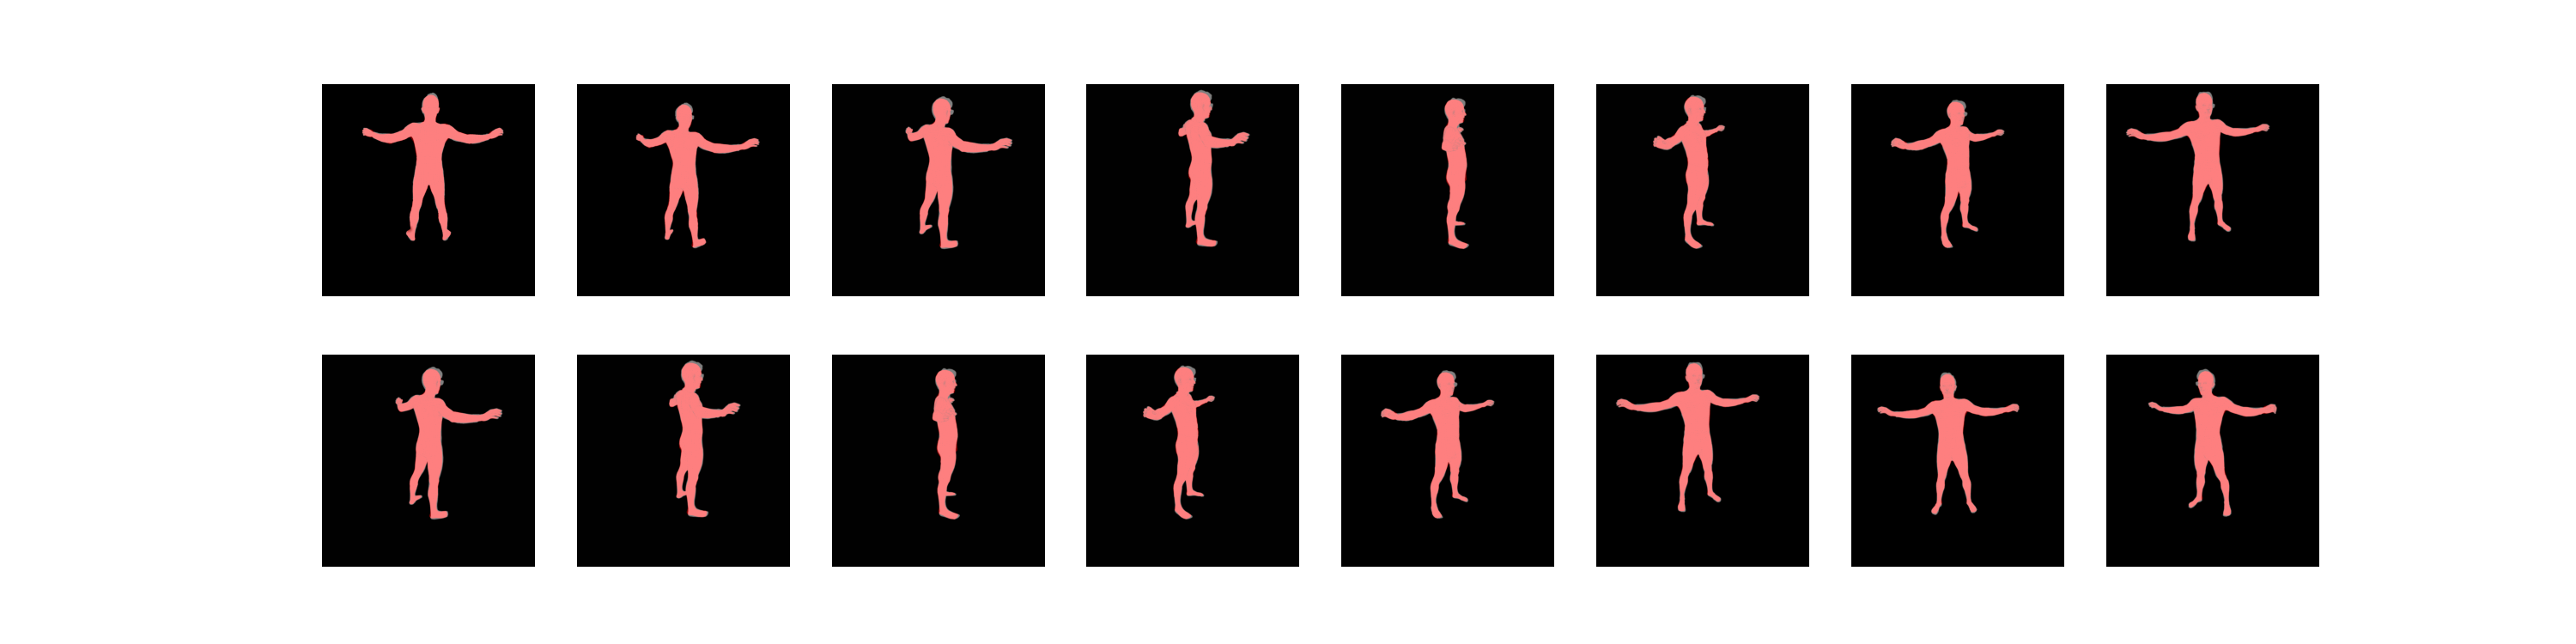

Before release: active_bytes.all.current: 103.236096 MB
After release: active_bytes.all.current: 103.236096 MB


In [17]:
images = []
with torch.no_grad():
    for iCam in range(len(cams)):
        image_cur = renderSynth.renderer(smplshMesh,  cameras=cams[iCam])
        images.append(image_cur.cpu().detach().numpy())
visualize2DSilhouetteResults(images, backGroundImages = crops_out, outImgFile=join(outFolderForExperiment, 'Initial.png'))
showCudaMemUsage(device)

In [18]:
image_cur.dtype

torch.float32

In [19]:
# with torch.no_grad():
#     loss = torch.sum((imageRef[..., 3] - image[..., 3]) ** 2)
# print('Inital loss:', loss)
poses = []
losses = []

optimizer = torch.optim.Adam([trans, pose, betas], lr=cfg.learningRate)

logFile = join(outFolderForExperiment, 'Logs.txt')
logger = Logger.configLogger(logFile)

In [20]:
smplshRegressorMatHead = torch.tensor(smplshRegressorMatHead,  dtype=torch.float32, device=device, requires_grad=False)
headKps = torch.tensor( Keypoints.points[OPHeadKeypoints, :],  dtype=torch.float32, device=device, requires_grad=False)

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


2020-06-12 15:50:16,008 logger INFO loss 1.855779, headKpFixingLoss 0.1079, MemUsed:125.41
Before release: active_bytes.all.current: 125.407232 MB
After release: active_bytes.all.current: 125.407232 MB


<IPython.core.display.Javascript object>


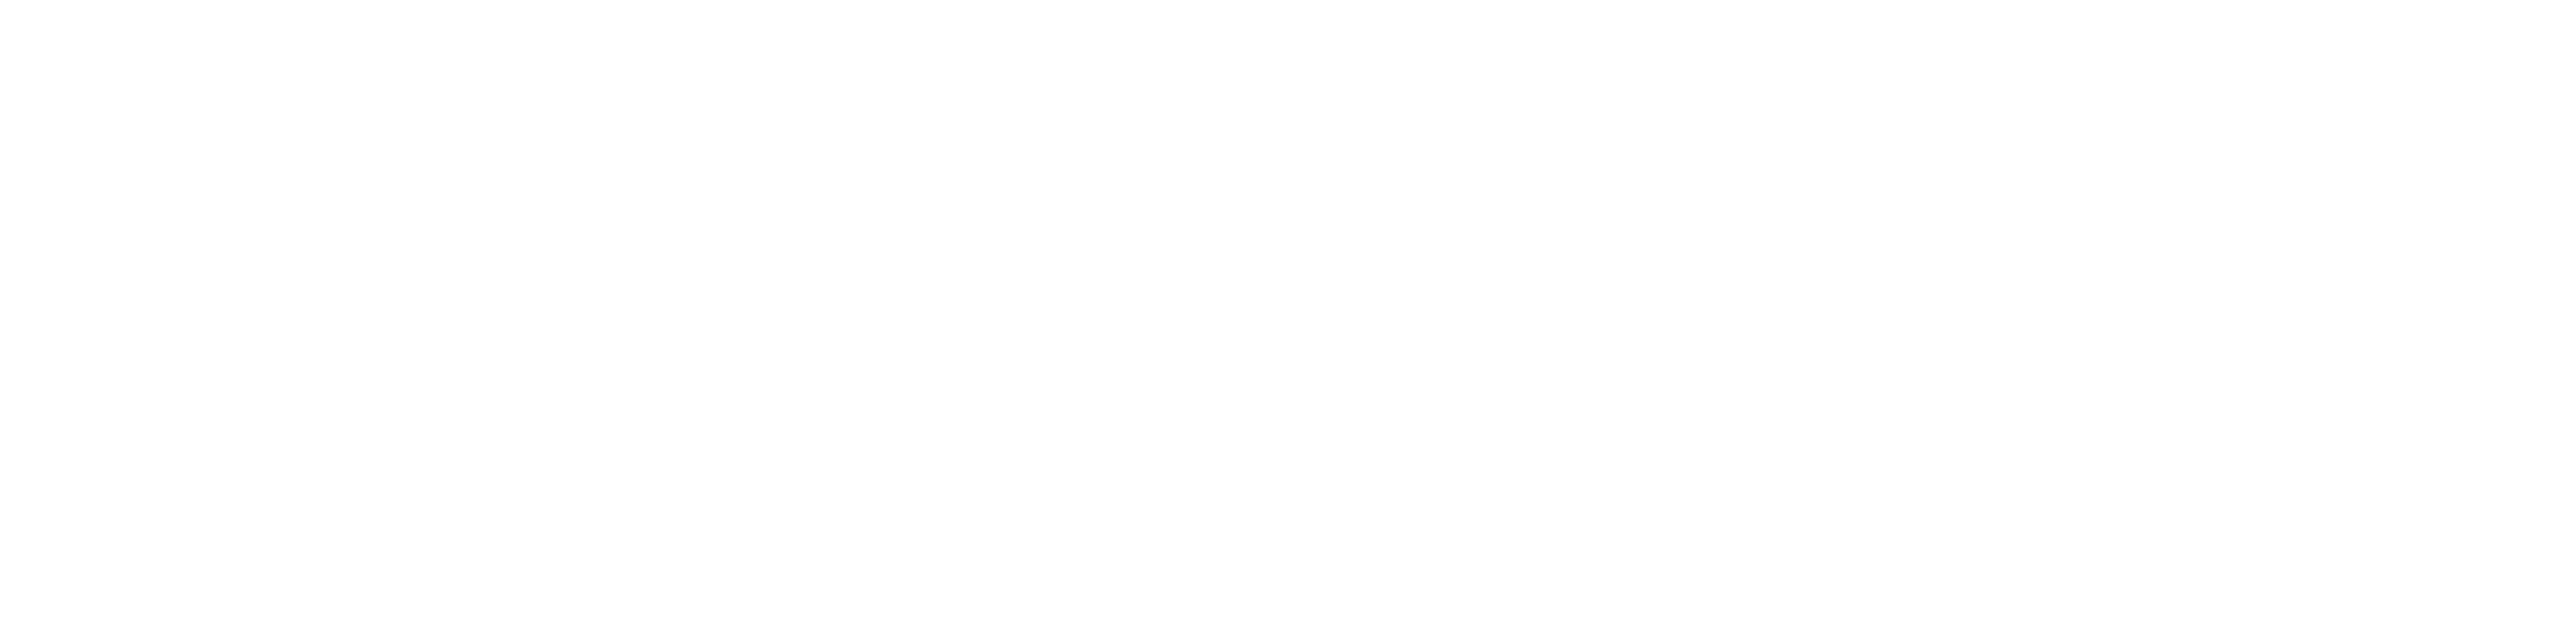

2020-06-12 15:50:40,046 logger INFO loss 1.855777, headKpFixingLoss 0.1079, MemUsed:125.43
2020-06-12 15:50:46,684 logger INFO loss 1.963772, headKpFixingLoss 0.1209, MemUsed:125.43
2020-06-12 15:50:53,651 logger INFO loss 1.889053, headKpFixingLoss 0.1199, MemUsed:125.41
2020-06-12 15:51:00,295 logger INFO loss 1.867037, headKpFixingLoss 0.1215, MemUsed:125.43
2020-06-12 15:51:06,877 logger INFO loss 1.852713, headKpFixingLoss 0.1101, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


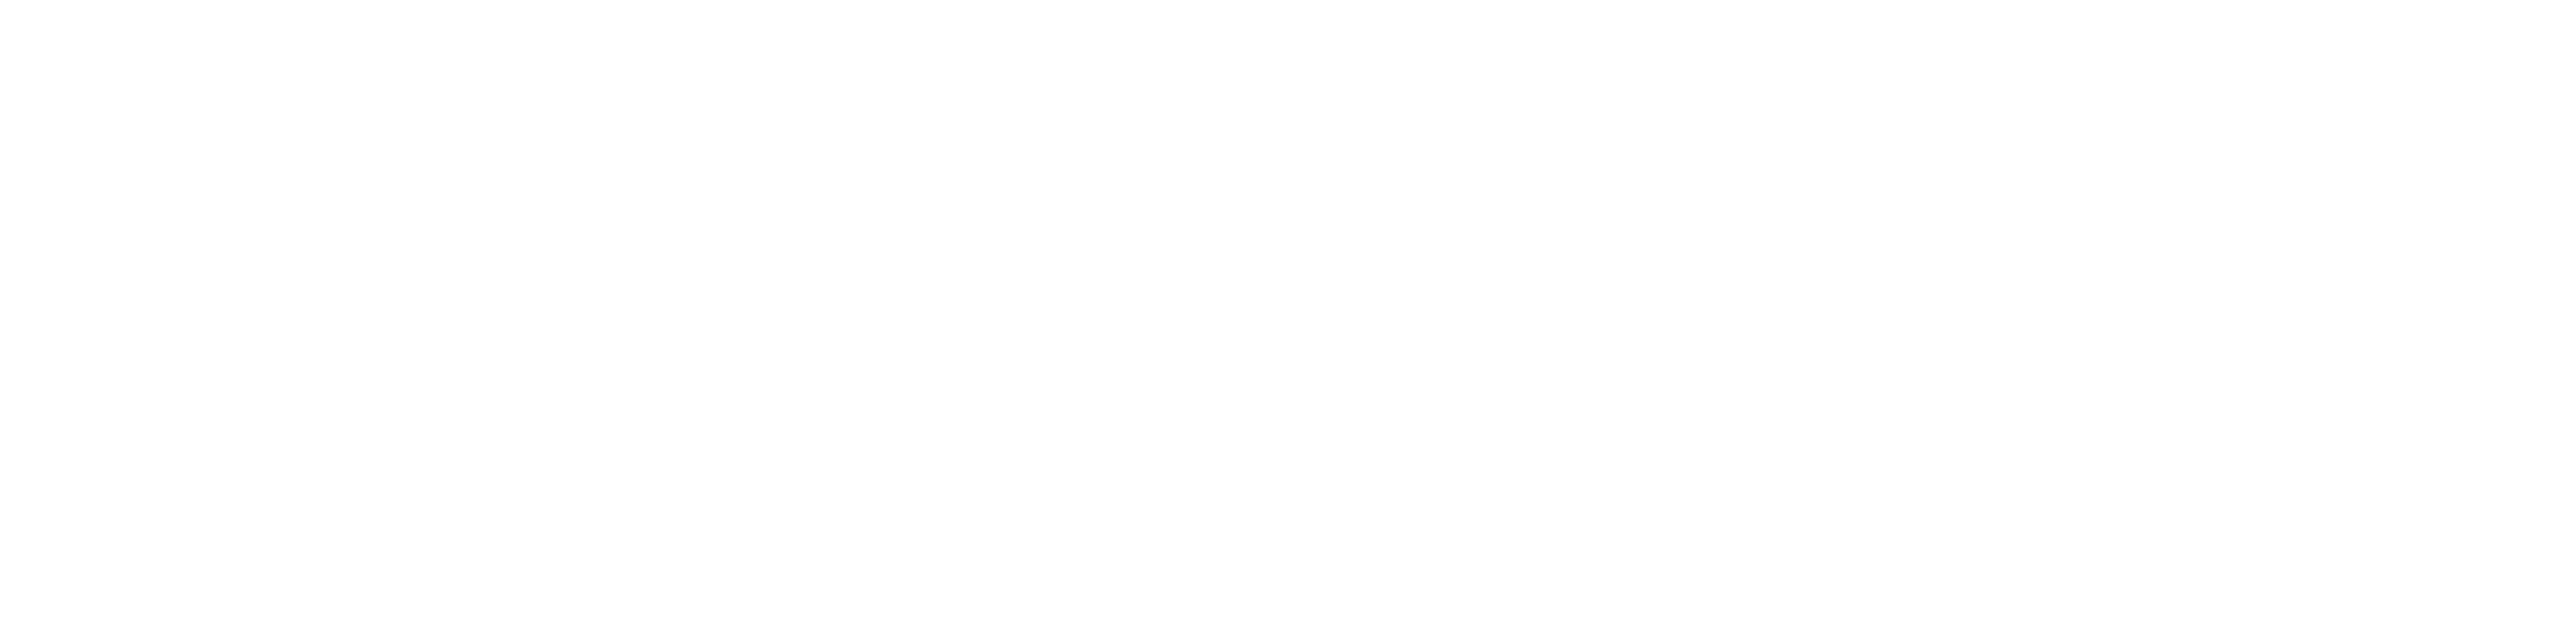

2020-06-12 15:51:30,717 logger INFO loss 1.861605, headKpFixingLoss 0.1038, MemUsed:125.41
2020-06-12 15:51:37,300 logger INFO loss 1.859738, headKpFixingLoss 0.1059, MemUsed:125.41
2020-06-12 15:51:44,100 logger INFO loss 1.831220, headKpFixingLoss 0.1096, MemUsed:125.41
2020-06-12 15:51:50,735 logger INFO loss 1.800268, headKpFixingLoss 0.1158, MemUsed:125.41
2020-06-12 15:51:57,320 logger INFO loss 1.802565, headKpFixingLoss 0.1263, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


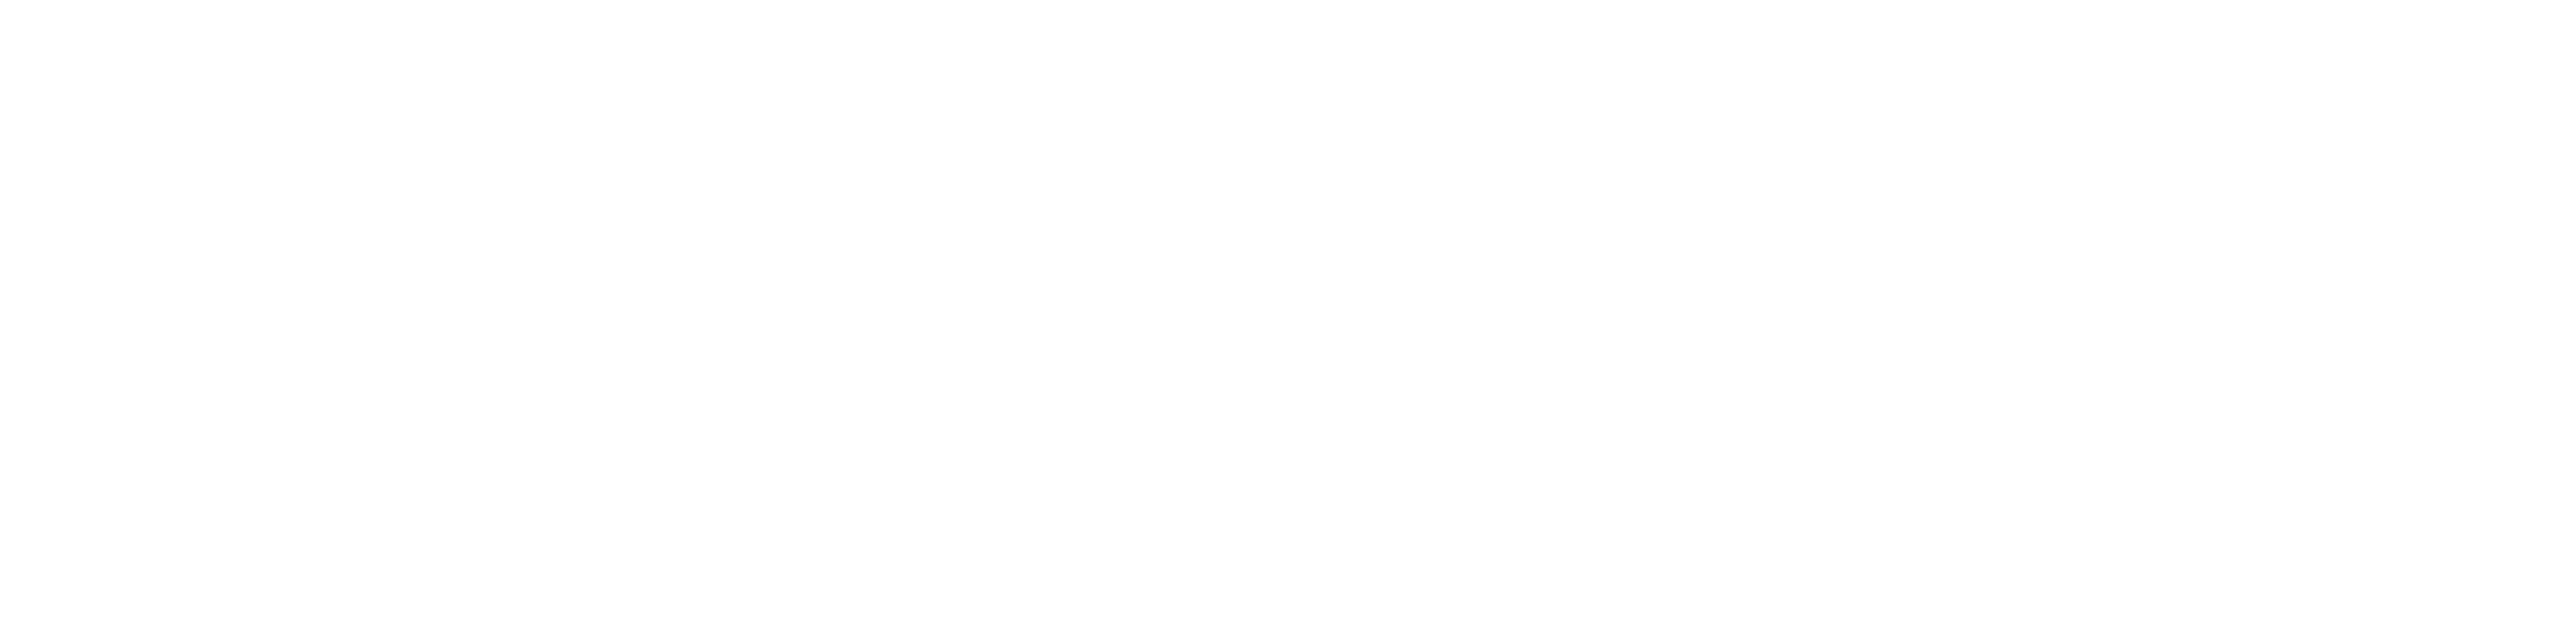

2020-06-12 15:52:21,648 logger INFO loss 1.800719, headKpFixingLoss 0.1345, MemUsed:125.41
2020-06-12 15:52:28,520 logger INFO loss 1.793545, headKpFixingLoss 0.1363, MemUsed:125.41
2020-06-12 15:52:35,096 logger INFO loss 1.792167, headKpFixingLoss 0.1284, MemUsed:125.41
2020-06-12 15:52:41,654 logger INFO loss 1.784648, headKpFixingLoss 0.1197, MemUsed:125.41
2020-06-12 15:52:48,412 logger INFO loss 1.782405, headKpFixingLoss 0.1151, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


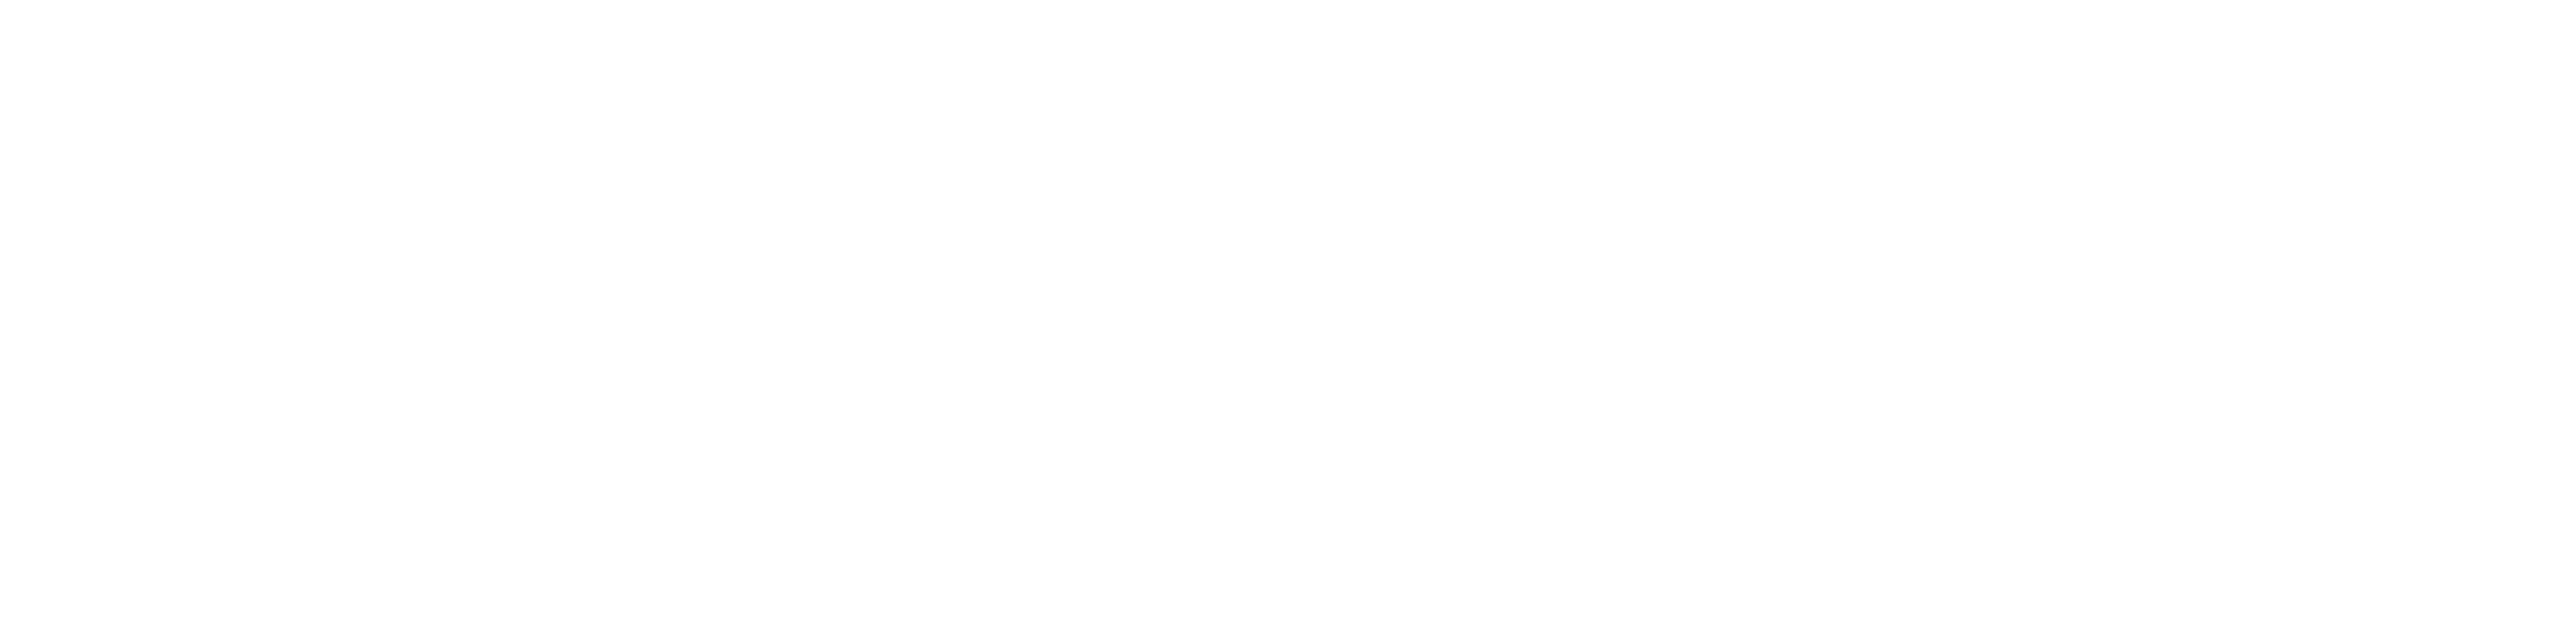

2020-06-12 15:53:12,449 logger INFO loss 1.785720, headKpFixingLoss 0.1157, MemUsed:125.41
2020-06-12 15:53:18,881 logger INFO loss 1.779943, headKpFixingLoss 0.1175, MemUsed:125.41
2020-06-12 15:53:25,514 logger INFO loss 1.764461, headKpFixingLoss 0.1188, MemUsed:125.41
2020-06-12 15:53:32,094 logger INFO loss 1.757610, headKpFixingLoss 0.1216, MemUsed:125.41
2020-06-12 15:53:38,544 logger INFO loss 1.757087, headKpFixingLoss 0.1259, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


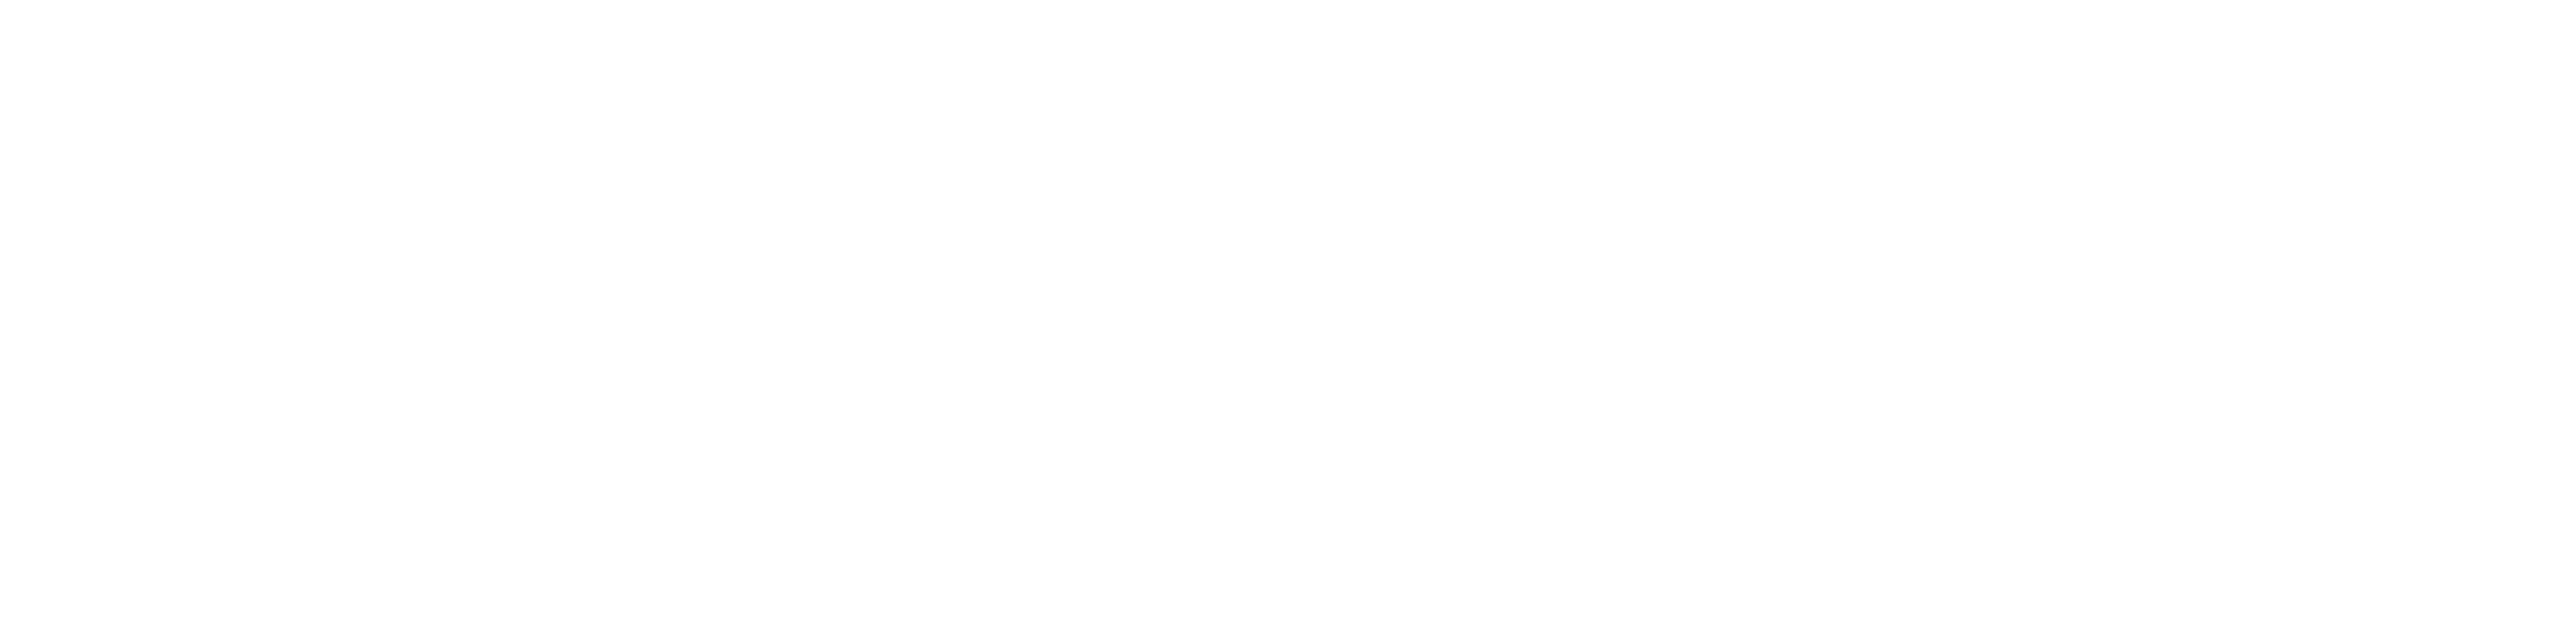

2020-06-12 15:54:02,024 logger INFO loss 1.751408, headKpFixingLoss 0.1303, MemUsed:125.41
2020-06-12 15:54:08,417 logger INFO loss 1.747380, headKpFixingLoss 0.1324, MemUsed:125.41
2020-06-12 15:54:14,863 logger INFO loss 1.744705, headKpFixingLoss 0.1305, MemUsed:125.41
2020-06-12 15:54:21,331 logger INFO loss 1.743117, headKpFixingLoss 0.1264, MemUsed:125.41
2020-06-12 15:54:27,790 logger INFO loss 1.744102, headKpFixingLoss 0.1234, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


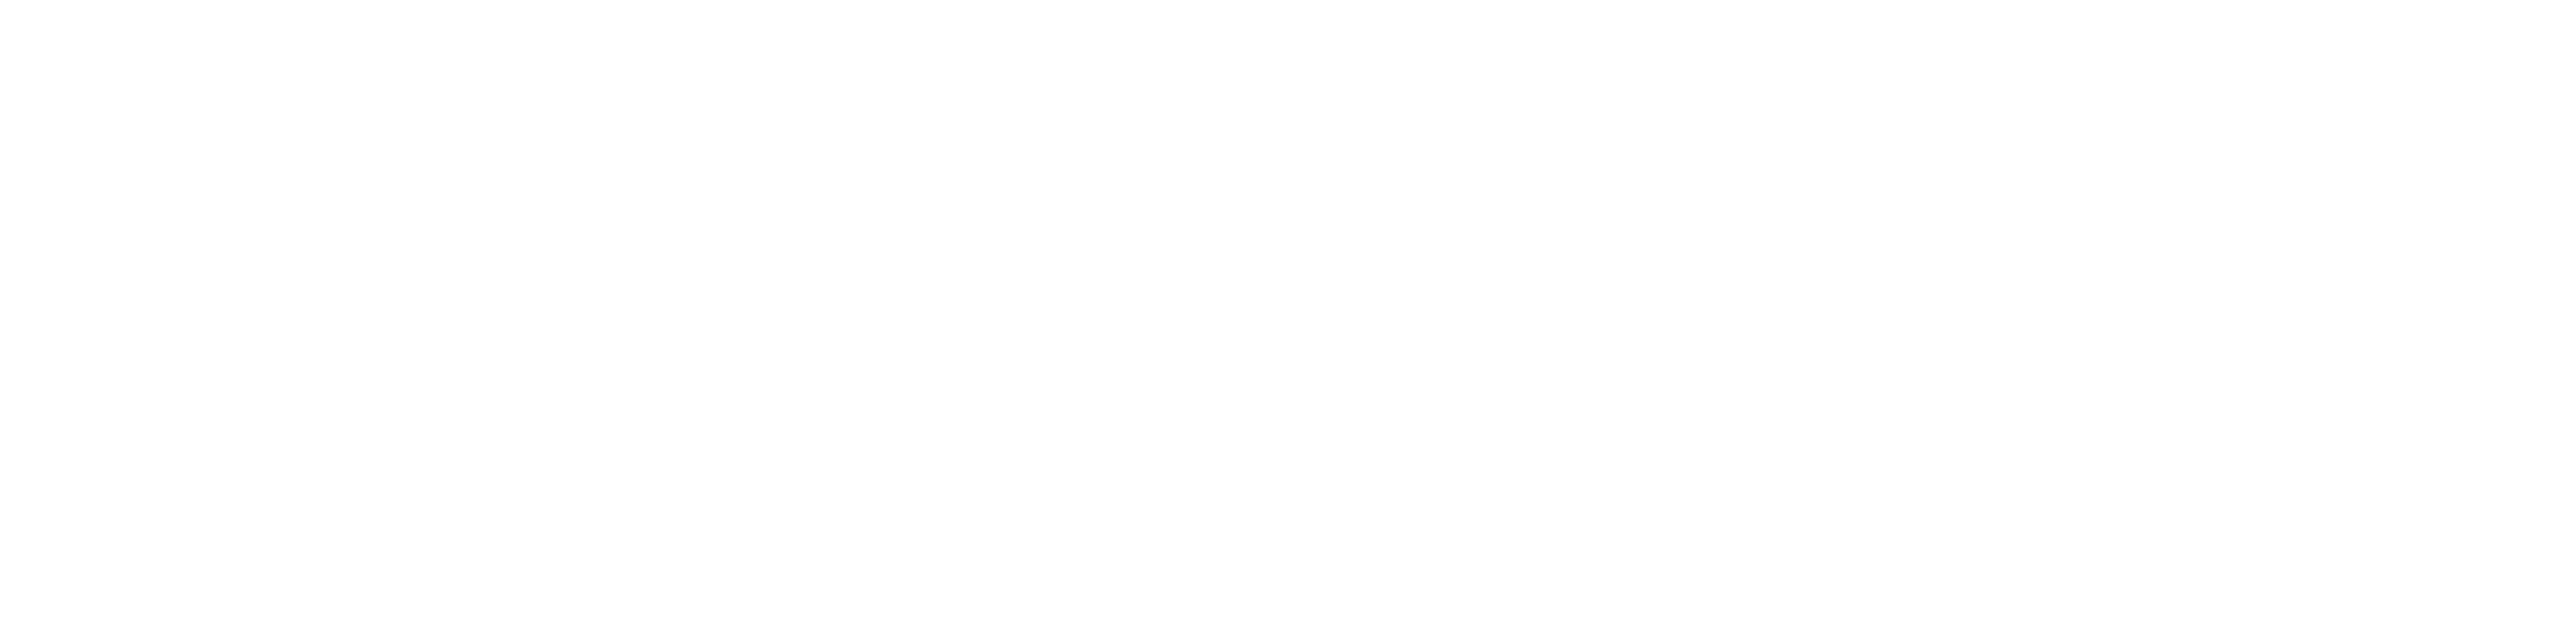

2020-06-12 15:54:51,727 logger INFO loss 1.739759, headKpFixingLoss 0.1222, MemUsed:125.41
2020-06-12 15:54:58,143 logger INFO loss 1.735090, headKpFixingLoss 0.1235, MemUsed:125.41
2020-06-12 15:55:04,579 logger INFO loss 1.729819, headKpFixingLoss 0.1259, MemUsed:125.41
2020-06-12 15:55:11,017 logger INFO loss 1.725897, headKpFixingLoss 0.1281, MemUsed:125.41
2020-06-12 15:55:17,459 logger INFO loss 1.721782, headKpFixingLoss 0.1294, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


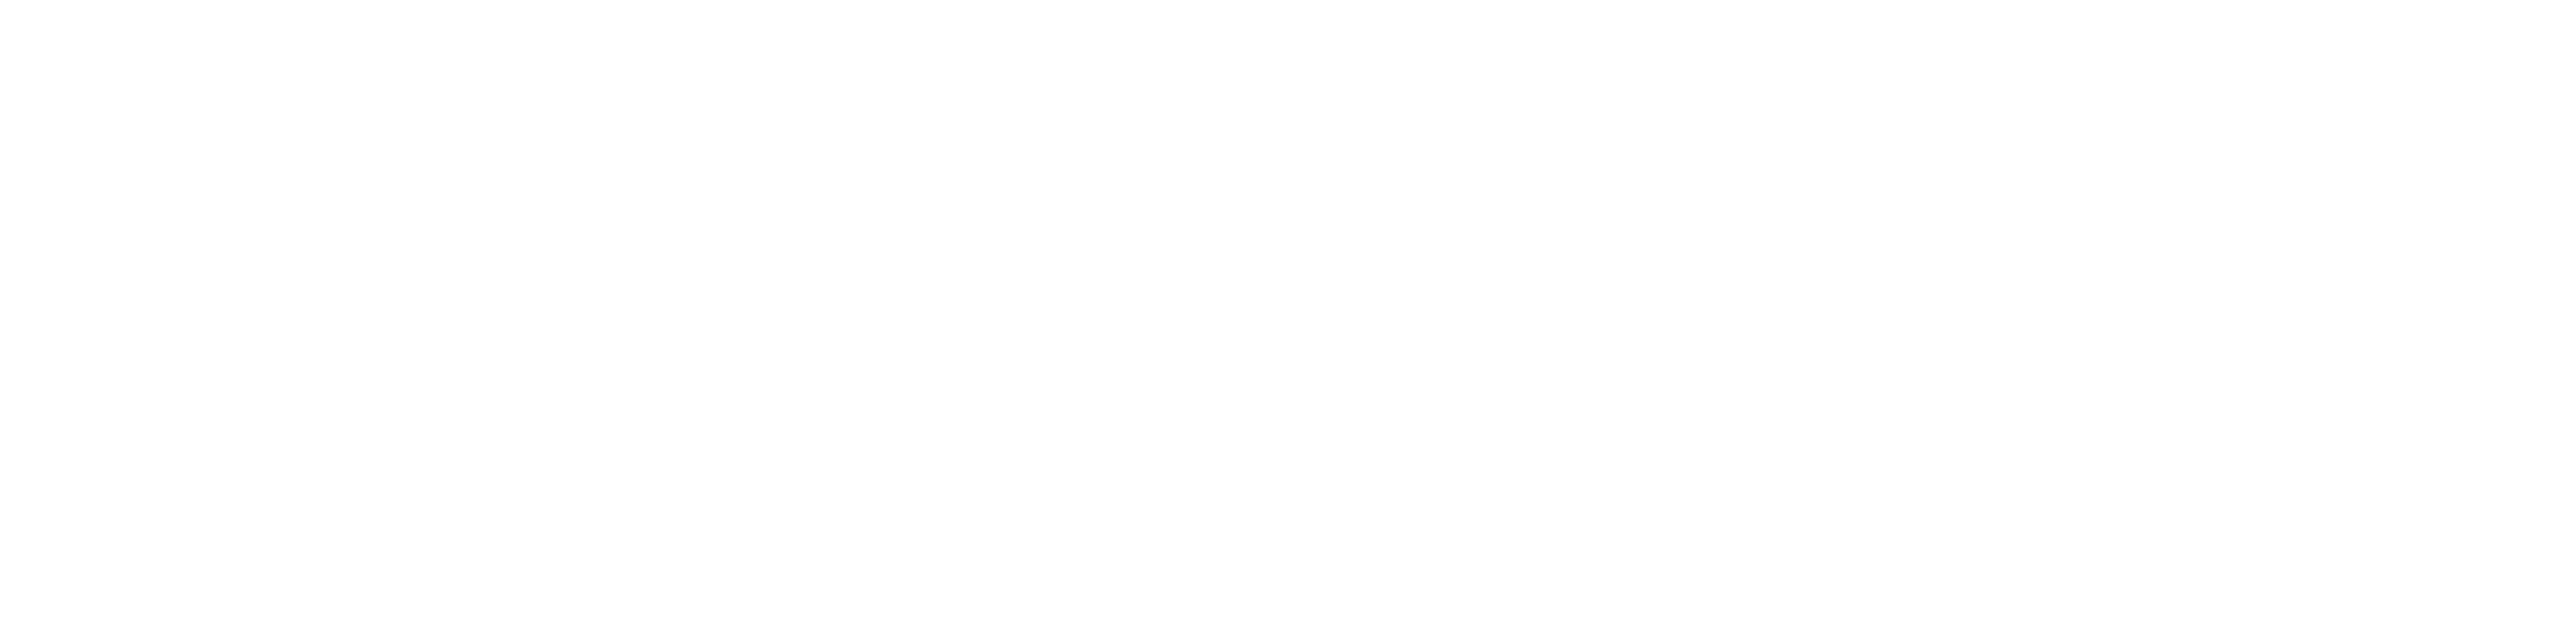

2020-06-12 15:55:41,113 logger INFO loss 1.717038, headKpFixingLoss 0.1299, MemUsed:125.41
2020-06-12 15:55:47,553 logger INFO loss 1.715067, headKpFixingLoss 0.1298, MemUsed:125.41
2020-06-12 15:55:53,976 logger INFO loss 1.713641, headKpFixingLoss 0.1295, MemUsed:125.41
2020-06-12 15:56:00,439 logger INFO loss 1.713479, headKpFixingLoss 0.1292, MemUsed:125.41
2020-06-12 15:56:06,952 logger INFO loss 1.711300, headKpFixingLoss 0.1290, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


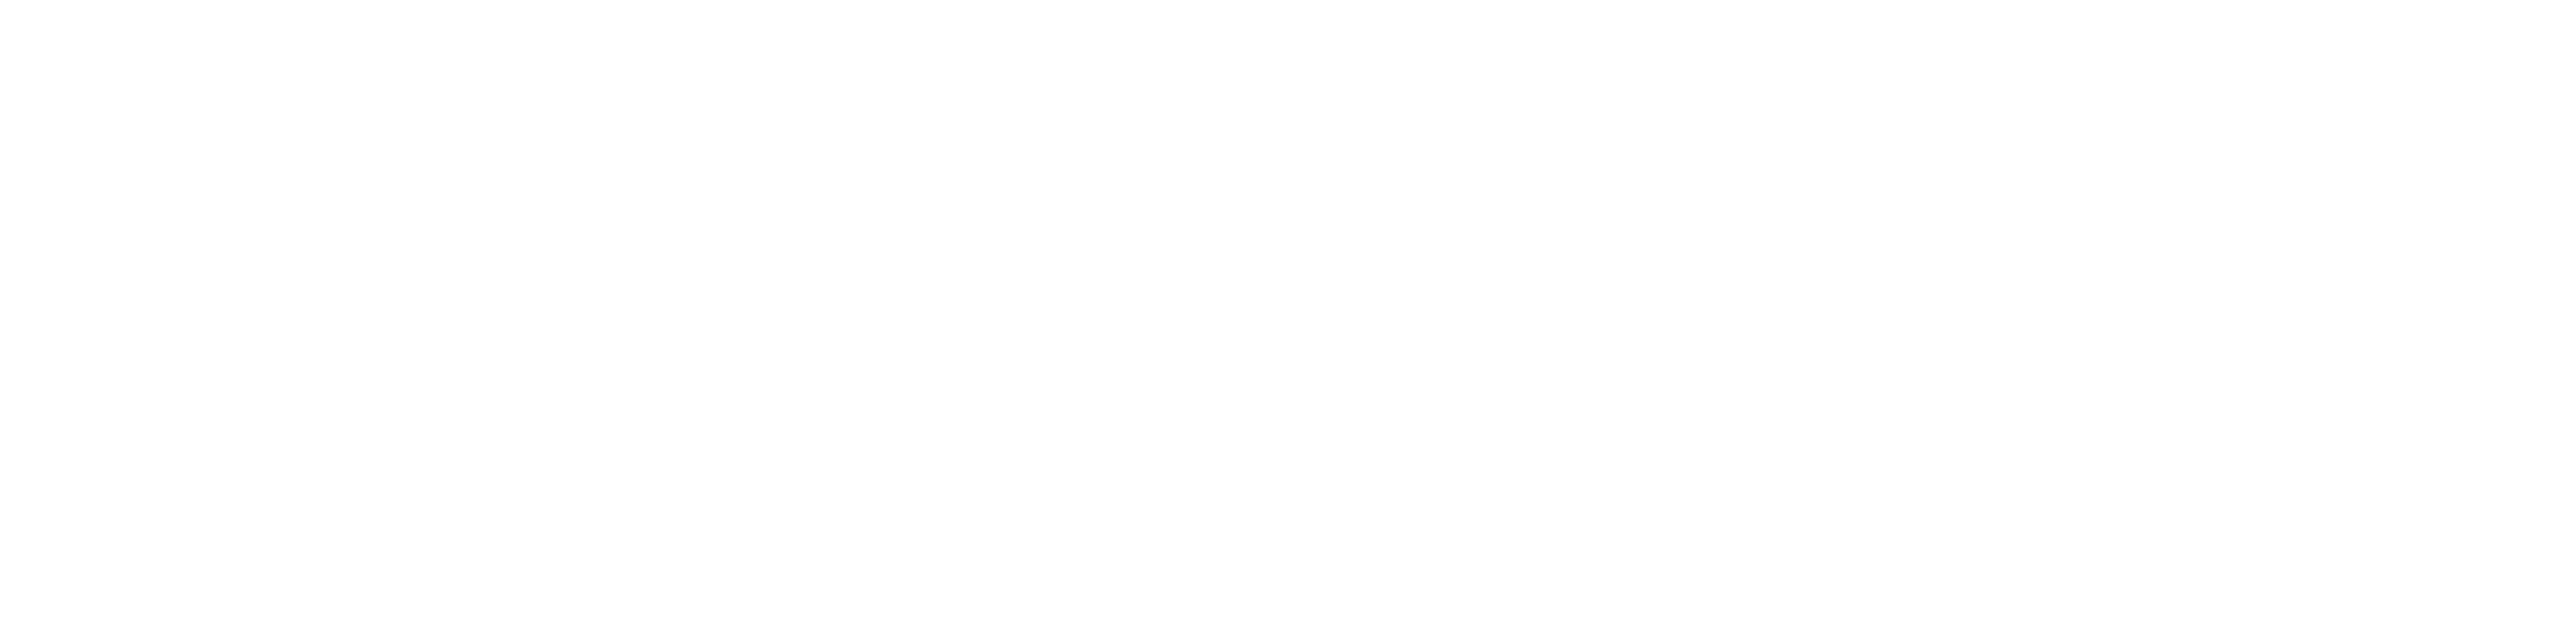

2020-06-12 15:56:30,770 logger INFO loss 1.706980, headKpFixingLoss 0.1292, MemUsed:125.41
2020-06-12 15:56:37,289 logger INFO loss 1.702669, headKpFixingLoss 0.1298, MemUsed:125.41
2020-06-12 15:56:43,841 logger INFO loss 1.700691, headKpFixingLoss 0.1305, MemUsed:125.41
2020-06-12 15:56:50,356 logger INFO loss 1.698956, headKpFixingLoss 0.1308, MemUsed:125.41
2020-06-12 15:56:56,978 logger INFO loss 1.694737, headKpFixingLoss 0.1306, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


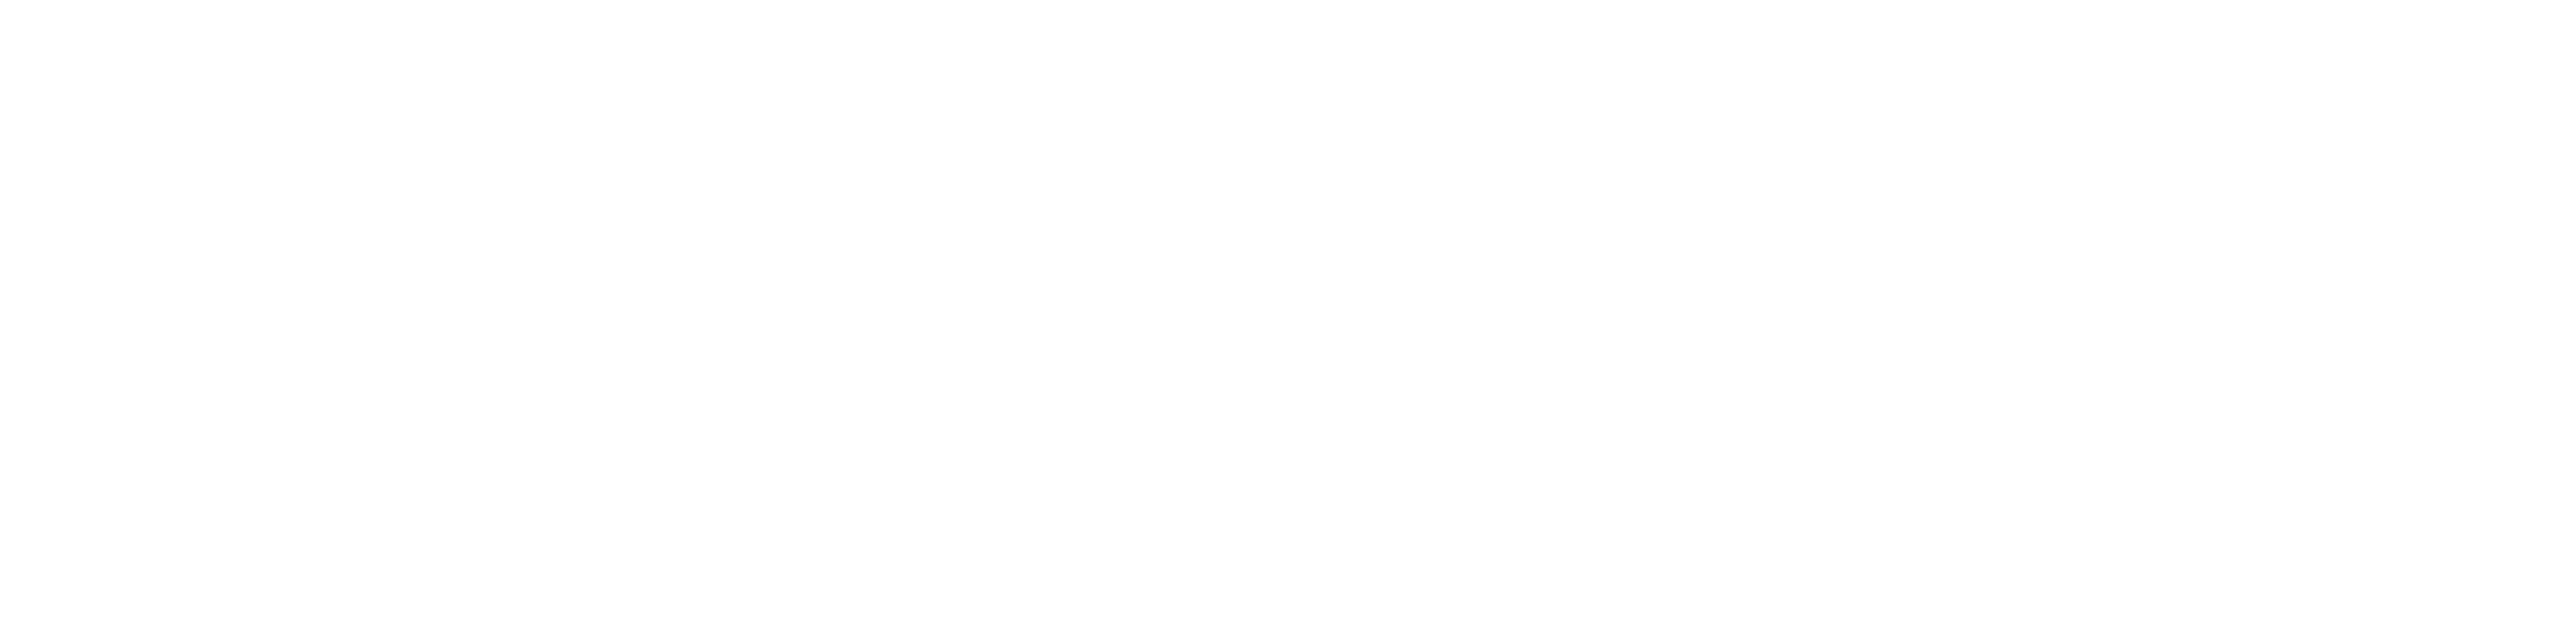

2020-06-12 15:57:21,143 logger INFO loss 1.692703, headKpFixingLoss 0.1300, MemUsed:125.41
2020-06-12 15:57:27,484 logger INFO loss 1.691962, headKpFixingLoss 0.1297, MemUsed:125.41
2020-06-12 15:57:33,837 logger INFO loss 1.690367, headKpFixingLoss 0.1302, MemUsed:125.41
2020-06-12 15:57:40,187 logger INFO loss 1.688242, headKpFixingLoss 0.1312, MemUsed:125.41
2020-06-12 15:57:46,559 logger INFO loss 1.683535, headKpFixingLoss 0.1325, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


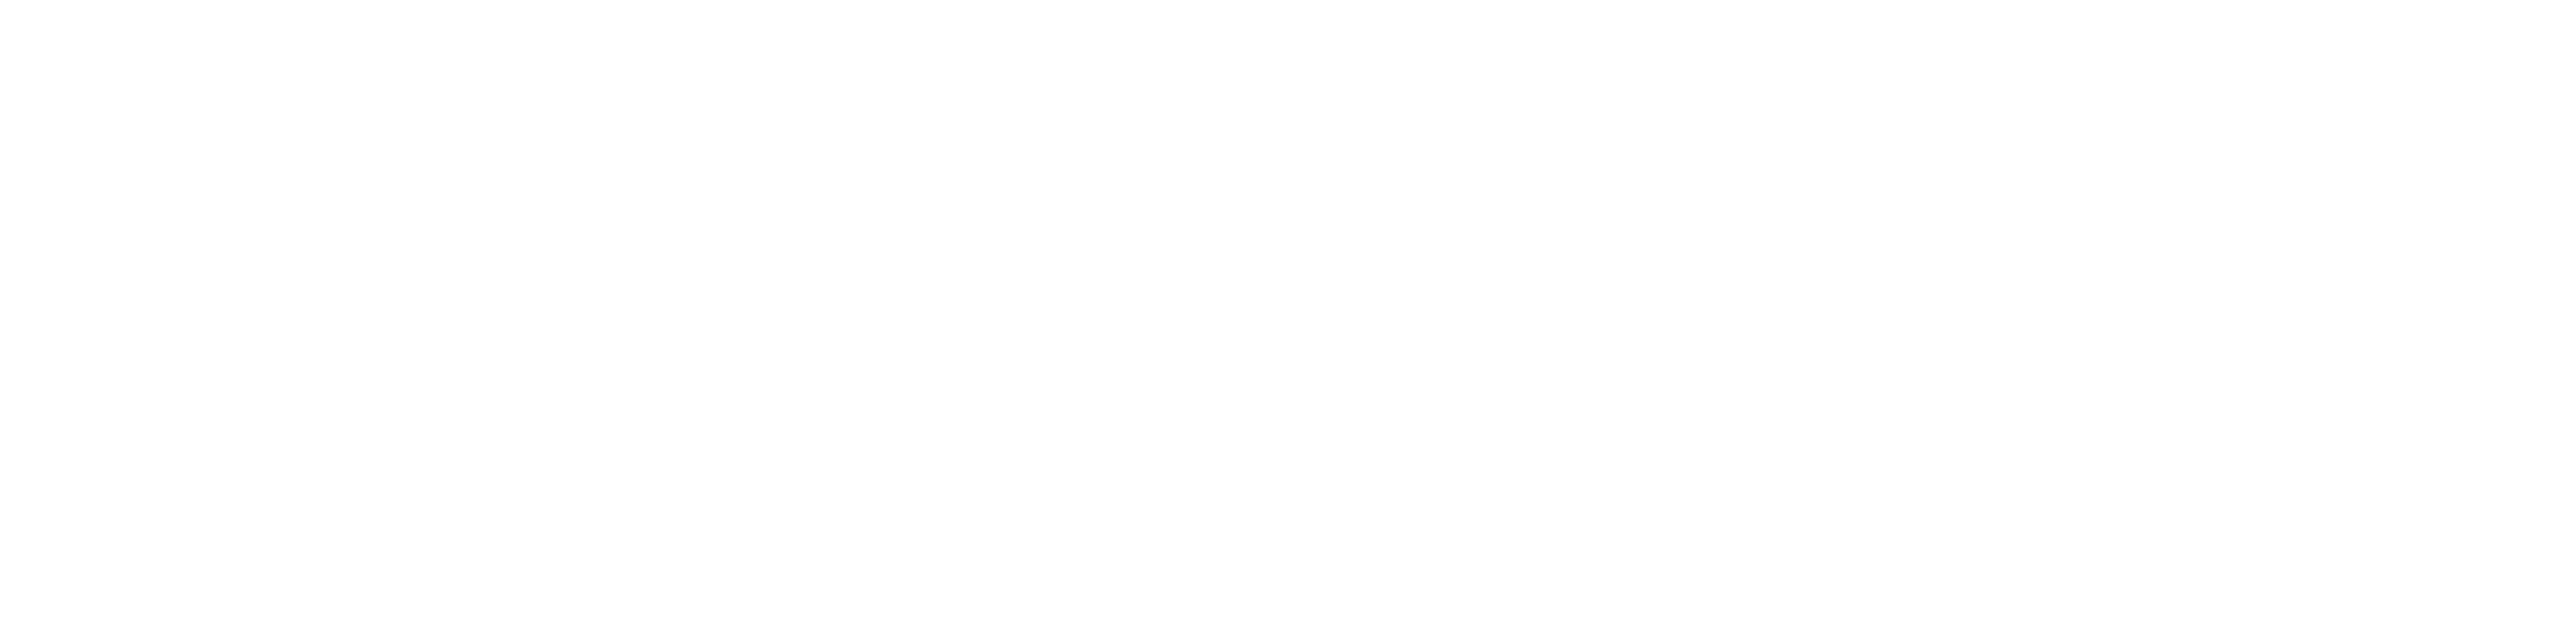

2020-06-12 15:58:10,210 logger INFO loss 1.681186, headKpFixingLoss 0.1335, MemUsed:125.41
2020-06-12 15:58:16,673 logger INFO loss 1.678445, headKpFixingLoss 0.1326, MemUsed:125.41
2020-06-12 15:58:23,101 logger INFO loss 1.677639, headKpFixingLoss 0.1314, MemUsed:125.41
2020-06-12 15:58:29,545 logger INFO loss 1.676770, headKpFixingLoss 0.1304, MemUsed:125.41
2020-06-12 15:58:35,968 logger INFO loss 1.674627, headKpFixingLoss 0.1307, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


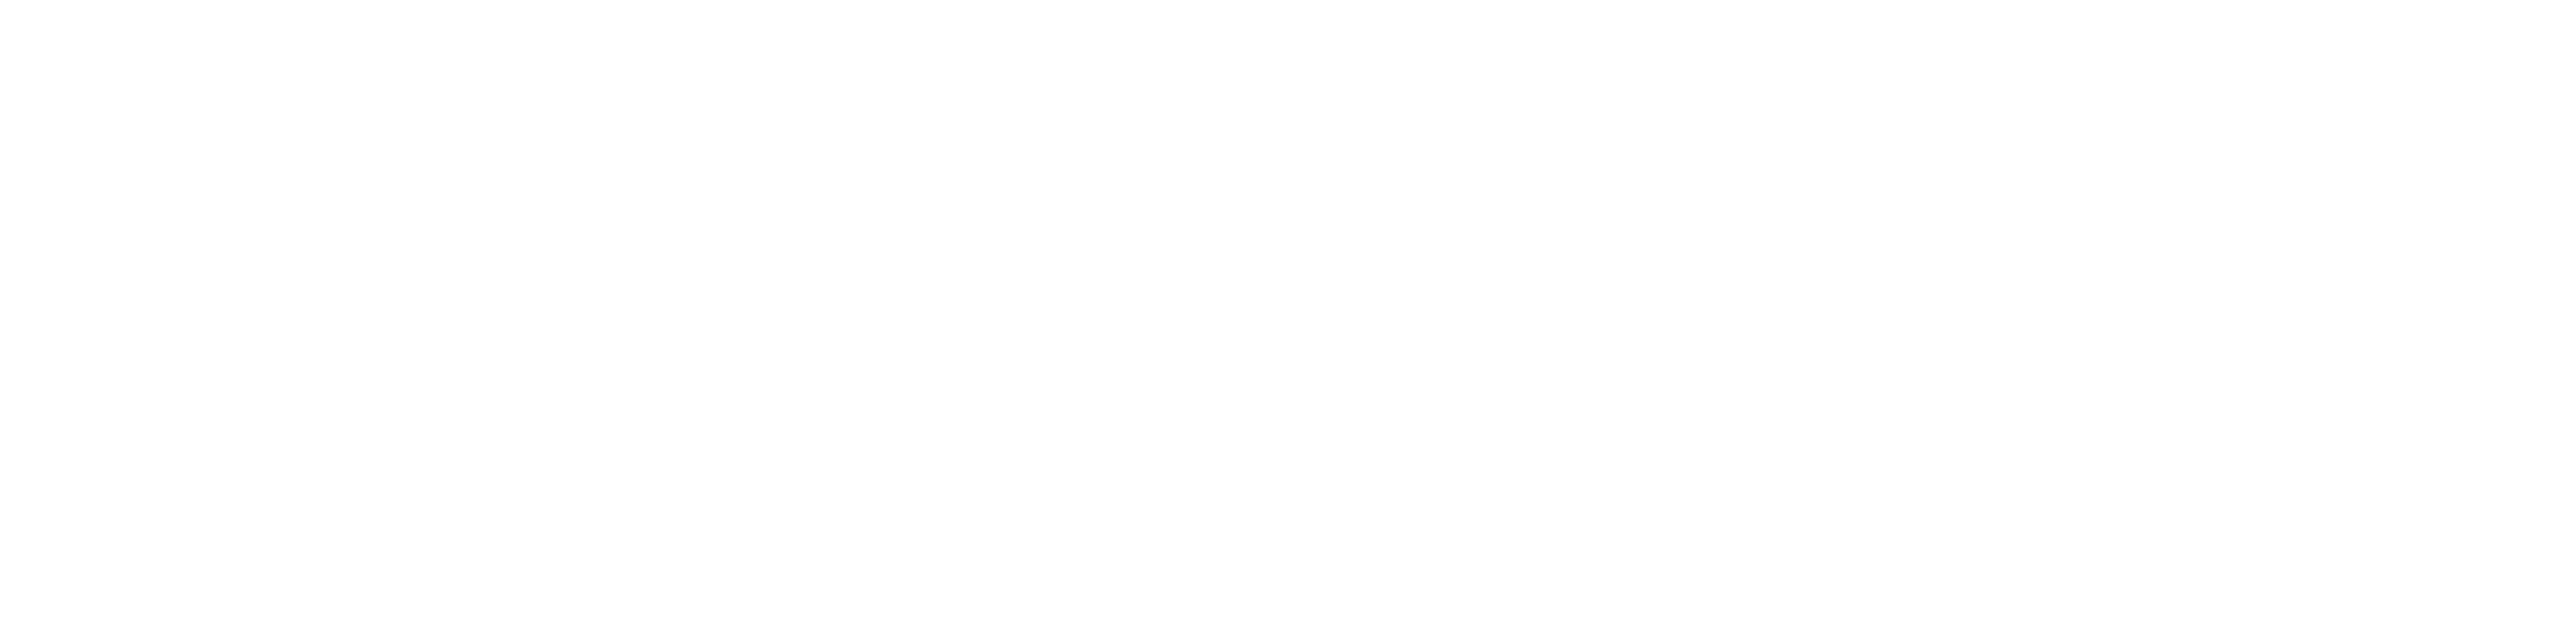

2020-06-12 15:58:59,839 logger INFO loss 1.671245, headKpFixingLoss 0.1321, MemUsed:125.41
2020-06-12 15:59:06,244 logger INFO loss 1.668596, headKpFixingLoss 0.1333, MemUsed:125.41
2020-06-12 15:59:12,704 logger INFO loss 1.667921, headKpFixingLoss 0.1334, MemUsed:125.41
2020-06-12 15:59:19,071 logger INFO loss 1.665254, headKpFixingLoss 0.1333, MemUsed:125.41
2020-06-12 15:59:25,580 logger INFO loss 1.663738, headKpFixingLoss 0.1331, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


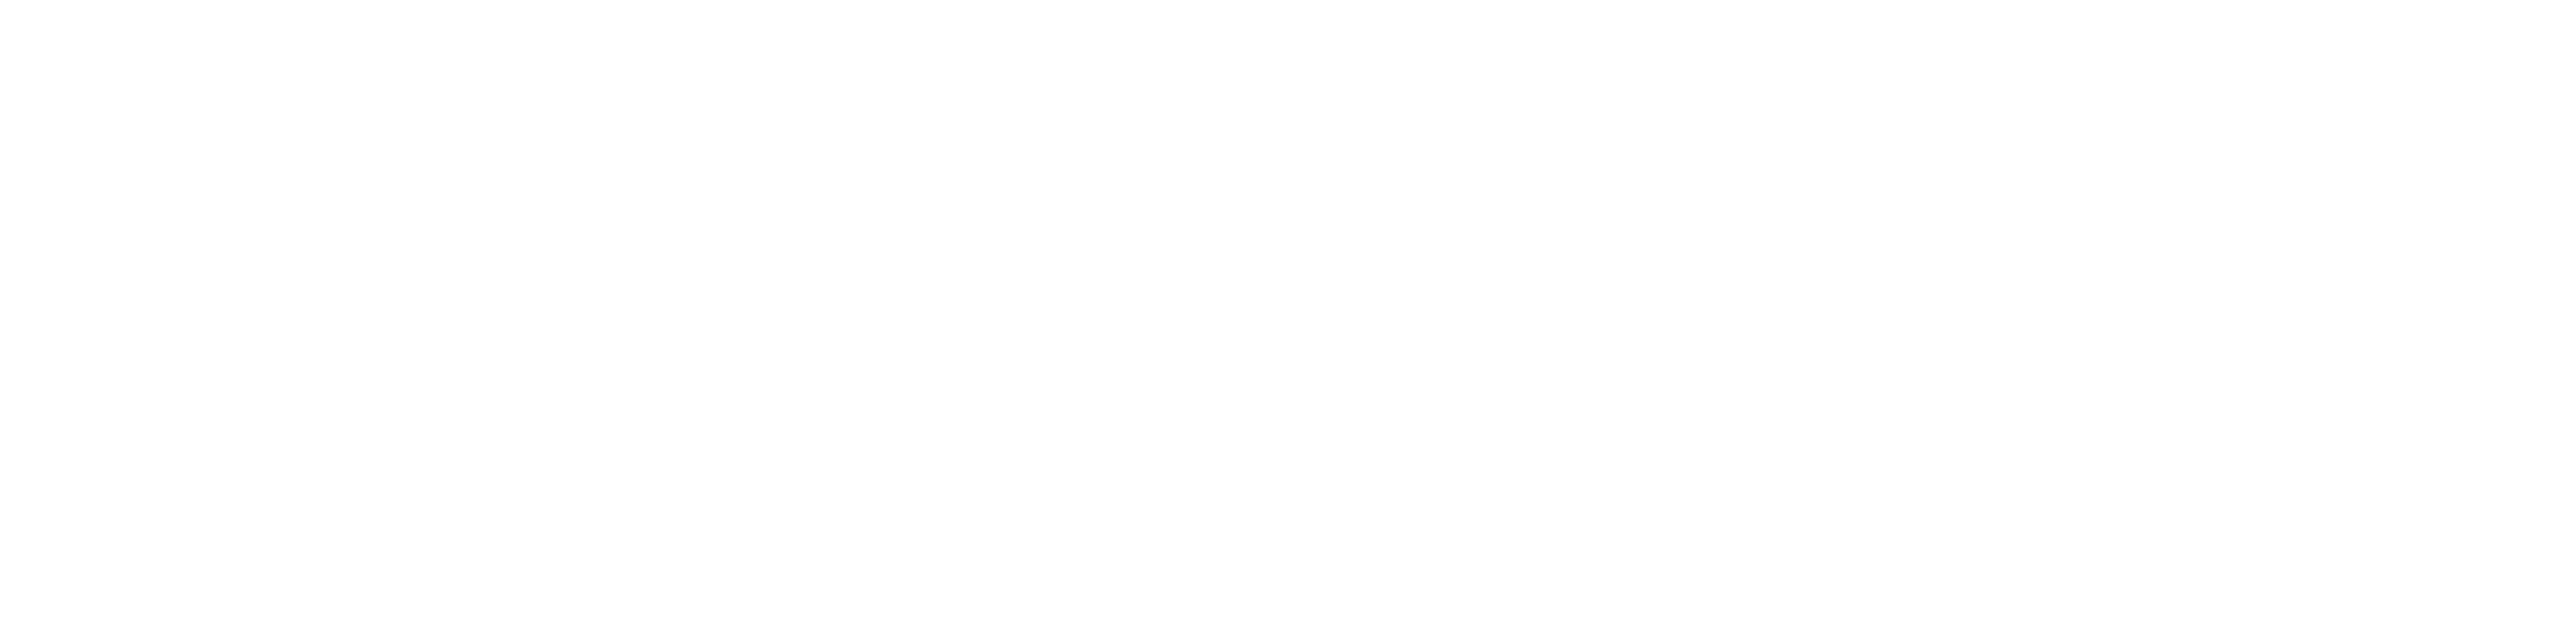

2020-06-12 15:59:49,093 logger INFO loss 1.662069, headKpFixingLoss 0.1326, MemUsed:125.41
2020-06-12 15:59:55,447 logger INFO loss 1.662016, headKpFixingLoss 0.1325, MemUsed:125.41
2020-06-12 16:00:01,840 logger INFO loss 1.658610, headKpFixingLoss 0.1335, MemUsed:125.41
2020-06-12 16:00:08,284 logger INFO loss 1.655227, headKpFixingLoss 0.1347, MemUsed:125.41
2020-06-12 16:00:14,631 logger INFO loss 1.652994, headKpFixingLoss 0.1352, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


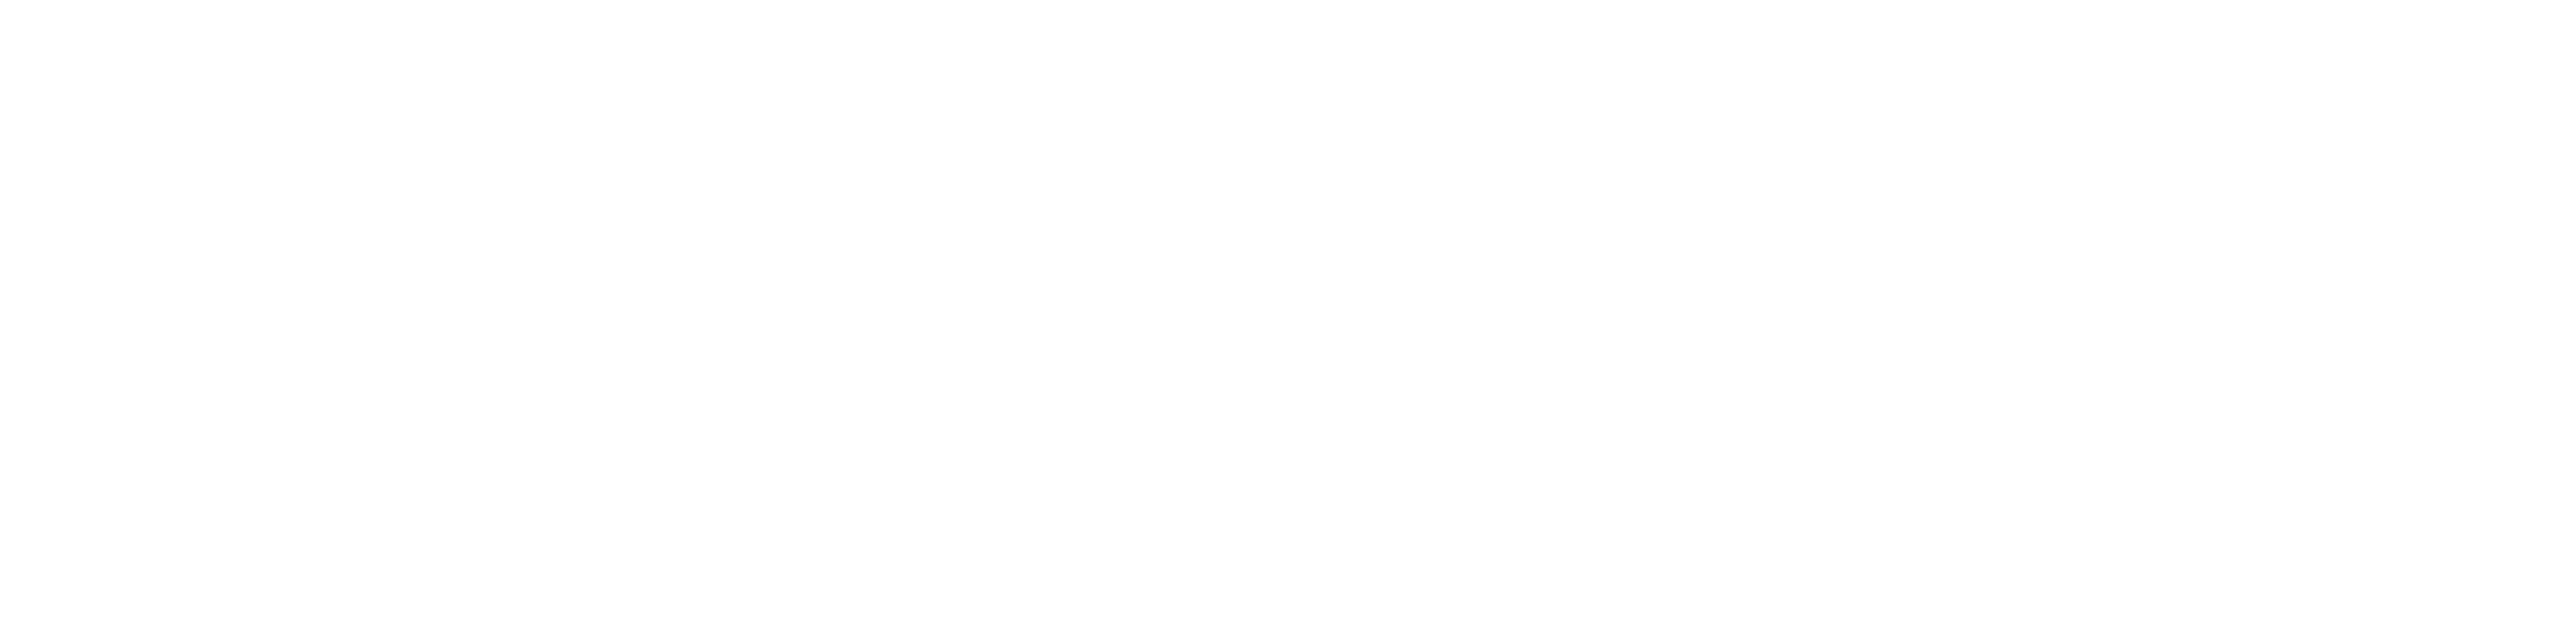

2020-06-12 16:00:37,967 logger INFO loss 1.652047, headKpFixingLoss 0.1351, MemUsed:125.41
2020-06-12 16:00:44,356 logger INFO loss 1.651486, headKpFixingLoss 0.1349, MemUsed:125.41
2020-06-12 16:00:50,871 logger INFO loss 1.649520, headKpFixingLoss 0.1350, MemUsed:125.41
2020-06-12 16:00:57,268 logger INFO loss 1.647325, headKpFixingLoss 0.1358, MemUsed:125.41
2020-06-12 16:01:03,670 logger INFO loss 1.644885, headKpFixingLoss 0.1364, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


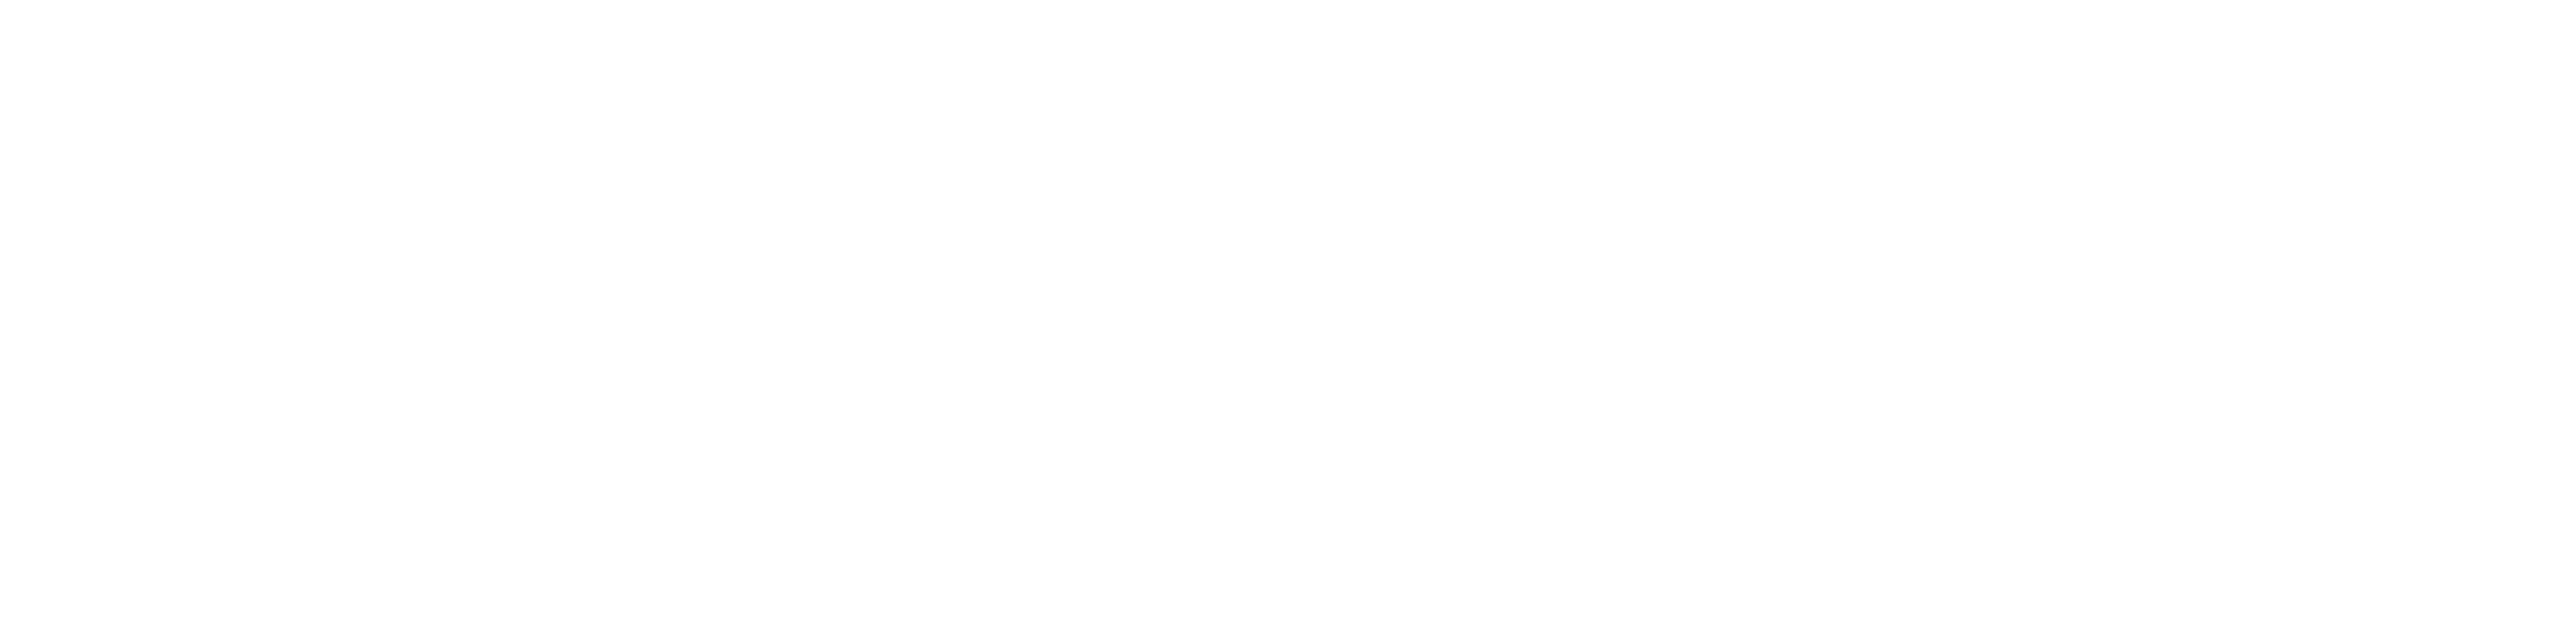

2020-06-12 16:01:27,398 logger INFO loss 1.644219, headKpFixingLoss 0.1362, MemUsed:125.41
2020-06-12 16:01:33,828 logger INFO loss 1.643946, headKpFixingLoss 0.1355, MemUsed:125.41
2020-06-12 16:01:40,286 logger INFO loss 1.642341, headKpFixingLoss 0.1354, MemUsed:125.41
2020-06-12 16:01:46,754 logger INFO loss 1.641664, headKpFixingLoss 0.1354, MemUsed:125.41
2020-06-12 16:01:53,185 logger INFO loss 1.639725, headKpFixingLoss 0.1354, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


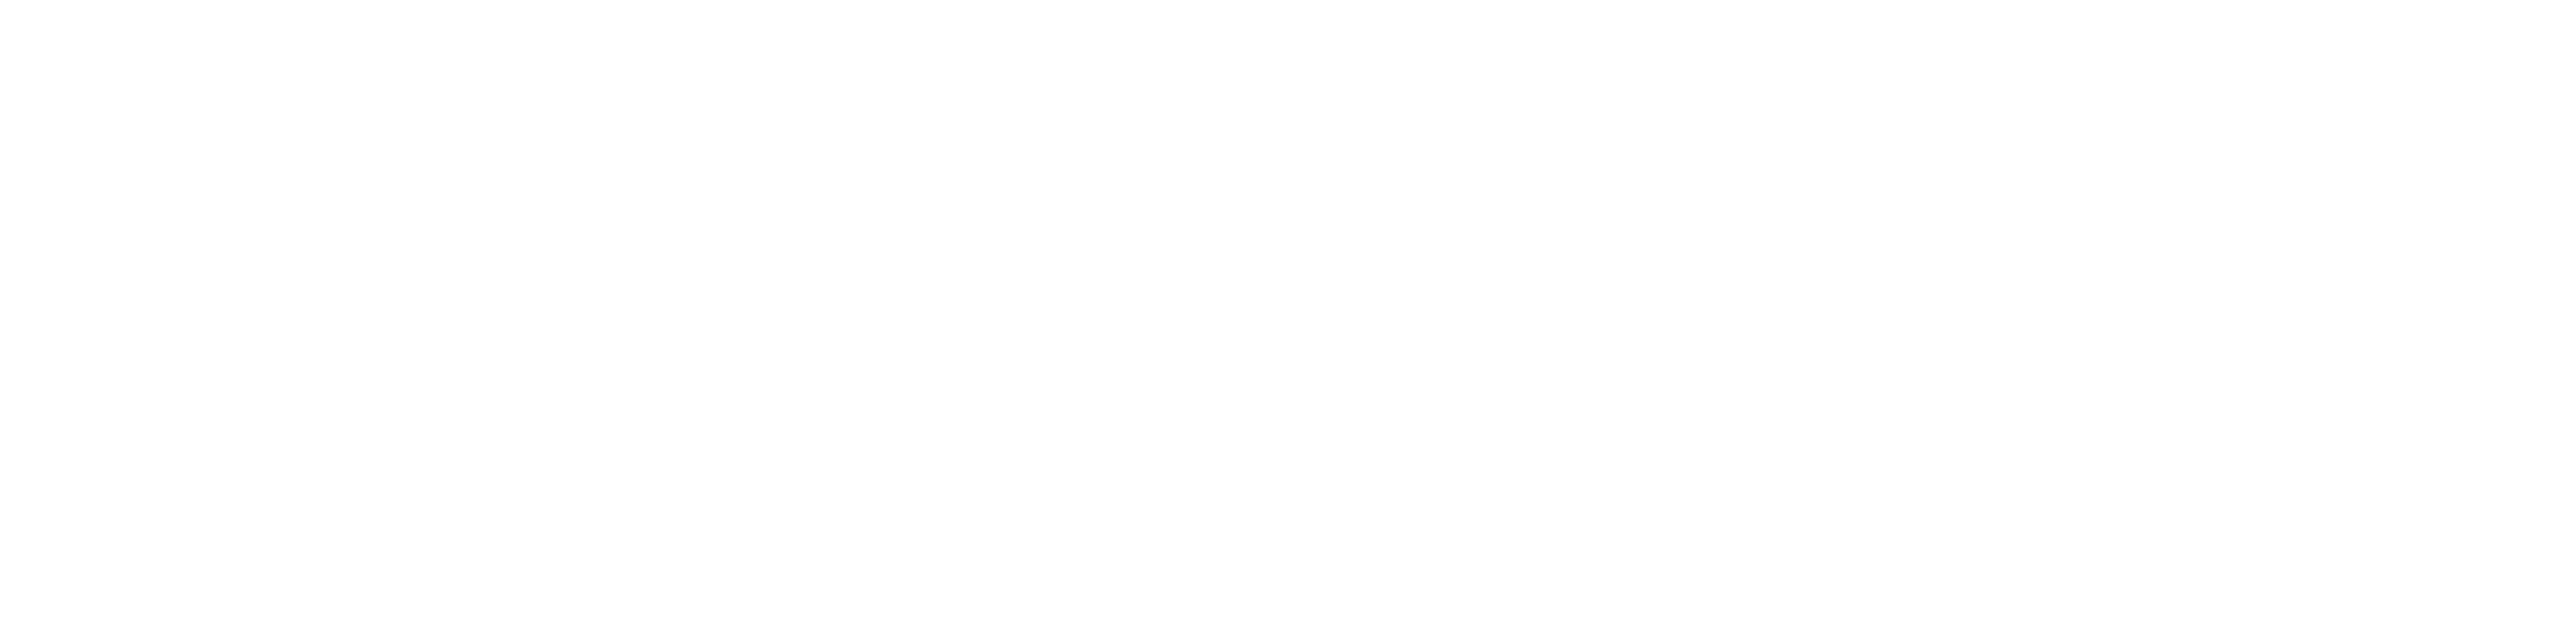

2020-06-12 16:02:16,748 logger INFO loss 1.637807, headKpFixingLoss 0.1362, MemUsed:125.41
2020-06-12 16:02:23,288 logger INFO loss 1.636455, headKpFixingLoss 0.1370, MemUsed:125.41
2020-06-12 16:02:29,753 logger INFO loss 1.635157, headKpFixingLoss 0.1375, MemUsed:125.41
2020-06-12 16:02:36,350 logger INFO loss 1.633892, headKpFixingLoss 0.1377, MemUsed:125.41
2020-06-12 16:02:42,805 logger INFO loss 1.632646, headKpFixingLoss 0.1377, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


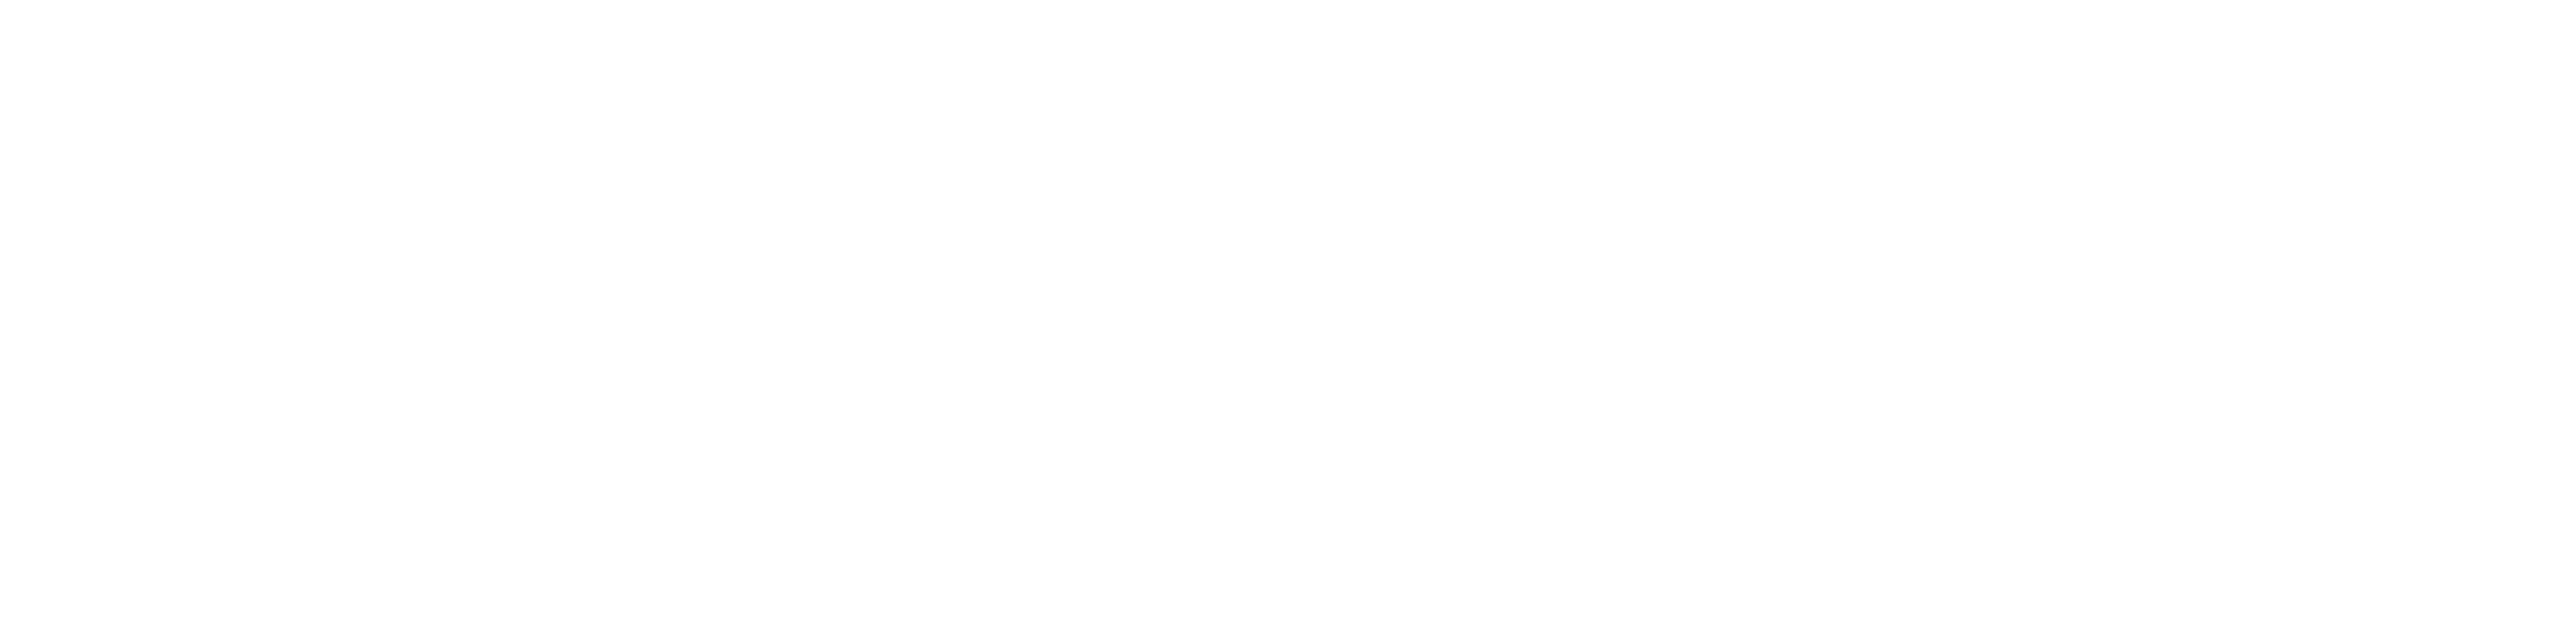

2020-06-12 16:03:06,949 logger INFO loss 1.630869, headKpFixingLoss 0.1387, MemUsed:125.41
2020-06-12 16:03:13,646 logger INFO loss 1.629942, headKpFixingLoss 0.1386, MemUsed:125.41
2020-06-12 16:03:20,389 logger INFO loss 1.629640, headKpFixingLoss 0.1388, MemUsed:125.41
2020-06-12 16:03:26,831 logger INFO loss 1.626439, headKpFixingLoss 0.1399, MemUsed:125.41
2020-06-12 16:03:33,389 logger INFO loss 1.626251, headKpFixingLoss 0.1408, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


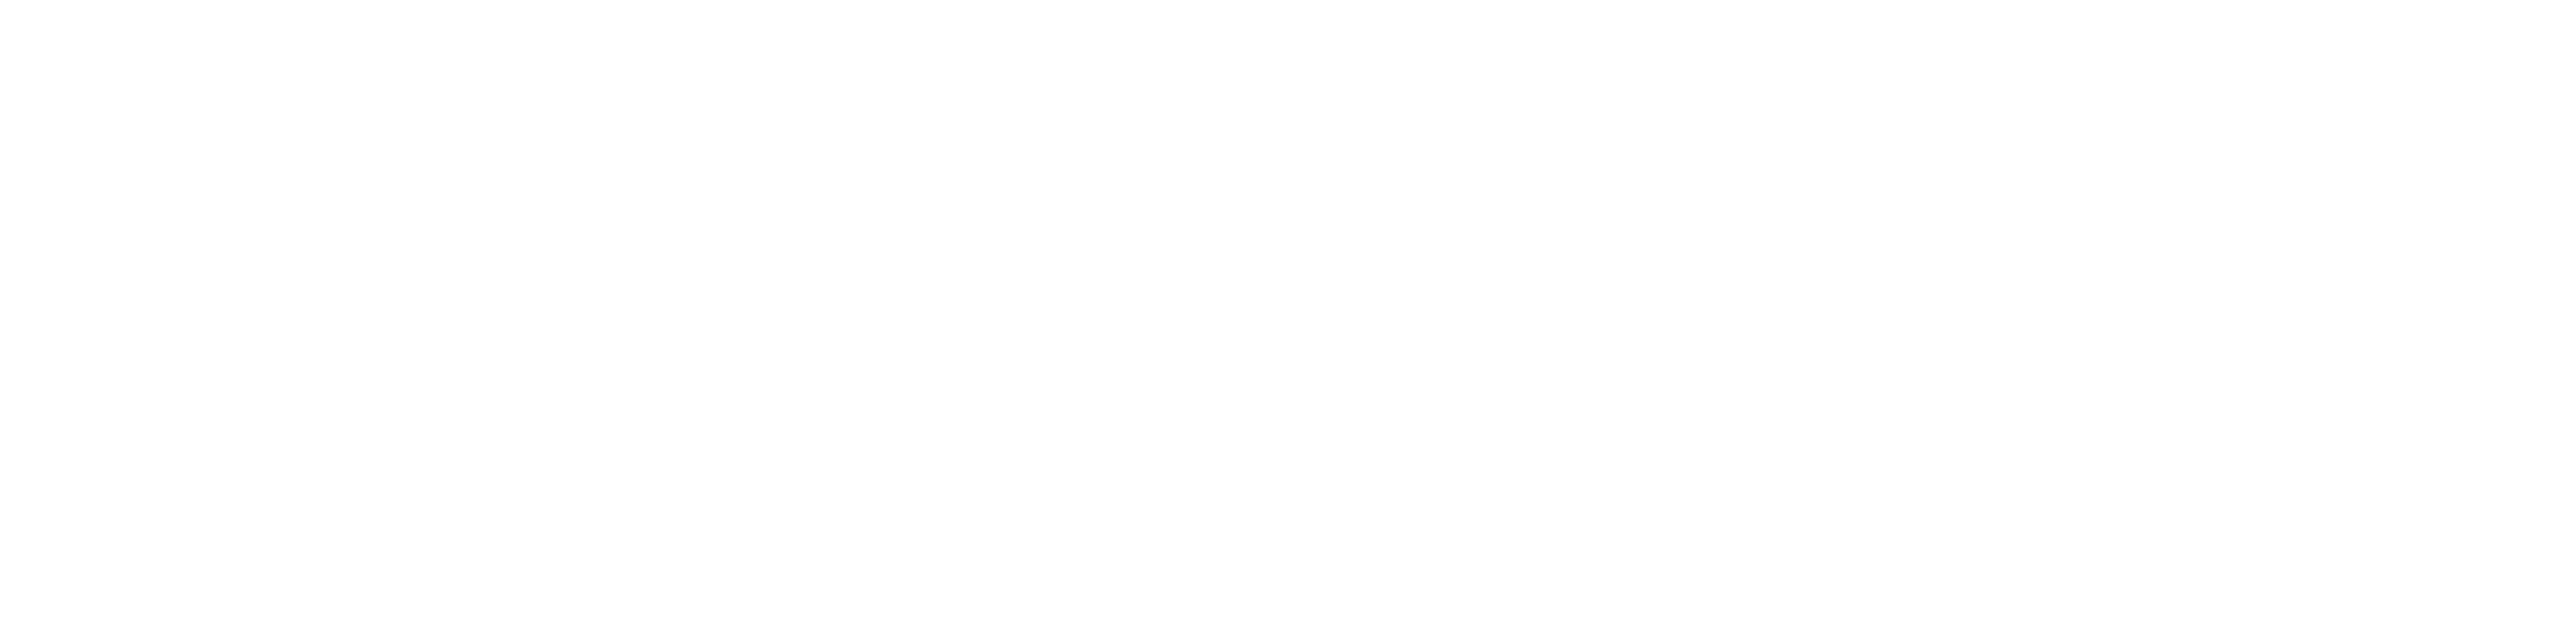

2020-06-12 16:03:56,941 logger INFO loss 1.625094, headKpFixingLoss 0.1400, MemUsed:125.41
2020-06-12 16:04:03,292 logger INFO loss 1.624683, headKpFixingLoss 0.1400, MemUsed:125.41
2020-06-12 16:04:09,663 logger INFO loss 1.621424, headKpFixingLoss 0.1421, MemUsed:125.41
2020-06-12 16:04:16,024 logger INFO loss 1.620121, headKpFixingLoss 0.1437, MemUsed:125.41
2020-06-12 16:04:22,409 logger INFO loss 1.619486, headKpFixingLoss 0.1426, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


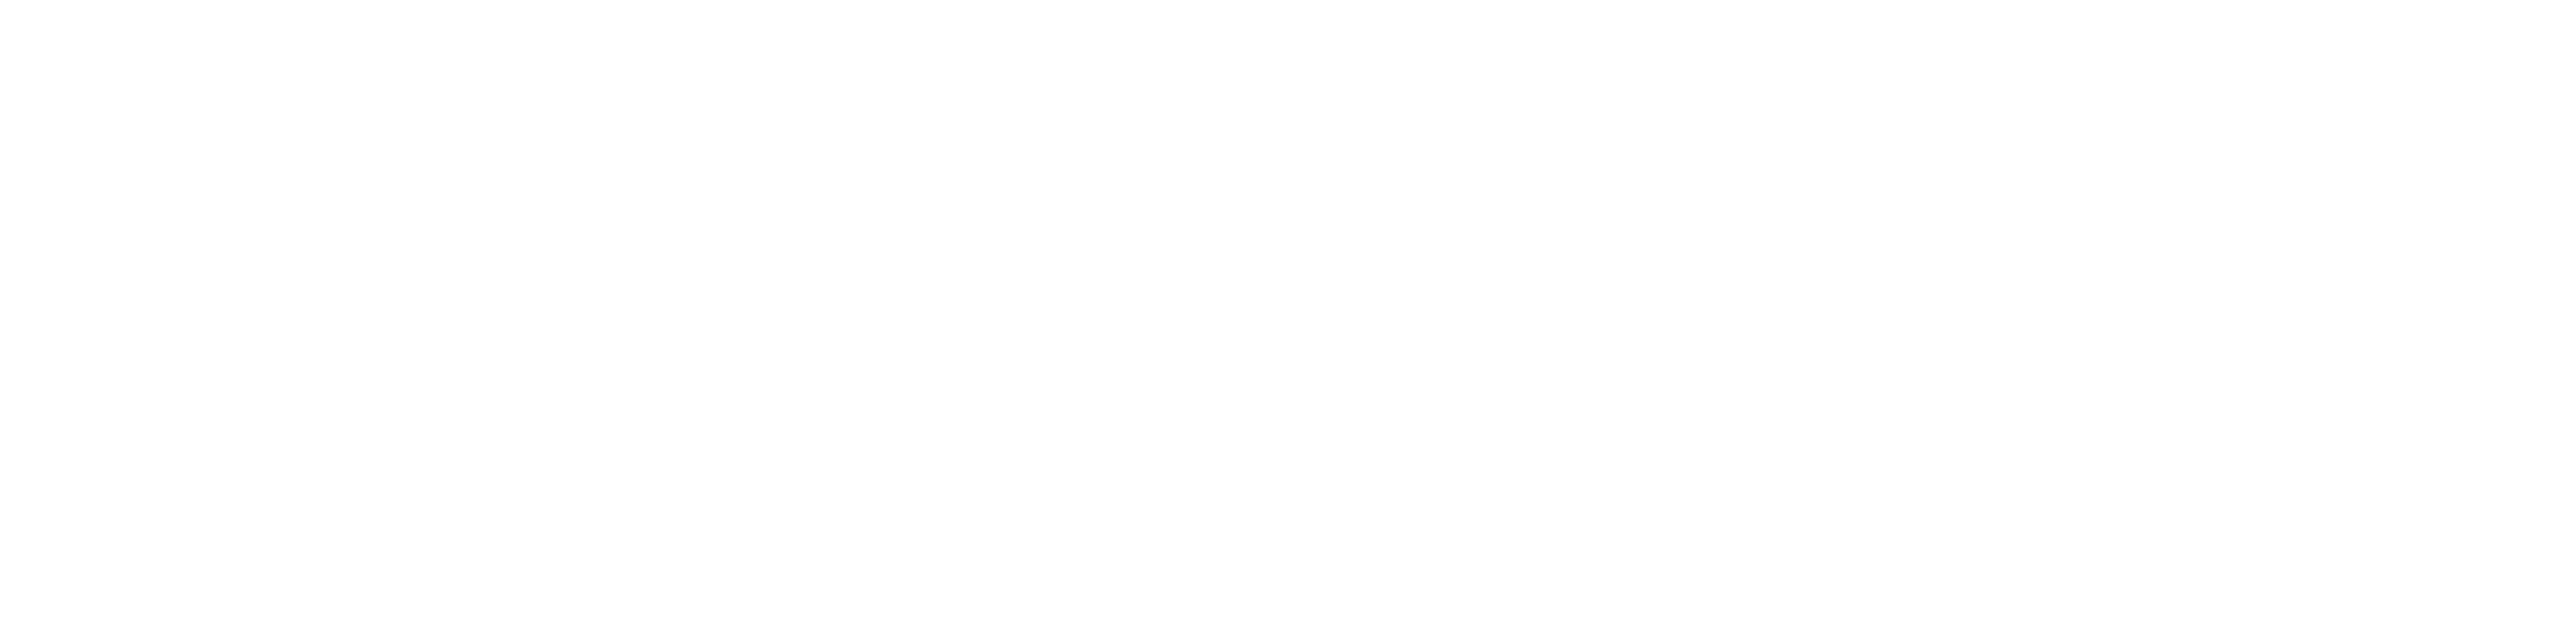

2020-06-12 16:04:45,720 logger INFO loss 1.618989, headKpFixingLoss 0.1426, MemUsed:125.41
2020-06-12 16:04:52,056 logger INFO loss 1.617903, headKpFixingLoss 0.1436, MemUsed:125.41
2020-06-12 16:04:58,396 logger INFO loss 1.618082, headKpFixingLoss 0.1439, MemUsed:125.41
2020-06-12 16:05:04,779 logger INFO loss 1.616720, headKpFixingLoss 0.1431, MemUsed:125.41
2020-06-12 16:05:11,156 logger INFO loss 1.619277, headKpFixingLoss 0.1423, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


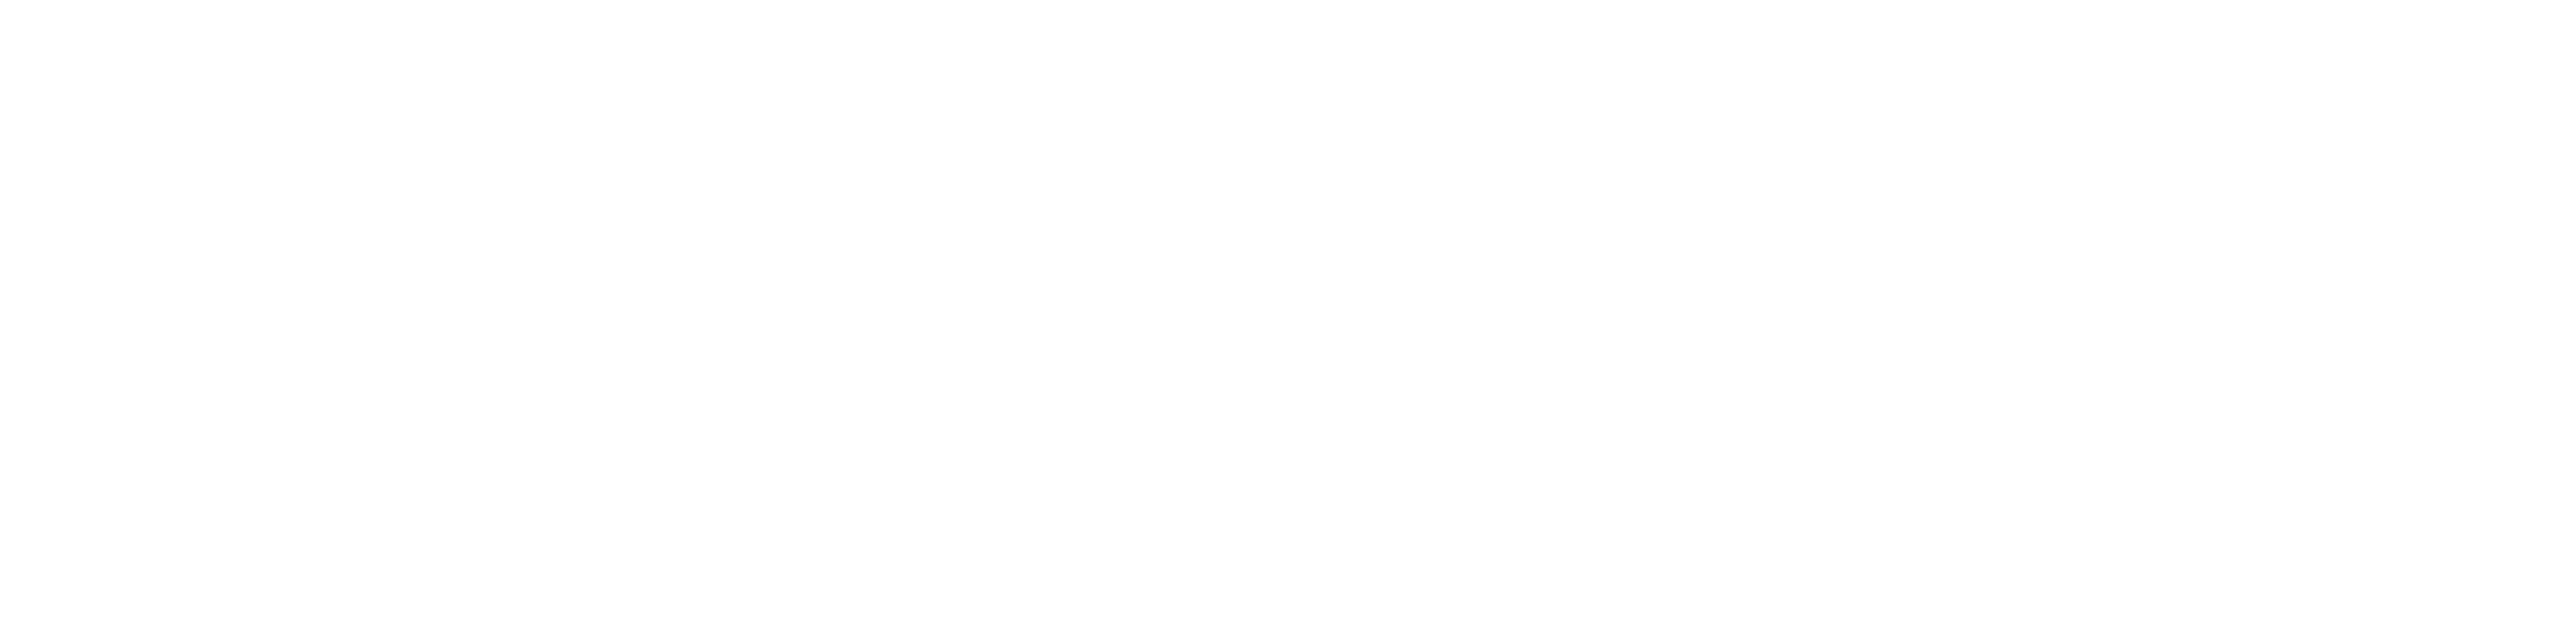

2020-06-12 16:05:34,749 logger INFO loss 1.616512, headKpFixingLoss 0.1431, MemUsed:125.41
2020-06-12 16:05:41,090 logger INFO loss 1.614861, headKpFixingLoss 0.1448, MemUsed:125.41
2020-06-12 16:05:47,427 logger INFO loss 1.613604, headKpFixingLoss 0.1443, MemUsed:125.41
2020-06-12 16:05:53,791 logger INFO loss 1.616182, headKpFixingLoss 0.1423, MemUsed:125.41
2020-06-12 16:06:00,172 logger INFO loss 1.613812, headKpFixingLoss 0.1423, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


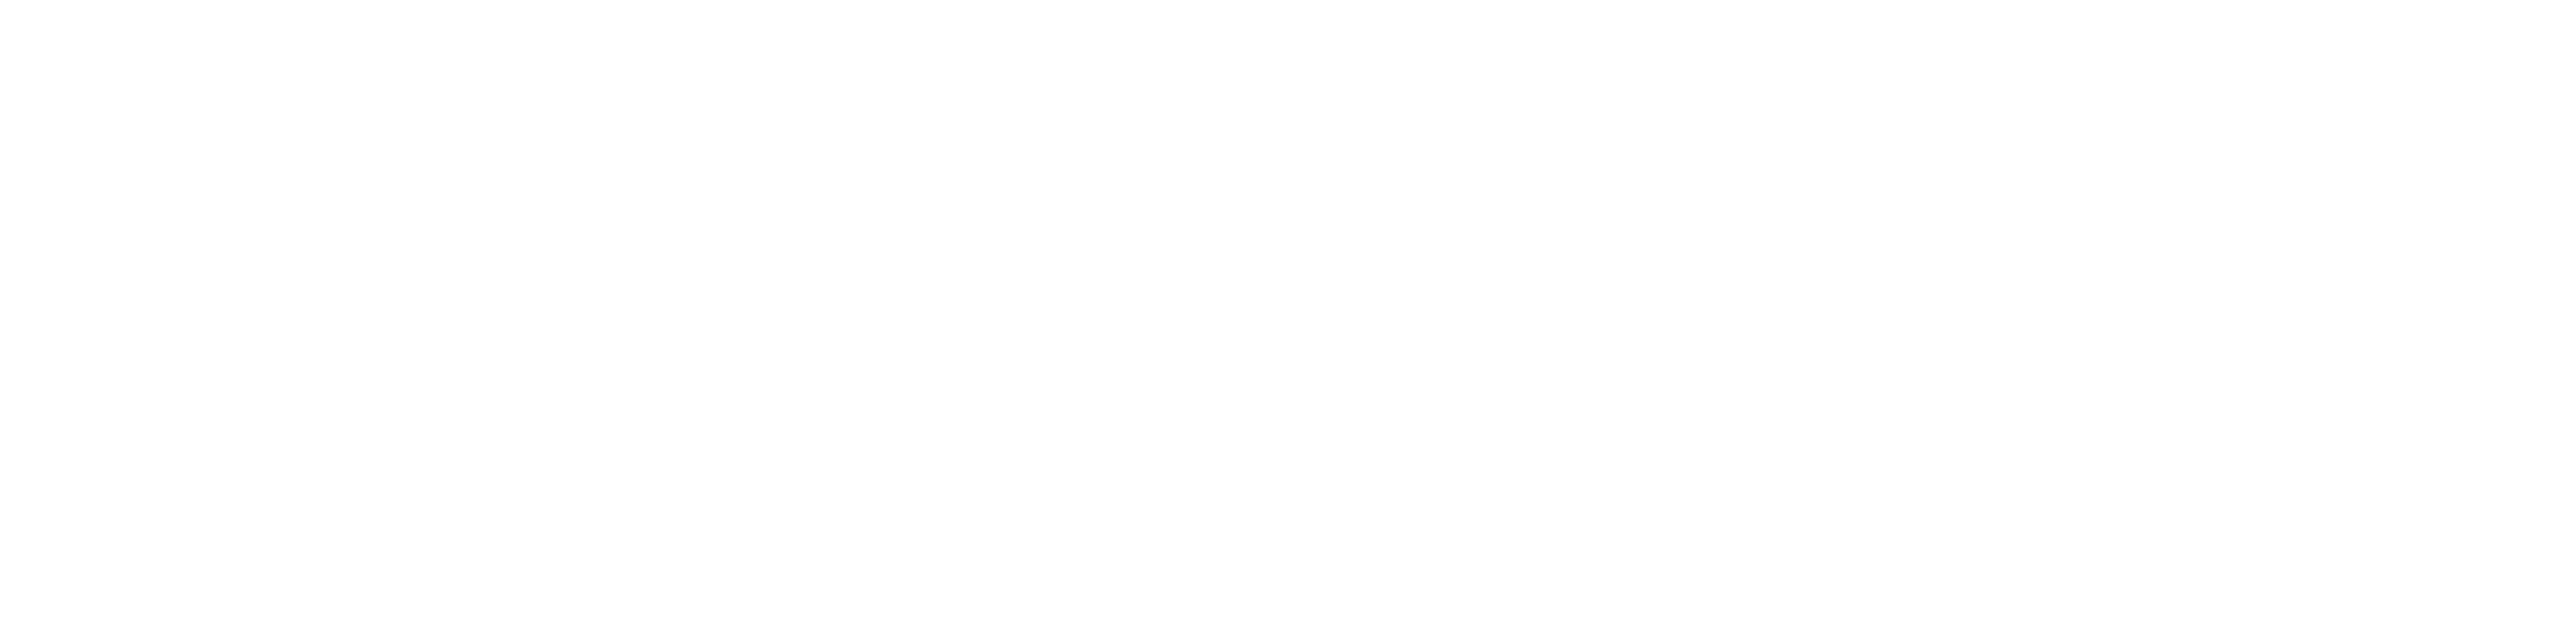

2020-06-12 16:06:23,693 logger INFO loss 1.612897, headKpFixingLoss 0.1444, MemUsed:125.41
2020-06-12 16:06:30,027 logger INFO loss 1.611553, headKpFixingLoss 0.1467, MemUsed:125.41
2020-06-12 16:06:36,394 logger INFO loss 1.610924, headKpFixingLoss 0.1468, MemUsed:125.41
2020-06-12 16:06:42,747 logger INFO loss 1.612873, headKpFixingLoss 0.1464, MemUsed:125.41
2020-06-12 16:06:49,111 logger INFO loss 1.609419, headKpFixingLoss 0.1468, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


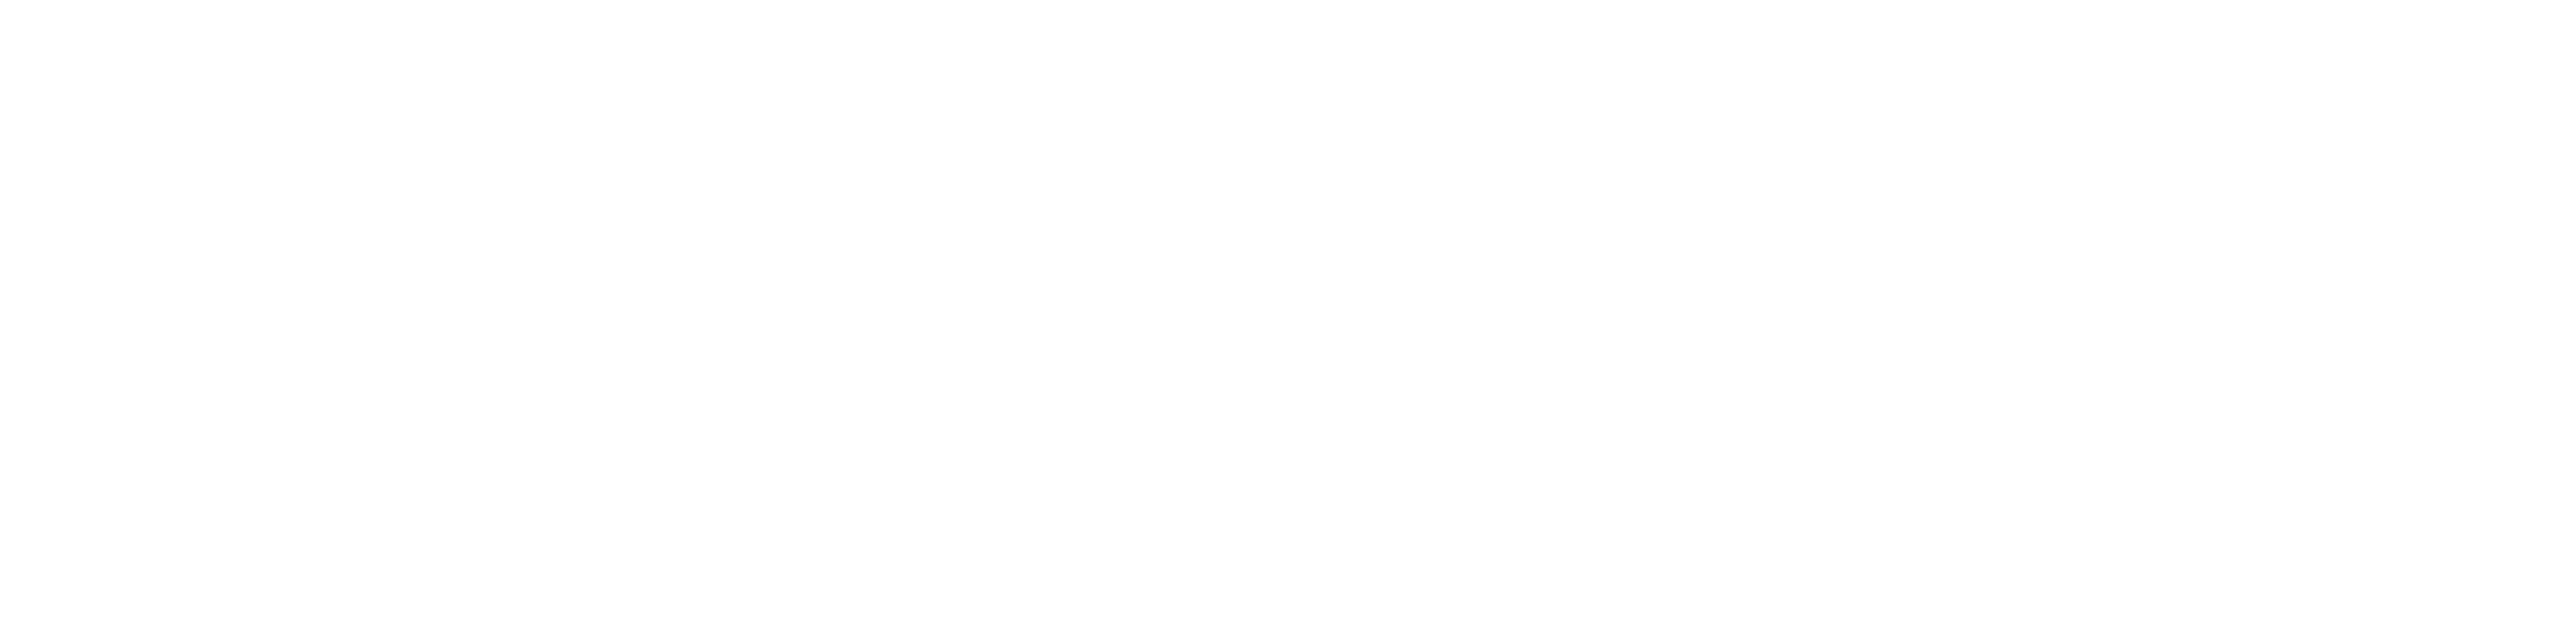

2020-06-12 16:07:12,473 logger INFO loss 1.609524, headKpFixingLoss 0.1470, MemUsed:125.41
2020-06-12 16:07:18,804 logger INFO loss 1.608848, headKpFixingLoss 0.1446, MemUsed:125.41
2020-06-12 16:07:25,166 logger INFO loss 1.611210, headKpFixingLoss 0.1438, MemUsed:125.41
2020-06-12 16:07:31,540 logger INFO loss 1.608197, headKpFixingLoss 0.1453, MemUsed:125.41
2020-06-12 16:07:37,889 logger INFO loss 1.606504, headKpFixingLoss 0.1475, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


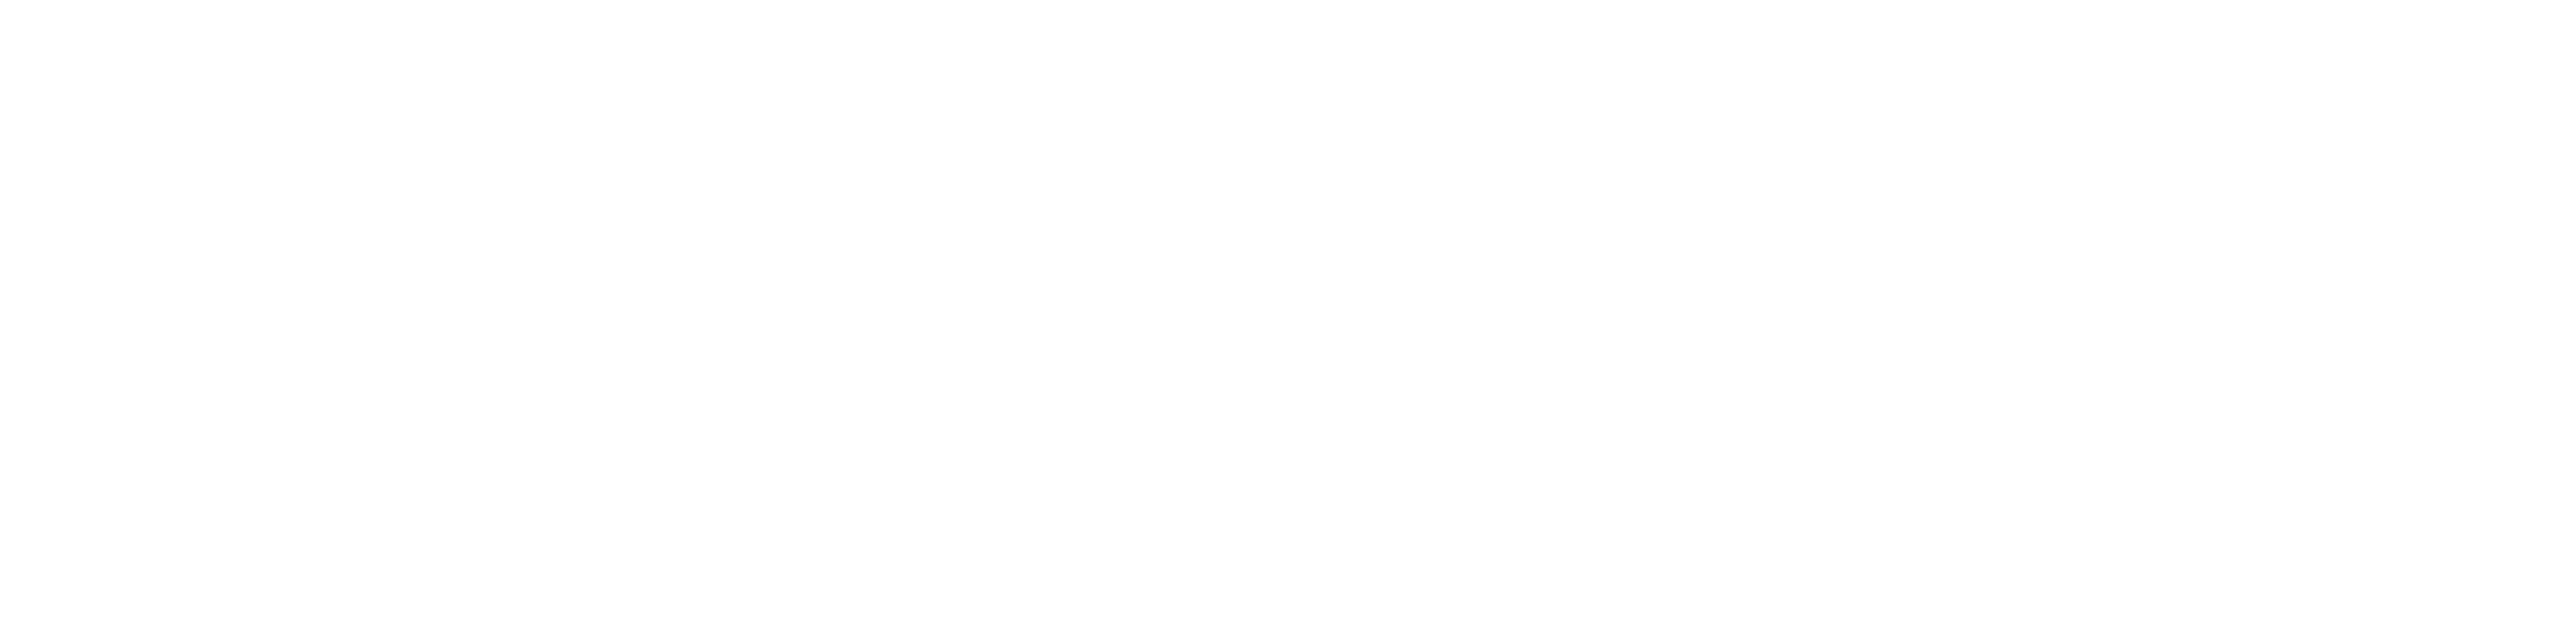

2020-06-12 16:08:01,615 logger INFO loss 1.605900, headKpFixingLoss 0.1467, MemUsed:125.41
2020-06-12 16:08:08,260 logger INFO loss 1.607597, headKpFixingLoss 0.1433, MemUsed:125.41
2020-06-12 16:08:14,637 logger INFO loss 1.606835, headKpFixingLoss 0.1429, MemUsed:125.41
2020-06-12 16:08:21,007 logger INFO loss 1.605785, headKpFixingLoss 0.1455, MemUsed:125.41
2020-06-12 16:08:27,452 logger INFO loss 1.602487, headKpFixingLoss 0.1480, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


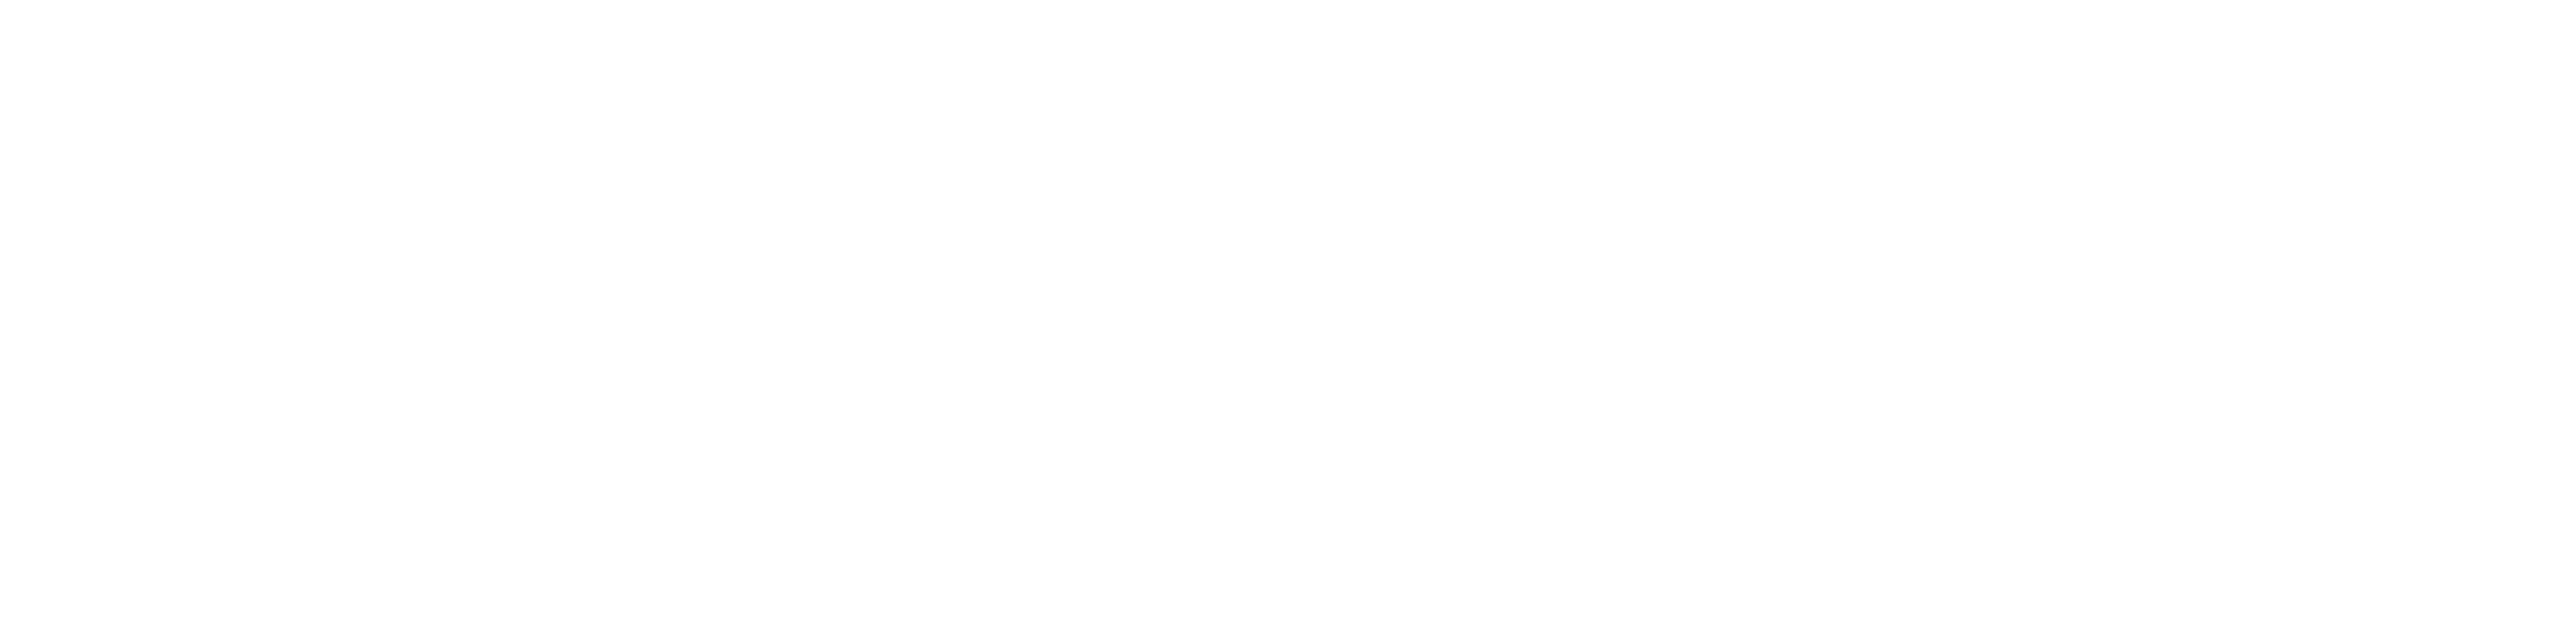

2020-06-12 16:08:51,021 logger INFO loss 1.601870, headKpFixingLoss 0.1479, MemUsed:125.41
2020-06-12 16:08:57,440 logger INFO loss 1.600797, headKpFixingLoss 0.1475, MemUsed:125.41
2020-06-12 16:09:04,129 logger INFO loss 1.600322, headKpFixingLoss 0.1474, MemUsed:125.41
2020-06-12 16:09:10,837 logger INFO loss 1.602395, headKpFixingLoss 0.1467, MemUsed:125.41
2020-06-12 16:09:17,545 logger INFO loss 1.601755, headKpFixingLoss 0.1457, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


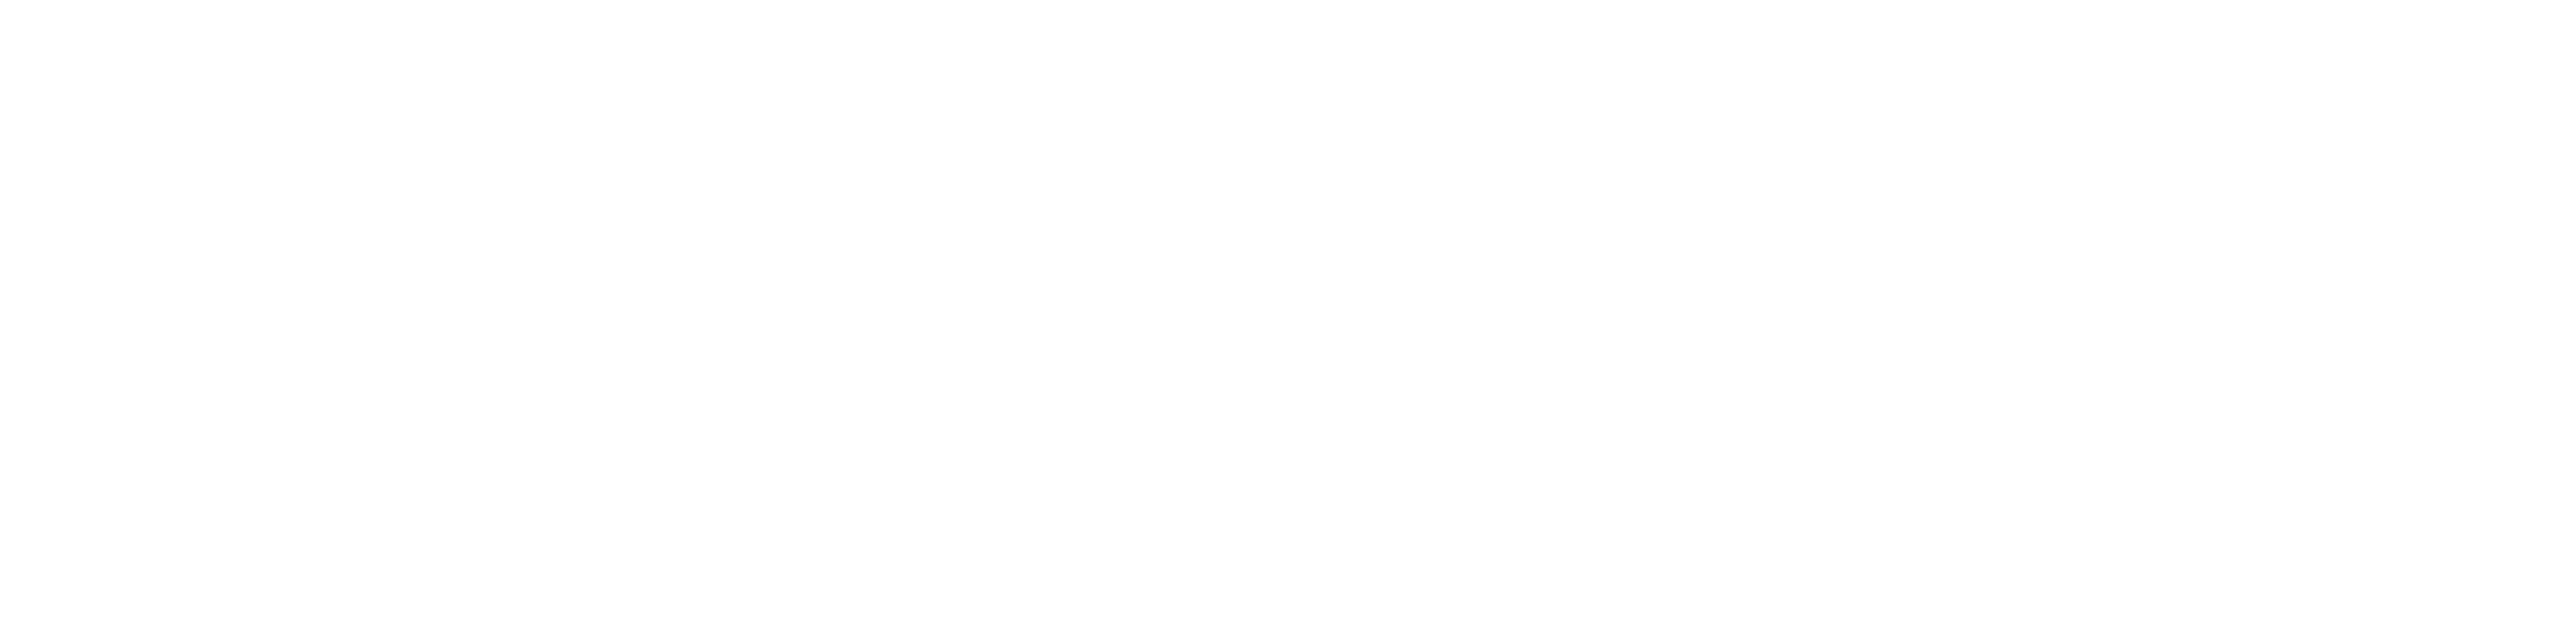

2020-06-12 16:09:42,022 logger INFO loss 1.600945, headKpFixingLoss 0.1463, MemUsed:125.41
2020-06-12 16:09:48,717 logger INFO loss 1.597529, headKpFixingLoss 0.1484, MemUsed:125.41
2020-06-12 16:09:55,225 logger INFO loss 1.596943, headKpFixingLoss 0.1509, MemUsed:125.41
2020-06-12 16:10:01,744 logger INFO loss 1.594967, headKpFixingLoss 0.1506, MemUsed:125.41
2020-06-12 16:10:08,392 logger INFO loss 1.595510, headKpFixingLoss 0.1497, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


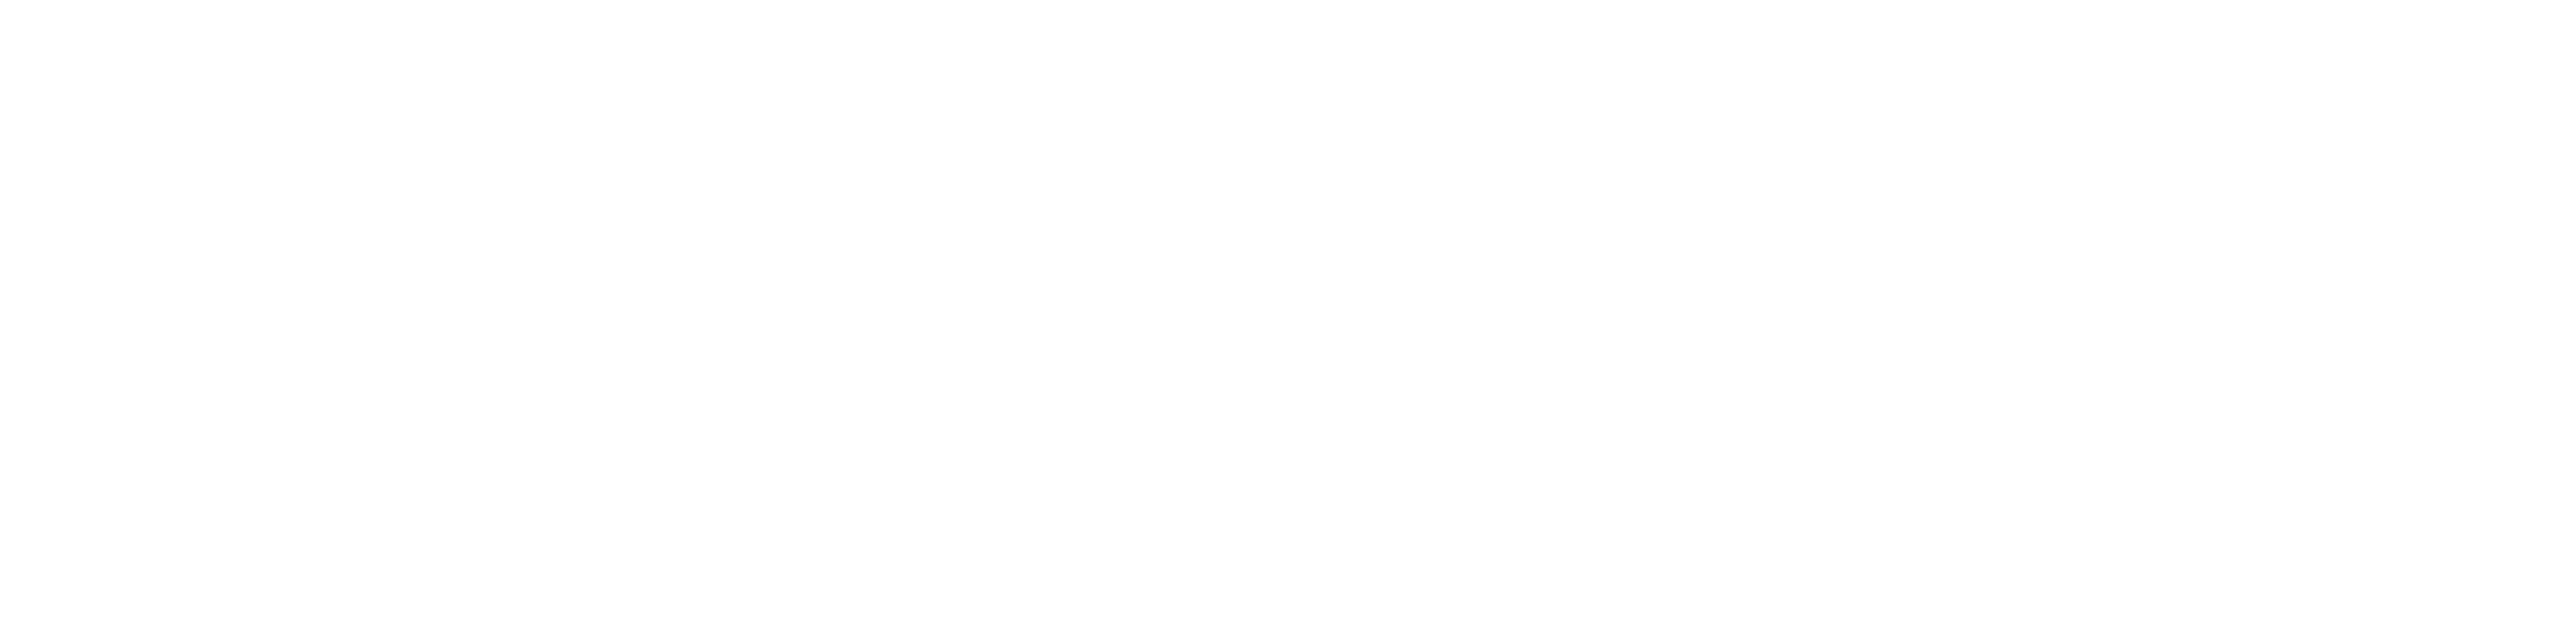

2020-06-12 16:10:32,188 logger INFO loss 1.595266, headKpFixingLoss 0.1497, MemUsed:125.41
2020-06-12 16:10:38,746 logger INFO loss 1.593449, headKpFixingLoss 0.1508, MemUsed:125.41
2020-06-12 16:10:45,267 logger INFO loss 1.590454, headKpFixingLoss 0.1531, MemUsed:125.41
2020-06-12 16:10:51,782 logger INFO loss 1.590342, headKpFixingLoss 0.1544, MemUsed:125.41
2020-06-12 16:10:58,422 logger INFO loss 1.590309, headKpFixingLoss 0.1527, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


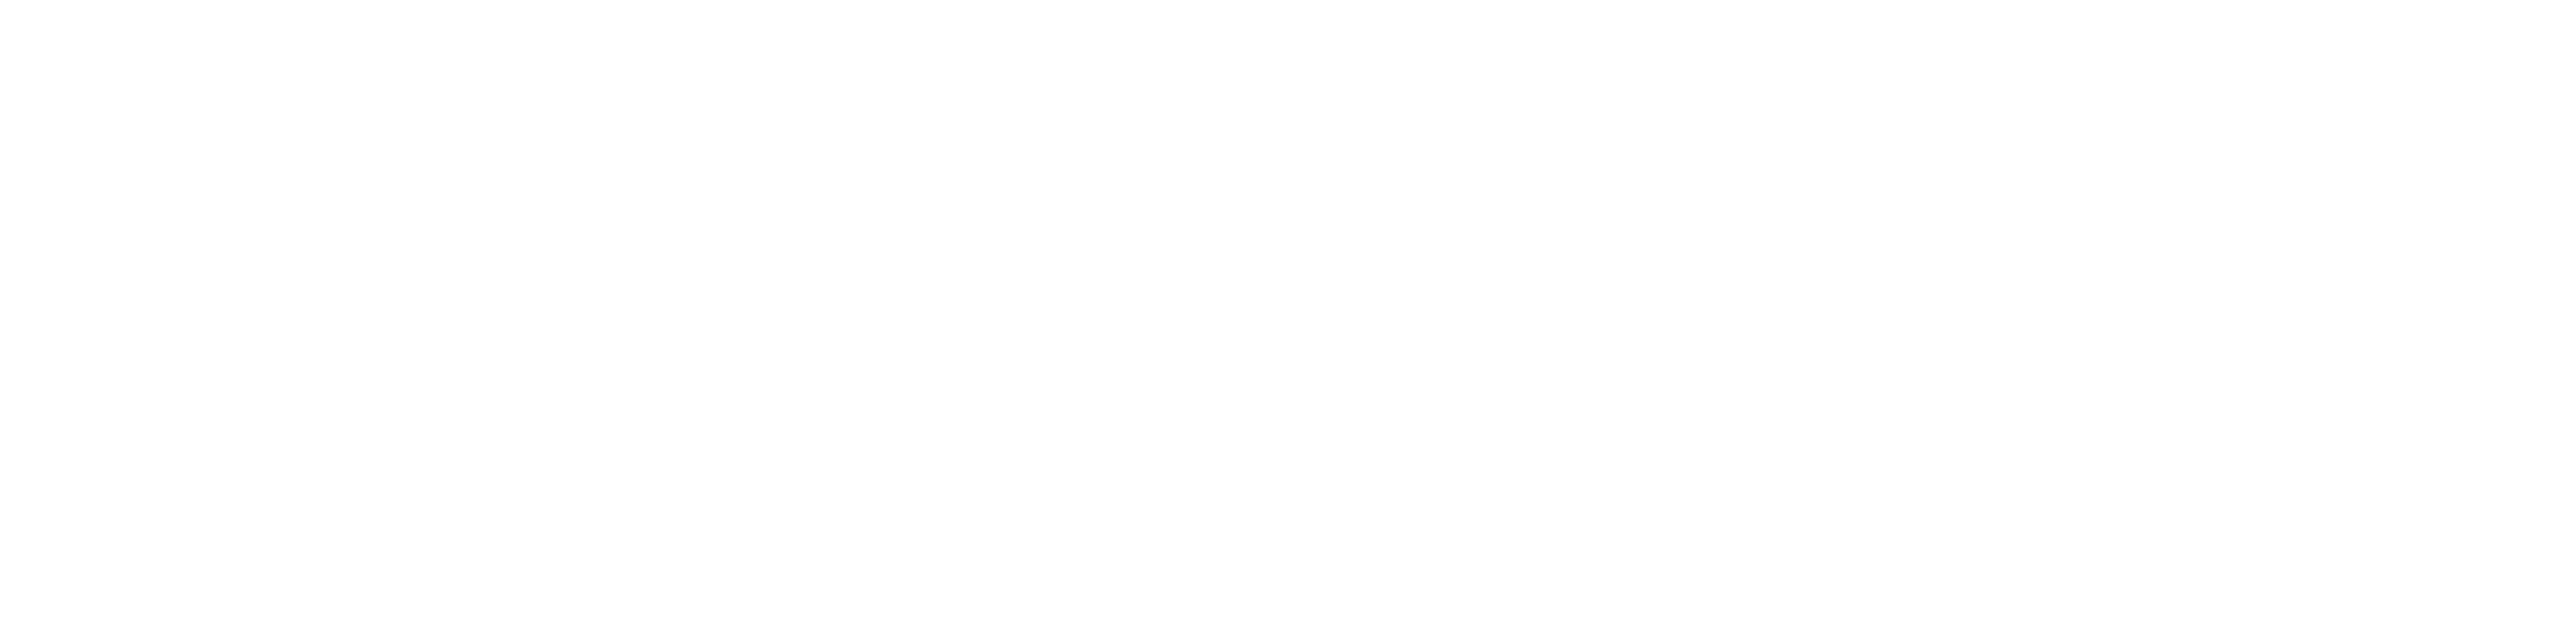

2020-06-12 16:11:22,128 logger INFO loss 1.590141, headKpFixingLoss 0.1512, MemUsed:125.41
2020-06-12 16:11:28,591 logger INFO loss 1.592074, headKpFixingLoss 0.1507, MemUsed:125.41
2020-06-12 16:11:35,073 logger INFO loss 1.589986, headKpFixingLoss 0.1511, MemUsed:125.41
2020-06-12 16:11:41,554 logger INFO loss 1.589504, headKpFixingLoss 0.1521, MemUsed:125.41
2020-06-12 16:11:48,114 logger INFO loss 1.589089, headKpFixingLoss 0.1538, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


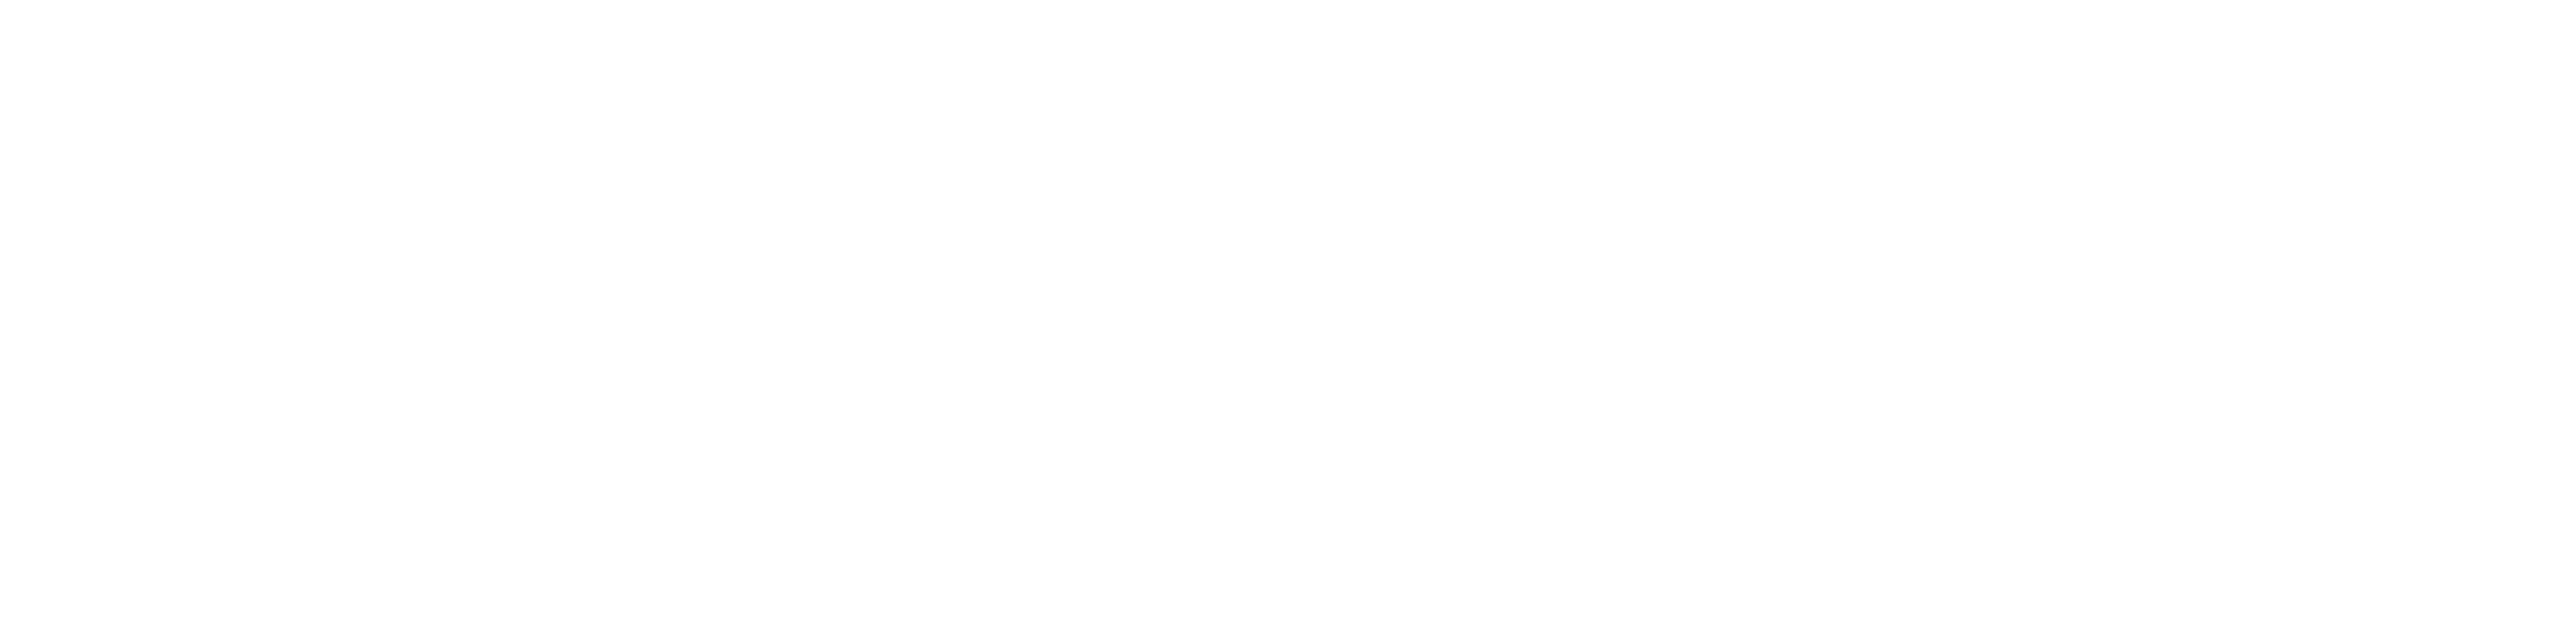

2020-06-12 16:12:12,070 logger INFO loss 1.588225, headKpFixingLoss 0.1543, MemUsed:125.41
2020-06-12 16:12:18,537 logger INFO loss 1.588961, headKpFixingLoss 0.1526, MemUsed:125.41
2020-06-12 16:12:25,015 logger INFO loss 1.591934, headKpFixingLoss 0.1508, MemUsed:125.41
2020-06-12 16:12:31,508 logger INFO loss 1.589214, headKpFixingLoss 0.1524, MemUsed:125.41
2020-06-12 16:12:38,117 logger INFO loss 1.586096, headKpFixingLoss 0.1562, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


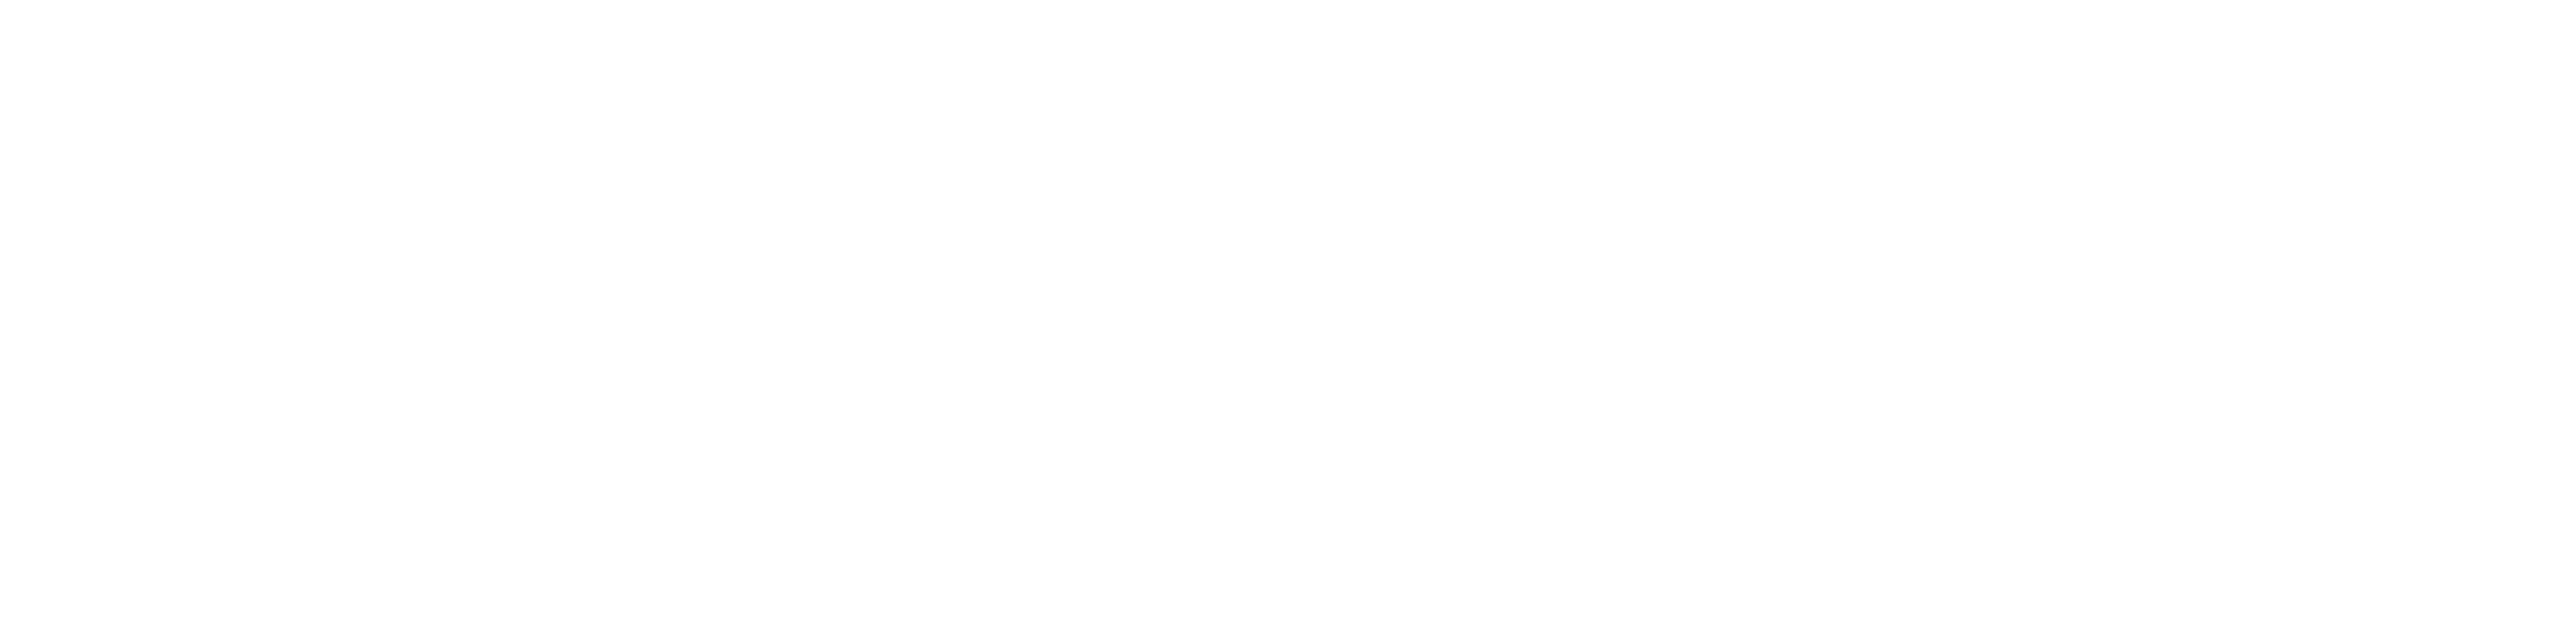

2020-06-12 16:13:01,937 logger INFO loss 1.583850, headKpFixingLoss 0.1573, MemUsed:125.41
2020-06-12 16:13:08,431 logger INFO loss 1.584952, headKpFixingLoss 0.1565, MemUsed:125.41
2020-06-12 16:13:14,903 logger INFO loss 1.584505, headKpFixingLoss 0.1570, MemUsed:125.41
2020-06-12 16:13:21,411 logger INFO loss 1.582645, headKpFixingLoss 0.1572, MemUsed:125.41
2020-06-12 16:13:27,911 logger INFO loss 1.585040, headKpFixingLoss 0.1564, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


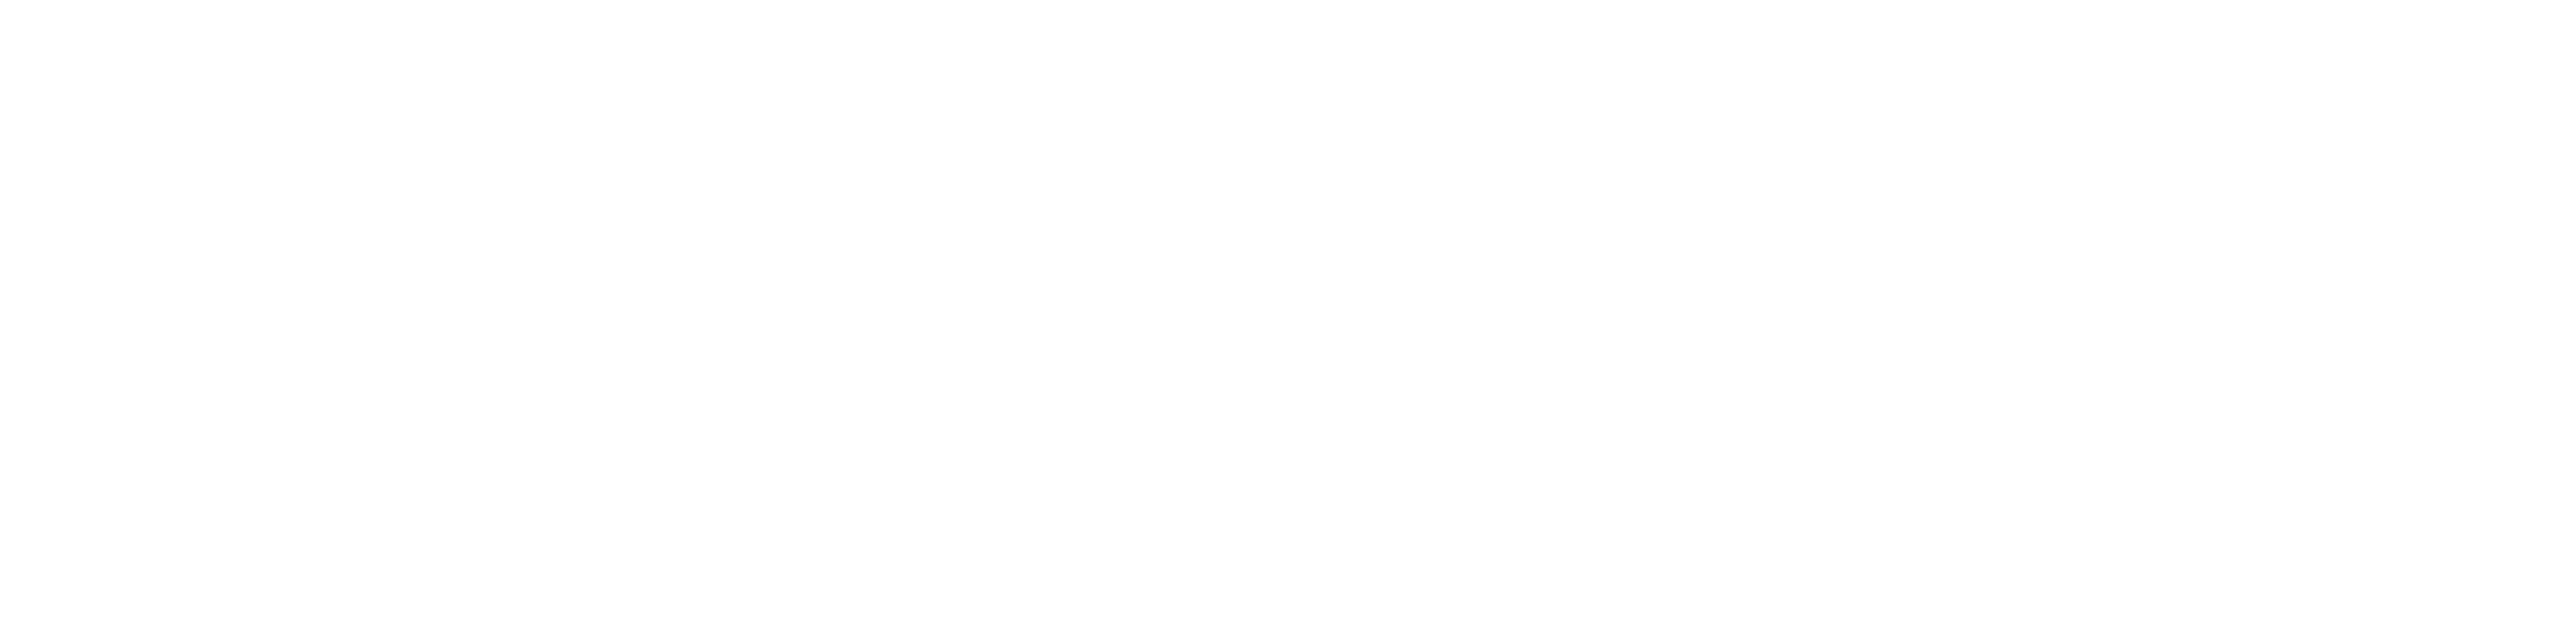

2020-06-12 16:13:51,673 logger INFO loss 1.581116, headKpFixingLoss 0.1555, MemUsed:125.41
2020-06-12 16:13:58,148 logger INFO loss 1.583358, headKpFixingLoss 0.1552, MemUsed:125.41
2020-06-12 16:14:04,646 logger INFO loss 1.584870, headKpFixingLoss 0.1552, MemUsed:125.41
2020-06-12 16:14:11,118 logger INFO loss 1.583482, headKpFixingLoss 0.1559, MemUsed:125.41
2020-06-12 16:14:17,645 logger INFO loss 1.585996, headKpFixingLoss 0.1543, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


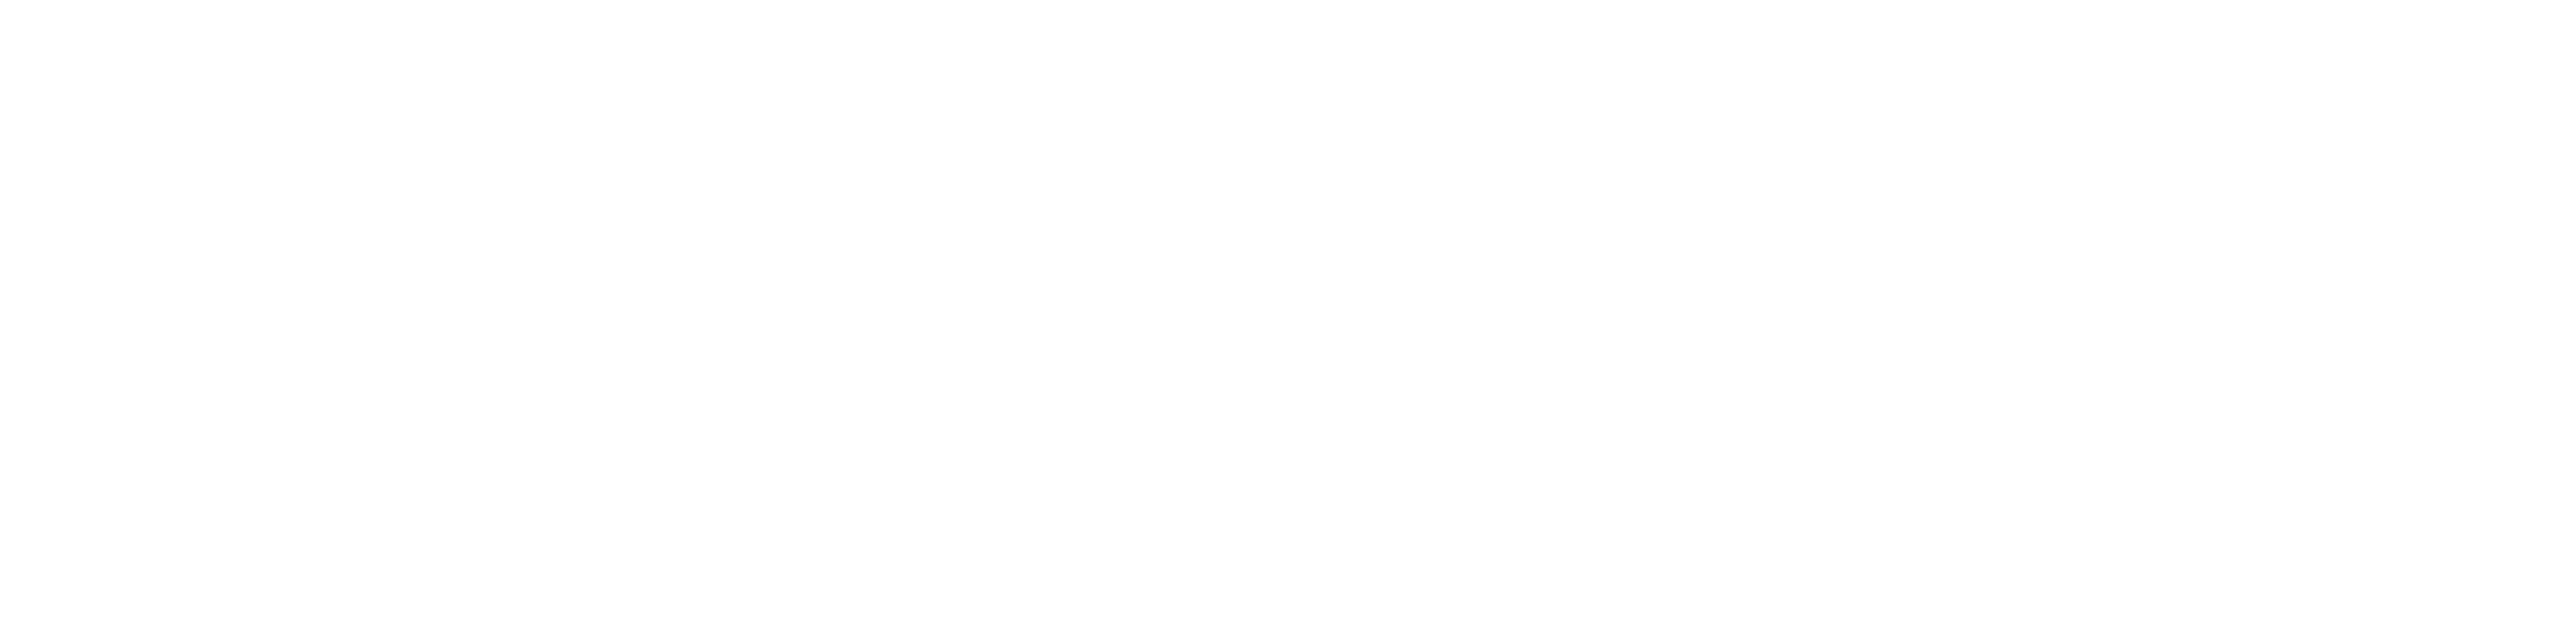

2020-06-12 16:14:41,766 logger INFO loss 1.584346, headKpFixingLoss 0.1521, MemUsed:125.41
2020-06-12 16:14:48,229 logger INFO loss 1.585499, headKpFixingLoss 0.1525, MemUsed:125.41
2020-06-12 16:14:54,692 logger INFO loss 1.580697, headKpFixingLoss 0.1554, MemUsed:125.41
2020-06-12 16:15:01,198 logger INFO loss 1.581172, headKpFixingLoss 0.1565, MemUsed:125.41
2020-06-12 16:15:07,843 logger INFO loss 1.581404, headKpFixingLoss 0.1552, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


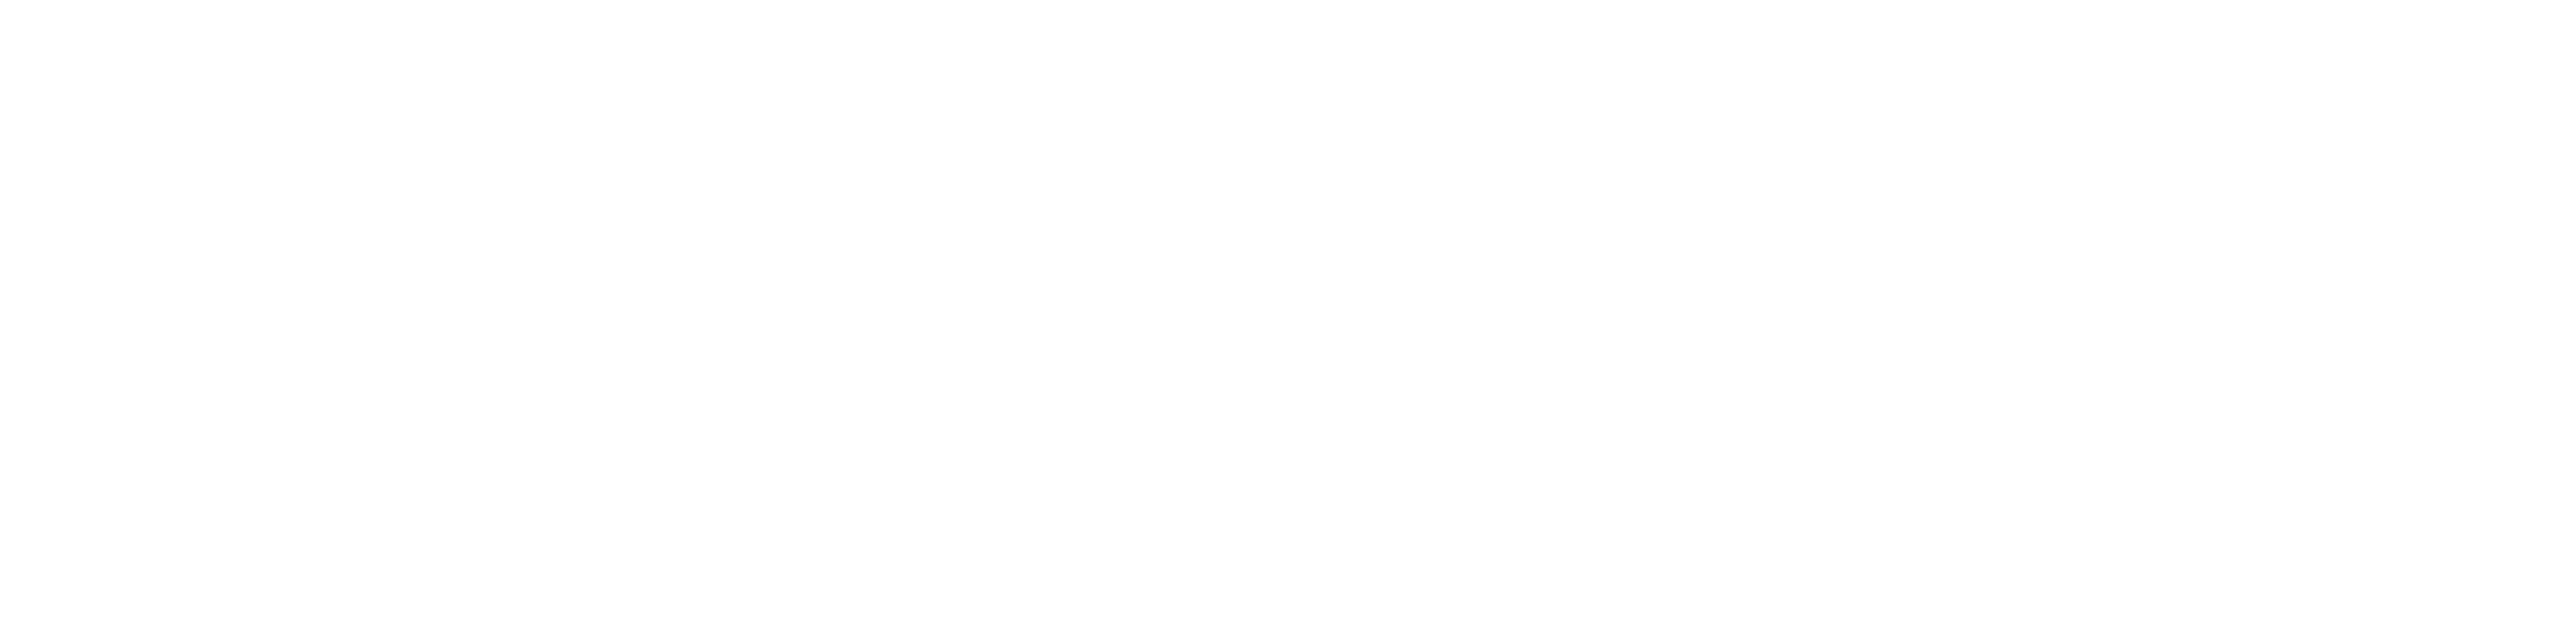

2020-06-12 16:15:31,800 logger INFO loss 1.581353, headKpFixingLoss 0.1549, MemUsed:125.41
2020-06-12 16:15:38,287 logger INFO loss 1.579910, headKpFixingLoss 0.1558, MemUsed:125.41
2020-06-12 16:15:44,790 logger INFO loss 1.581196, headKpFixingLoss 0.1561, MemUsed:125.41
2020-06-12 16:15:51,283 logger INFO loss 1.579821, headKpFixingLoss 0.1542, MemUsed:125.41
2020-06-12 16:15:57,797 logger INFO loss 1.582187, headKpFixingLoss 0.1541, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


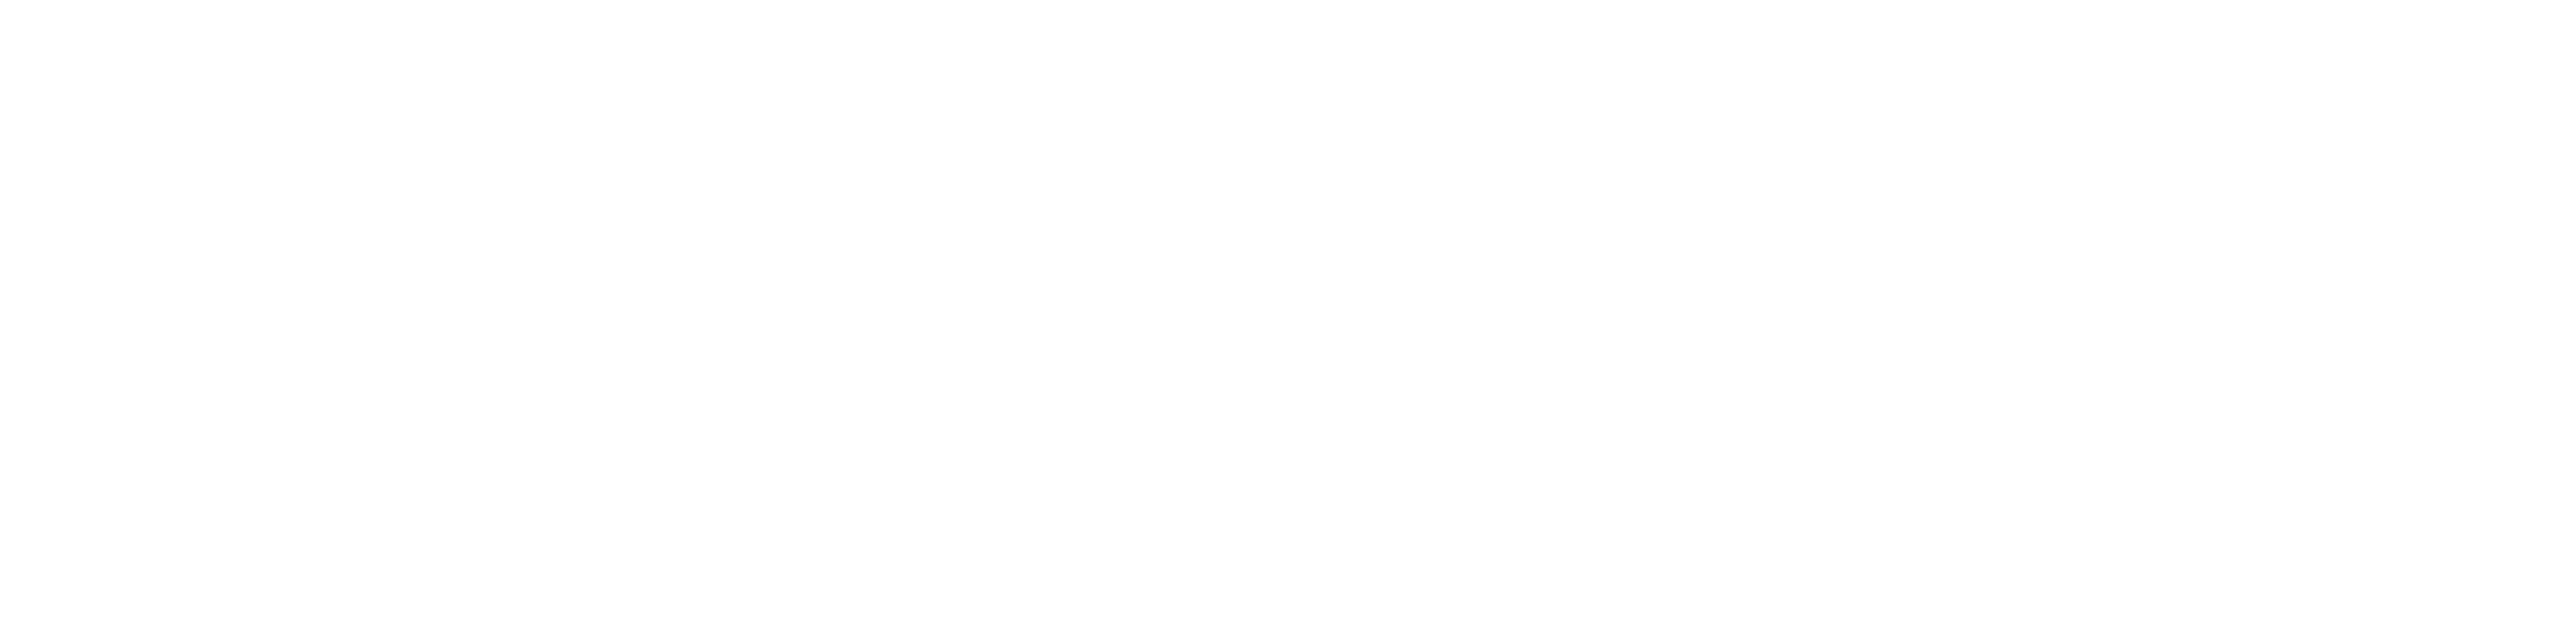

2020-06-12 16:16:21,822 logger INFO loss 1.576257, headKpFixingLoss 0.1571, MemUsed:125.41
2020-06-12 16:16:28,299 logger INFO loss 1.577671, headKpFixingLoss 0.1592, MemUsed:125.41
2020-06-12 16:16:34,794 logger INFO loss 1.575854, headKpFixingLoss 0.1575, MemUsed:125.41
2020-06-12 16:16:41,301 logger INFO loss 1.578938, headKpFixingLoss 0.1557, MemUsed:125.41
2020-06-12 16:16:47,813 logger INFO loss 1.575349, headKpFixingLoss 0.1563, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


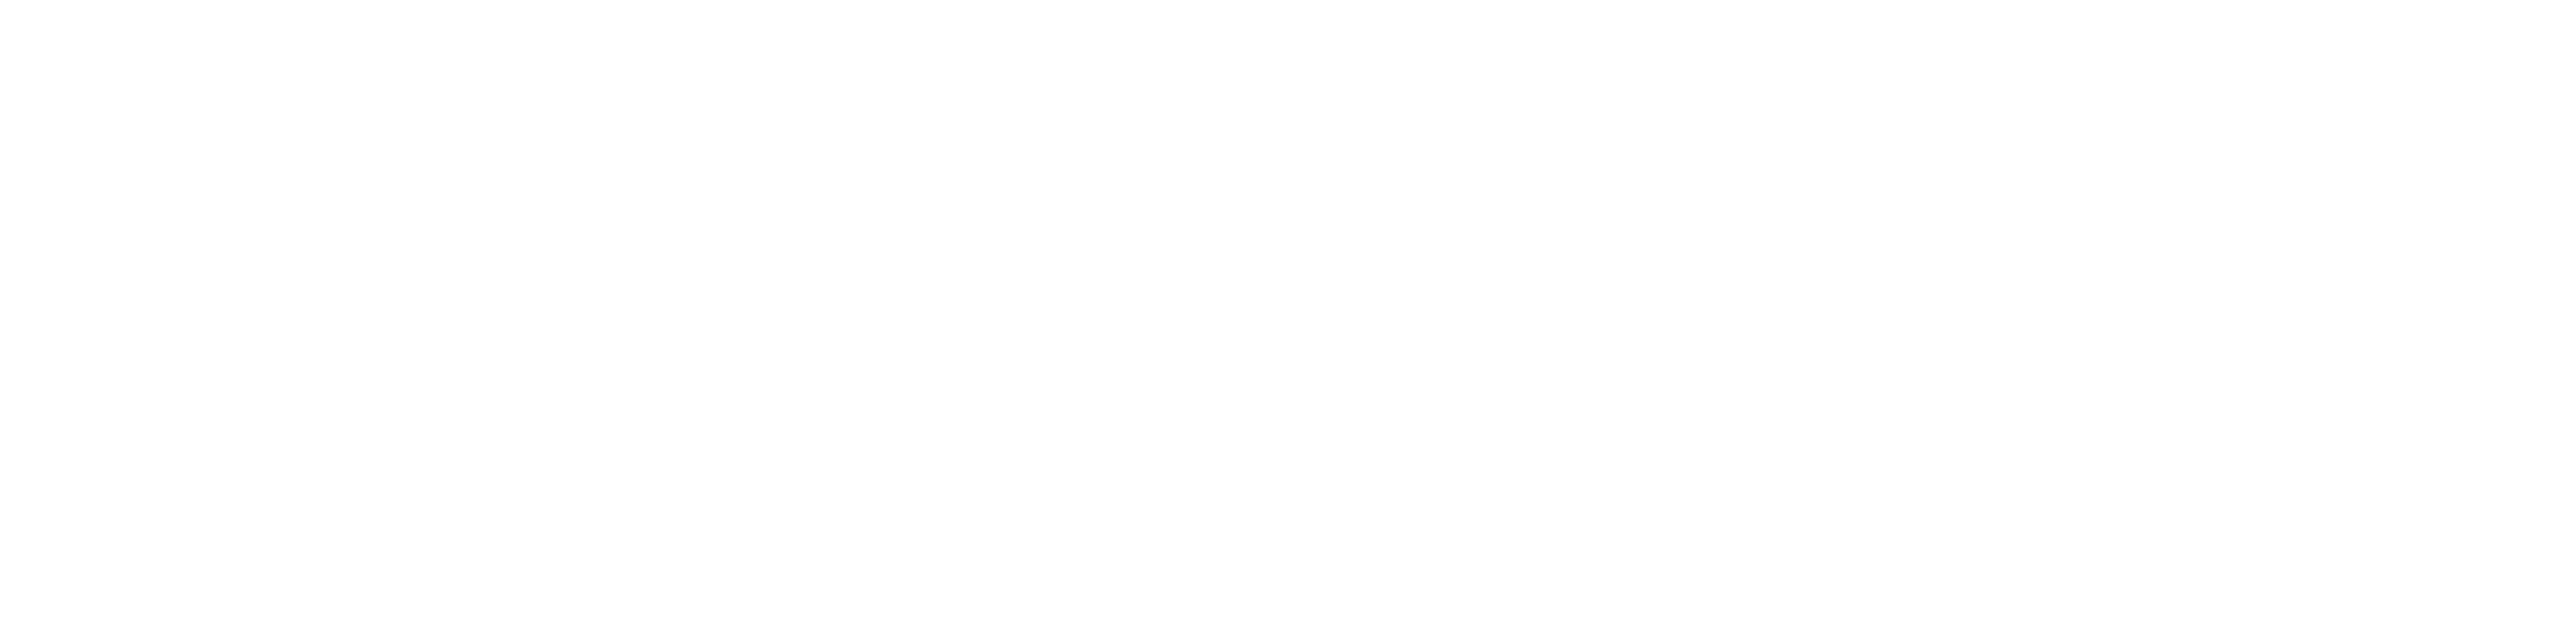

2020-06-12 16:17:11,781 logger INFO loss 1.576756, headKpFixingLoss 0.1587, MemUsed:125.41
2020-06-12 16:17:18,258 logger INFO loss 1.575595, headKpFixingLoss 0.1565, MemUsed:125.41
2020-06-12 16:17:24,744 logger INFO loss 1.577964, headKpFixingLoss 0.1549, MemUsed:125.41
2020-06-12 16:17:31,236 logger INFO loss 1.572241, headKpFixingLoss 0.1564, MemUsed:125.41
2020-06-12 16:17:37,752 logger INFO loss 1.574941, headKpFixingLoss 0.1585, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


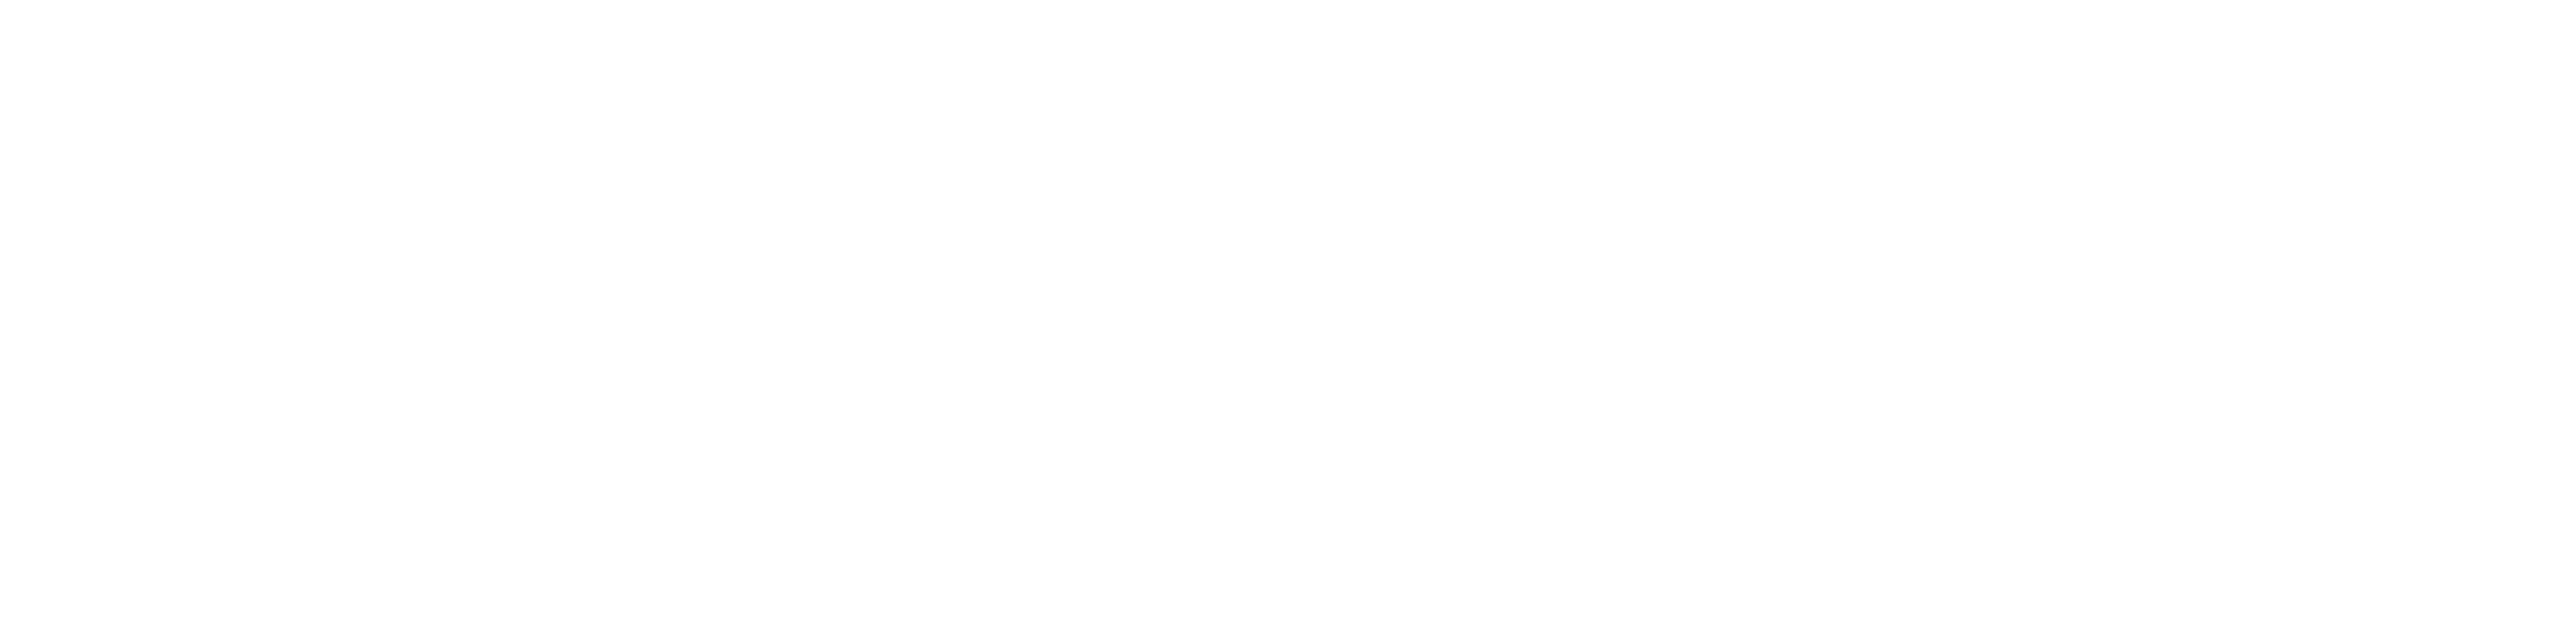

2020-06-12 16:18:01,748 logger INFO loss 1.571949, headKpFixingLoss 0.1569, MemUsed:125.41
2020-06-12 16:18:08,208 logger INFO loss 1.575062, headKpFixingLoss 0.1562, MemUsed:125.41
2020-06-12 16:18:14,726 logger INFO loss 1.571016, headKpFixingLoss 0.1579, MemUsed:125.41
2020-06-12 16:18:21,216 logger INFO loss 1.573838, headKpFixingLoss 0.1592, MemUsed:125.41
2020-06-12 16:18:27,722 logger INFO loss 1.572361, headKpFixingLoss 0.1578, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


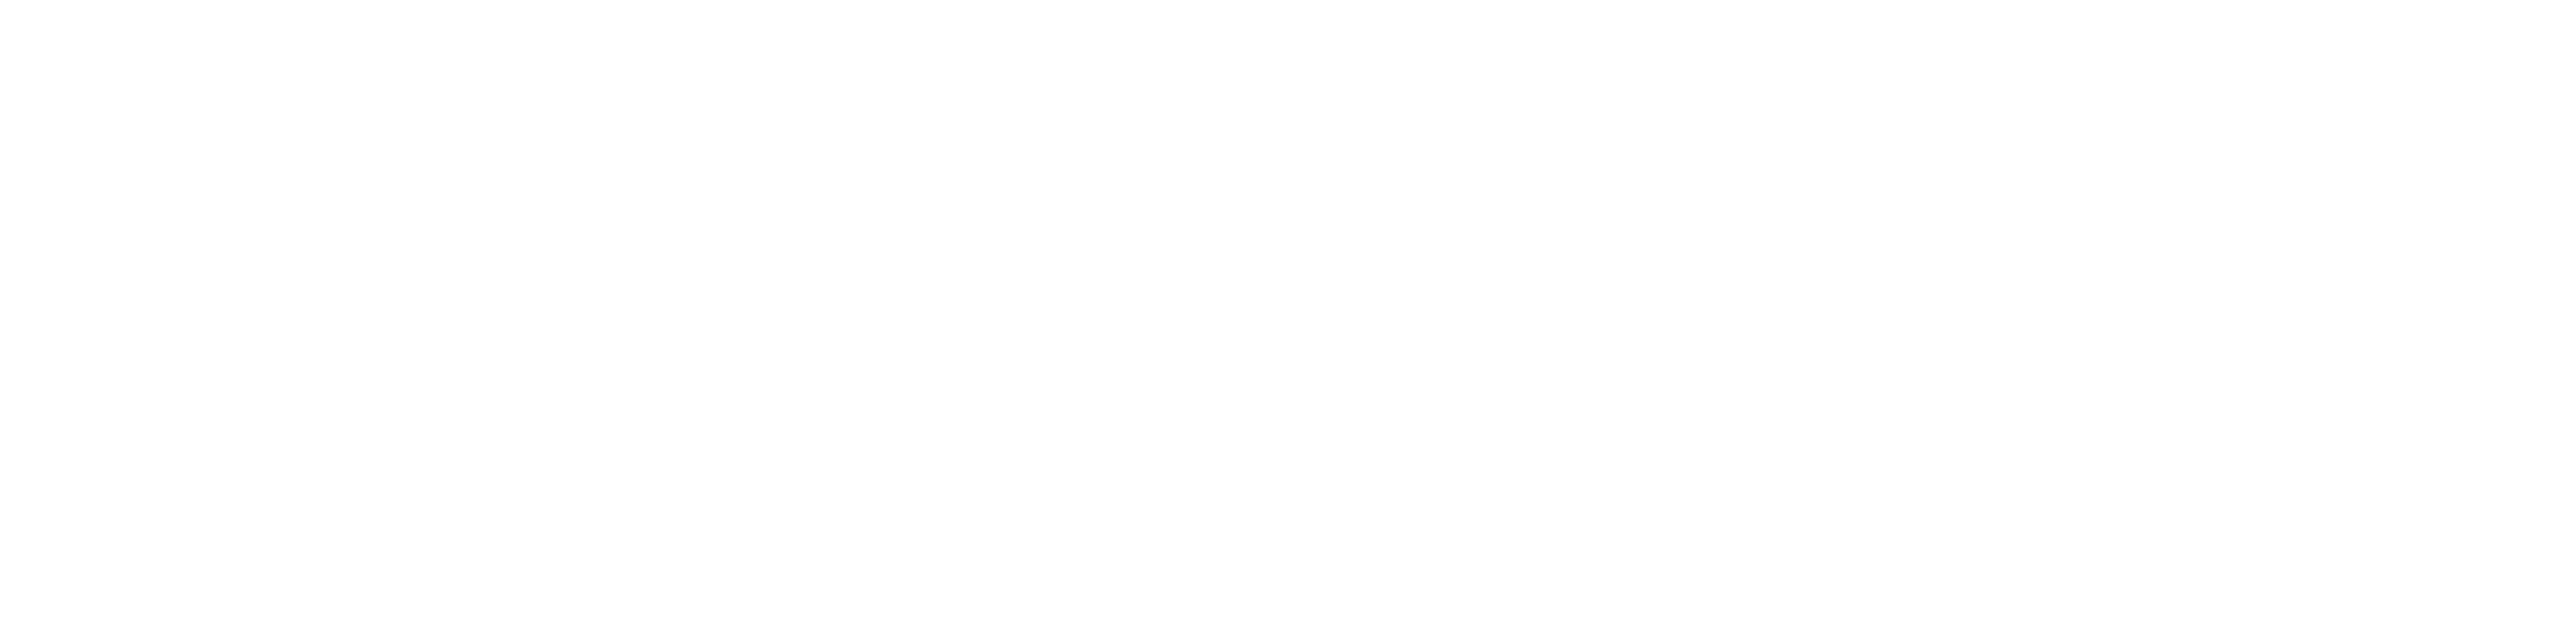

2020-06-12 16:18:51,792 logger INFO loss 1.573018, headKpFixingLoss 0.1574, MemUsed:125.41
2020-06-12 16:18:58,281 logger INFO loss 1.570751, headKpFixingLoss 0.1584, MemUsed:125.41
2020-06-12 16:19:04,769 logger INFO loss 1.570245, headKpFixingLoss 0.1578, MemUsed:125.41
2020-06-12 16:19:11,274 logger INFO loss 1.573130, headKpFixingLoss 0.1556, MemUsed:125.41
2020-06-12 16:19:17,882 logger INFO loss 1.570758, headKpFixingLoss 0.1566, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


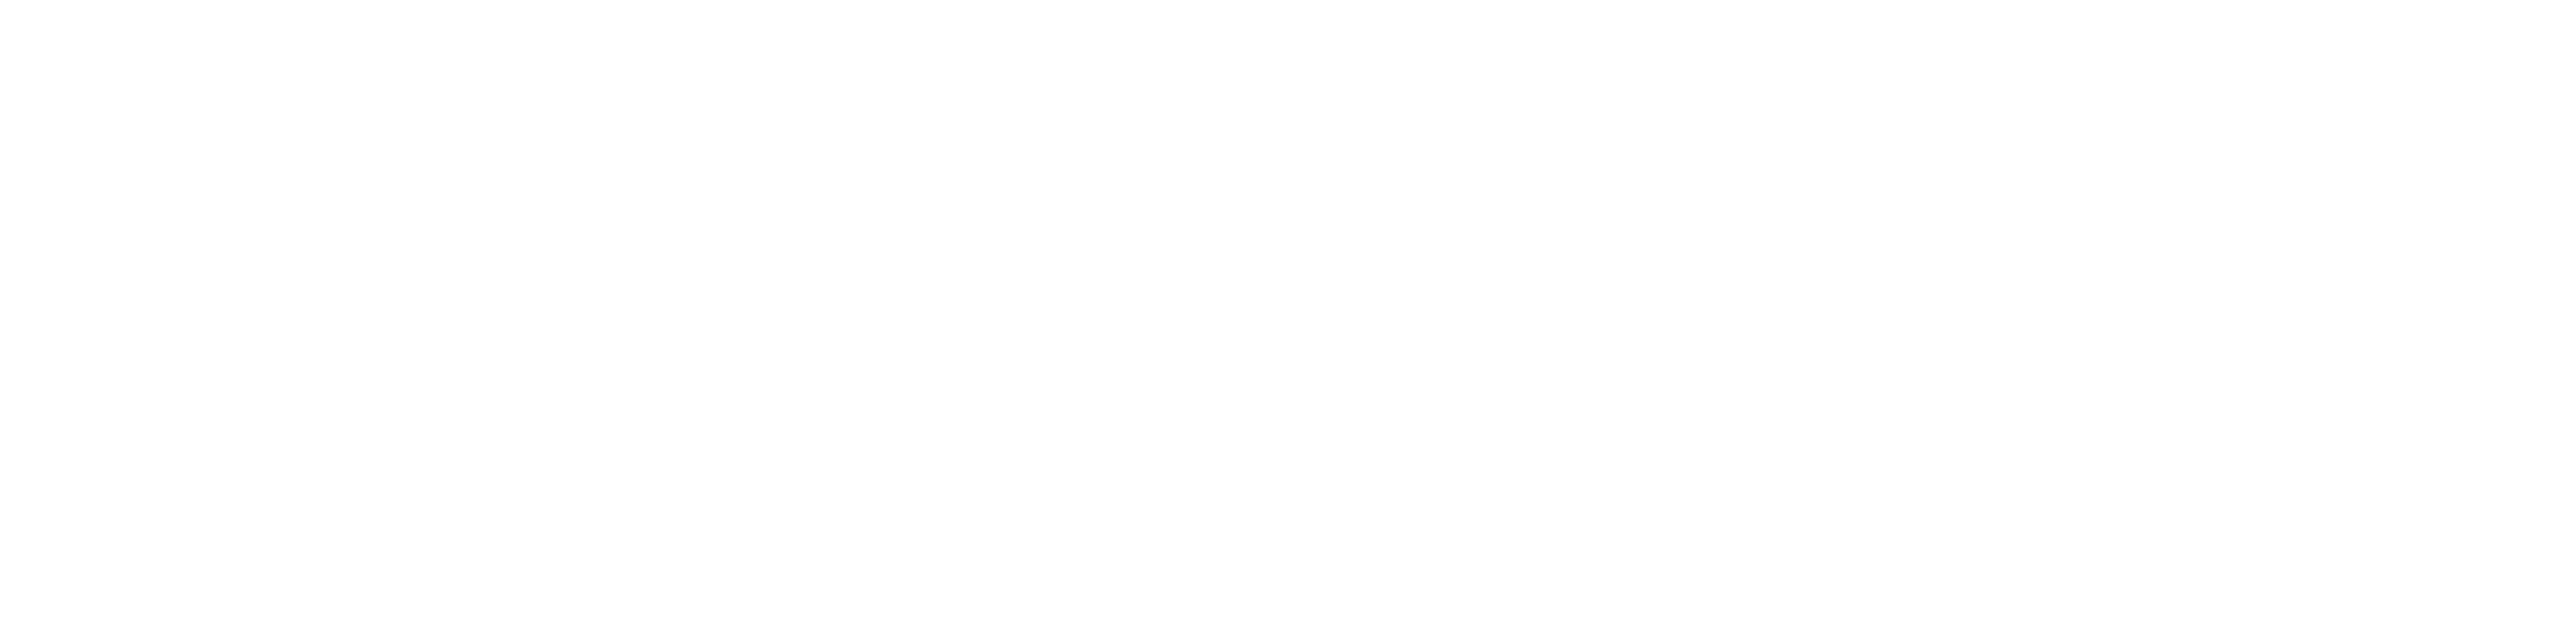

2020-06-12 16:19:41,659 logger INFO loss 1.570709, headKpFixingLoss 0.1582, MemUsed:125.41
2020-06-12 16:19:48,114 logger INFO loss 1.569660, headKpFixingLoss 0.1582, MemUsed:125.41
2020-06-12 16:19:54,600 logger INFO loss 1.569360, headKpFixingLoss 0.1583, MemUsed:125.41
2020-06-12 16:20:01,098 logger INFO loss 1.568774, headKpFixingLoss 0.1586, MemUsed:125.41
2020-06-12 16:20:07,670 logger INFO loss 1.568676, headKpFixingLoss 0.1577, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


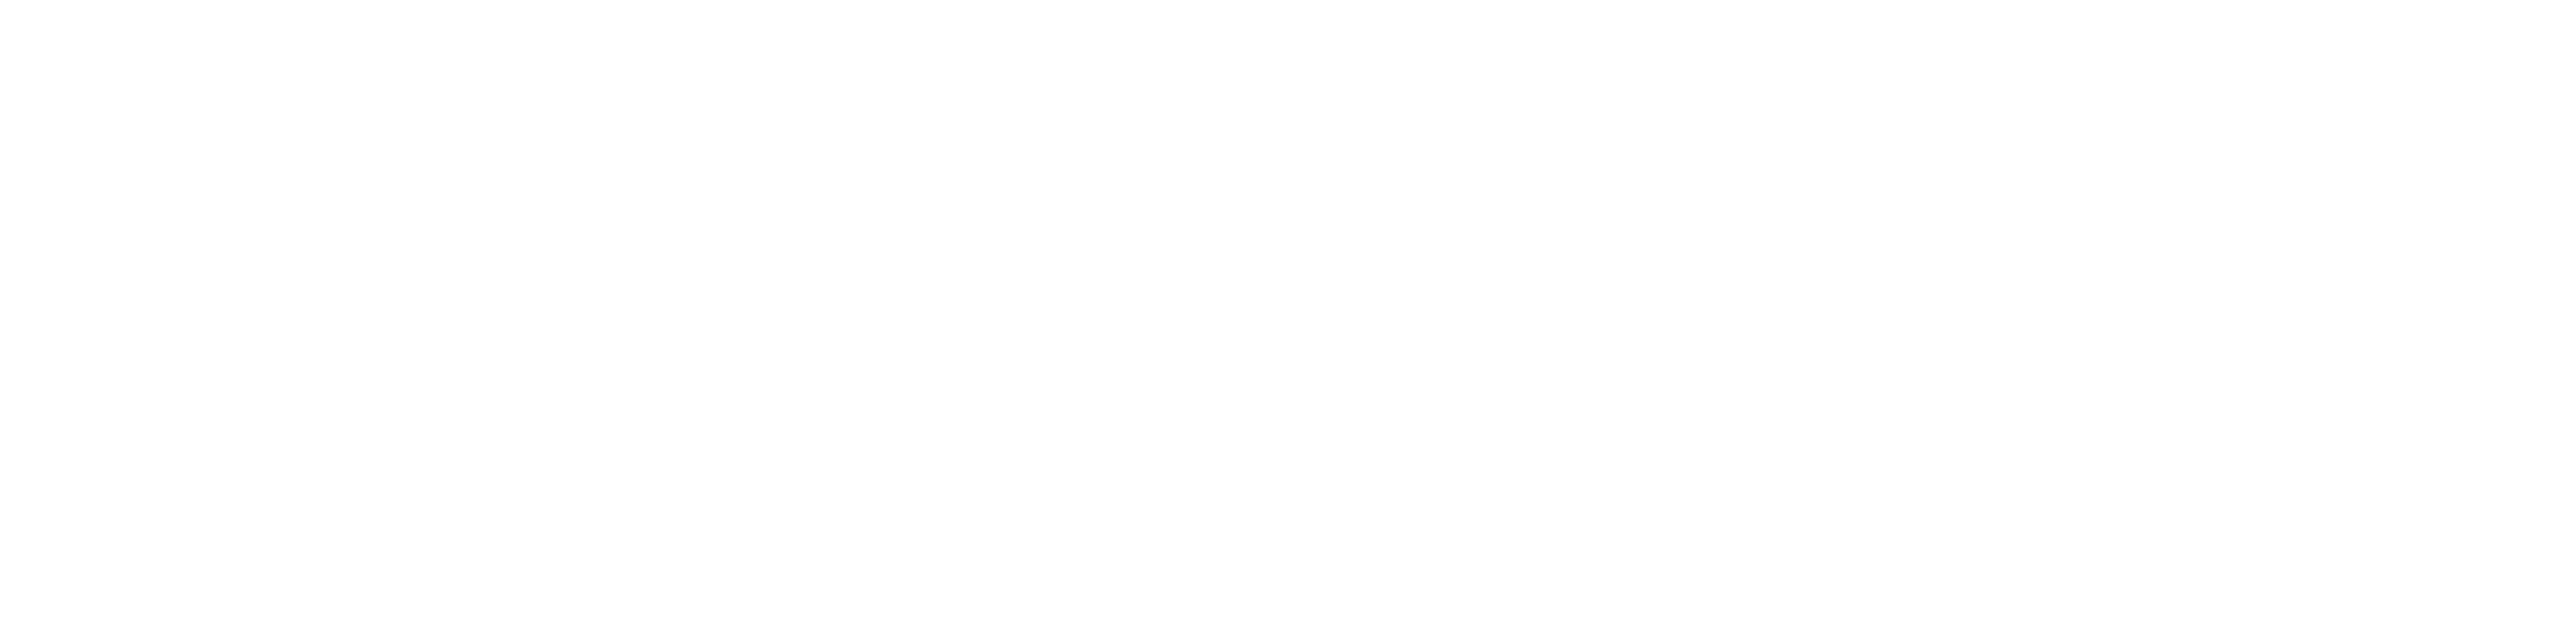

2020-06-12 16:20:31,518 logger INFO loss 1.570232, headKpFixingLoss 0.1561, MemUsed:125.41
2020-06-12 16:20:37,994 logger INFO loss 1.569707, headKpFixingLoss 0.1563, MemUsed:125.41
2020-06-12 16:20:44,483 logger INFO loss 1.567140, headKpFixingLoss 0.1586, MemUsed:125.41
2020-06-12 16:20:50,965 logger INFO loss 1.567044, headKpFixingLoss 0.1606, MemUsed:125.41
2020-06-12 16:20:57,454 logger INFO loss 1.566309, headKpFixingLoss 0.1591, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


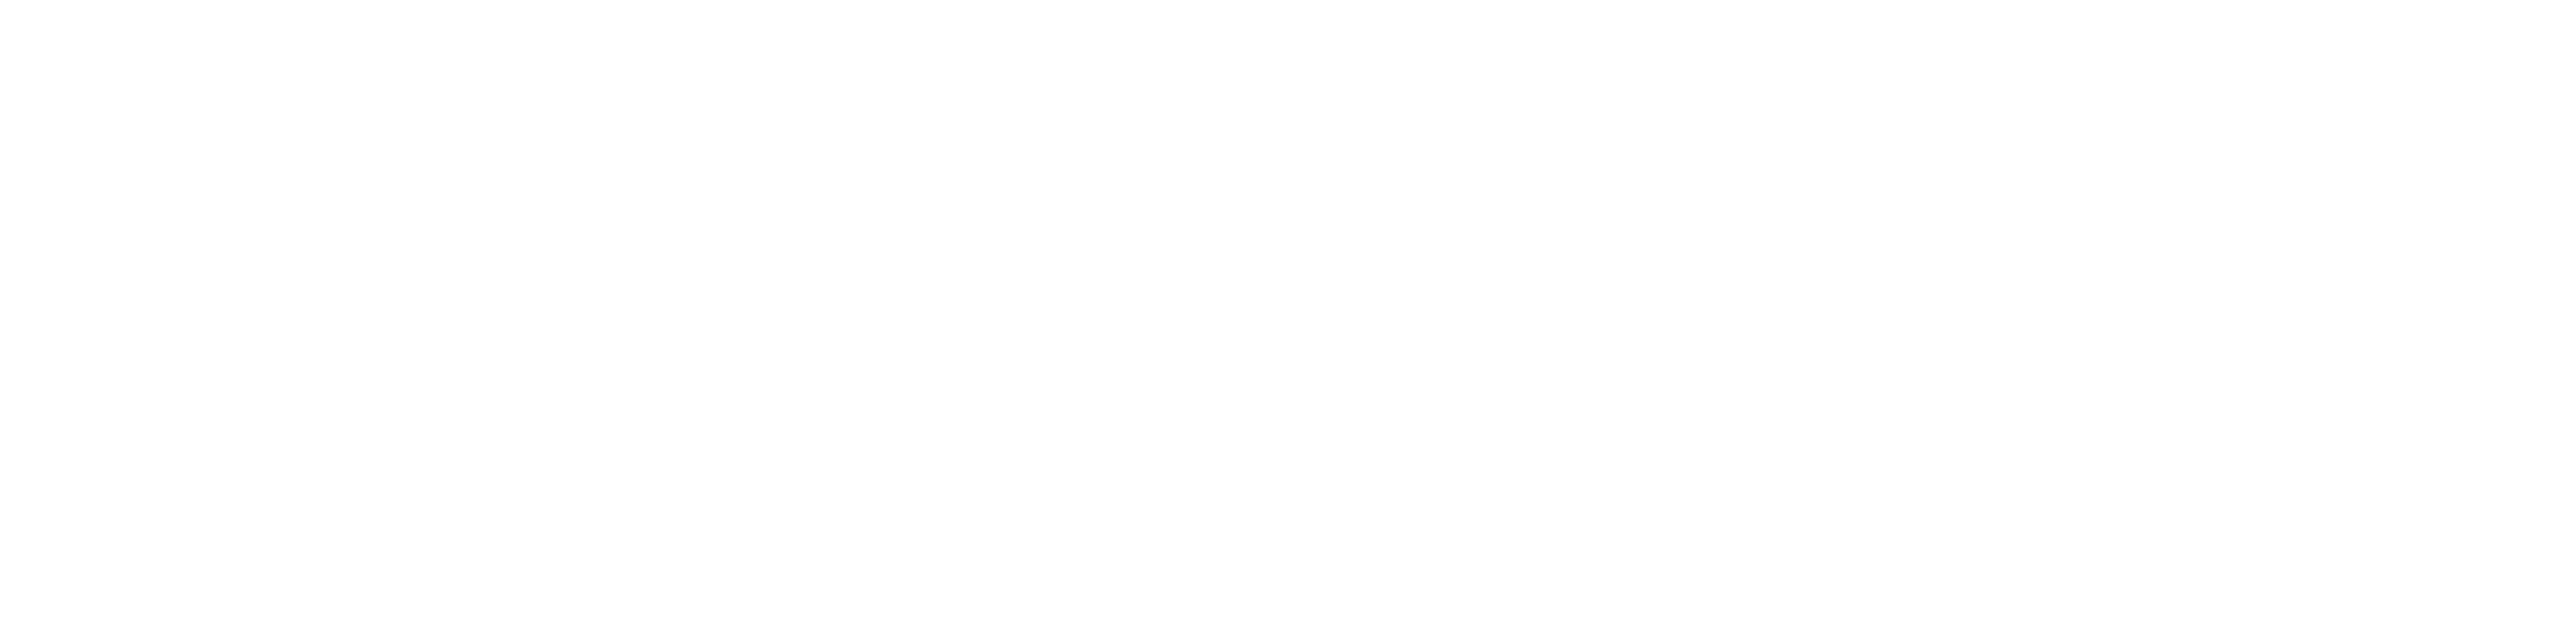

2020-06-12 16:21:21,504 logger INFO loss 1.567365, headKpFixingLoss 0.1579, MemUsed:125.41
2020-06-12 16:21:27,985 logger INFO loss 1.565364, headKpFixingLoss 0.1590, MemUsed:125.41
2020-06-12 16:21:34,496 logger INFO loss 1.566617, headKpFixingLoss 0.1597, MemUsed:125.41
2020-06-12 16:21:41,038 logger INFO loss 1.566141, headKpFixingLoss 0.1599, MemUsed:125.41
2020-06-12 16:21:47,633 logger INFO loss 1.566601, headKpFixingLoss 0.1584, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


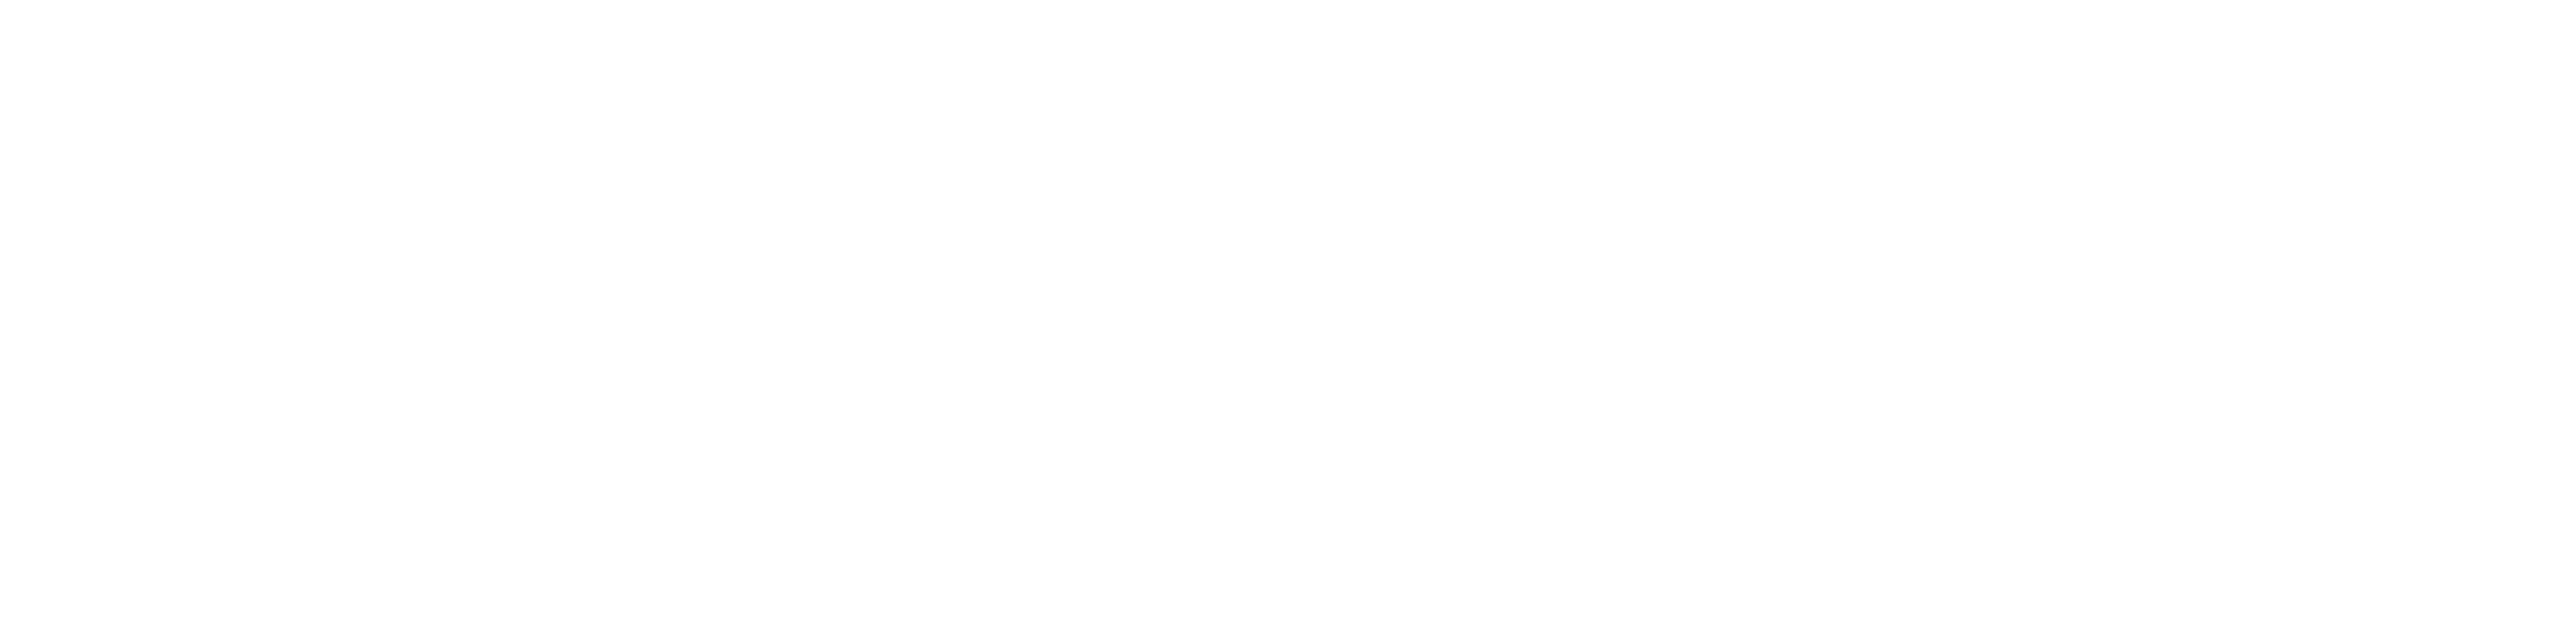

2020-06-12 16:22:11,513 logger INFO loss 1.566718, headKpFixingLoss 0.1579, MemUsed:125.41
2020-06-12 16:22:17,974 logger INFO loss 1.565254, headKpFixingLoss 0.1596, MemUsed:125.41
2020-06-12 16:22:24,448 logger INFO loss 1.564362, headKpFixingLoss 0.1597, MemUsed:125.41
2020-06-12 16:22:30,941 logger INFO loss 1.563518, headKpFixingLoss 0.1597, MemUsed:125.41
2020-06-12 16:22:37,428 logger INFO loss 1.563537, headKpFixingLoss 0.1603, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


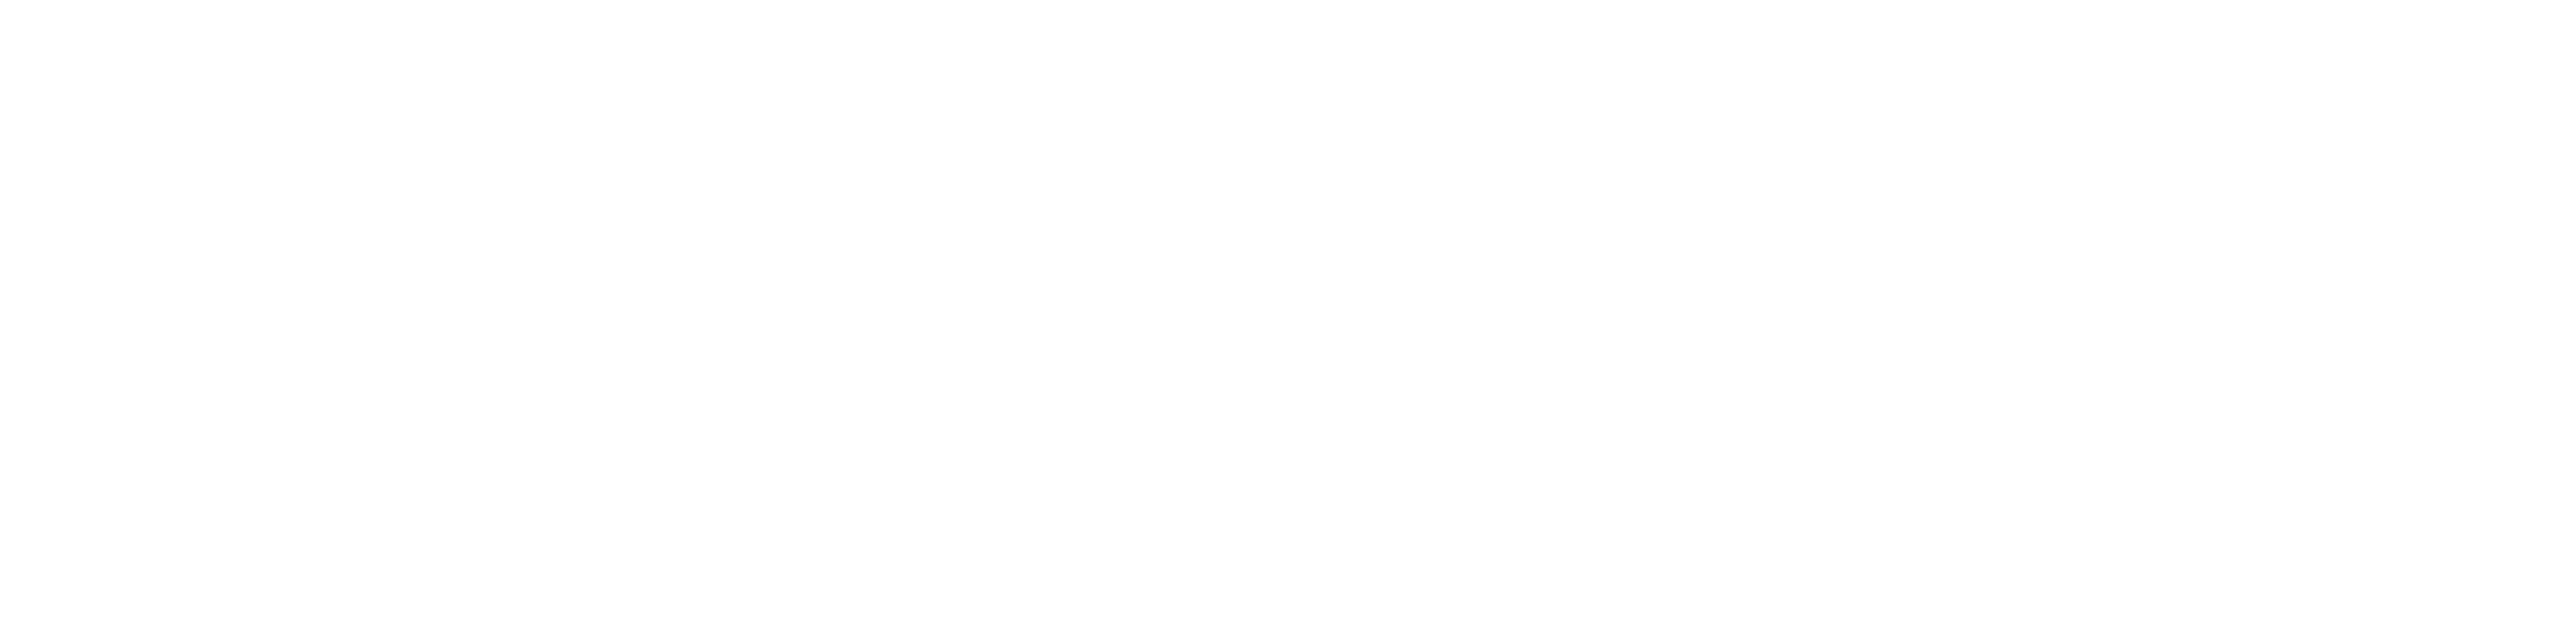

2020-06-12 16:23:01,386 logger INFO loss 1.563272, headKpFixingLoss 0.1592, MemUsed:125.41
2020-06-12 16:23:07,846 logger INFO loss 1.564846, headKpFixingLoss 0.1588, MemUsed:125.41
2020-06-12 16:23:14,339 logger INFO loss 1.563559, headKpFixingLoss 0.1598, MemUsed:125.41
2020-06-12 16:23:20,835 logger INFO loss 1.563684, headKpFixingLoss 0.1607, MemUsed:125.41
2020-06-12 16:23:27,367 logger INFO loss 1.561785, headKpFixingLoss 0.1606, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


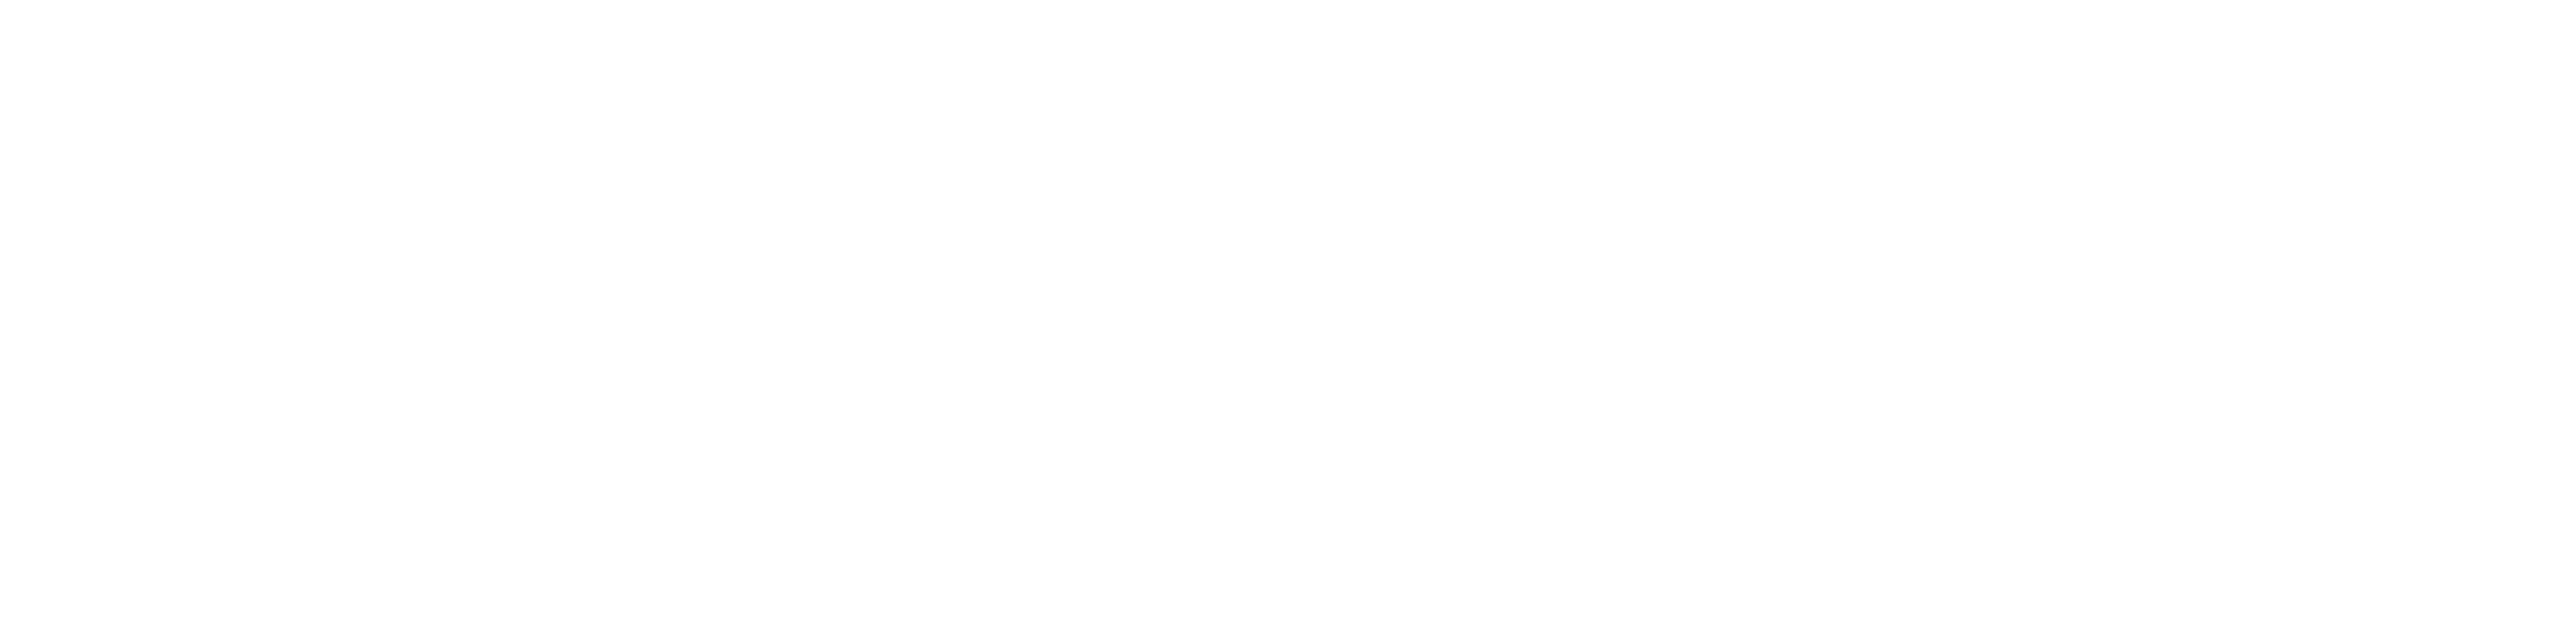

2020-06-12 16:23:51,305 logger INFO loss 1.561924, headKpFixingLoss 0.1591, MemUsed:125.41
2020-06-12 16:23:57,779 logger INFO loss 1.562552, headKpFixingLoss 0.1597, MemUsed:125.41
2020-06-12 16:24:04,279 logger INFO loss 1.560486, headKpFixingLoss 0.1605, MemUsed:125.41
2020-06-12 16:24:10,798 logger INFO loss 1.562118, headKpFixingLoss 0.1591, MemUsed:125.41
2020-06-12 16:24:17,332 logger INFO loss 1.562904, headKpFixingLoss 0.1585, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


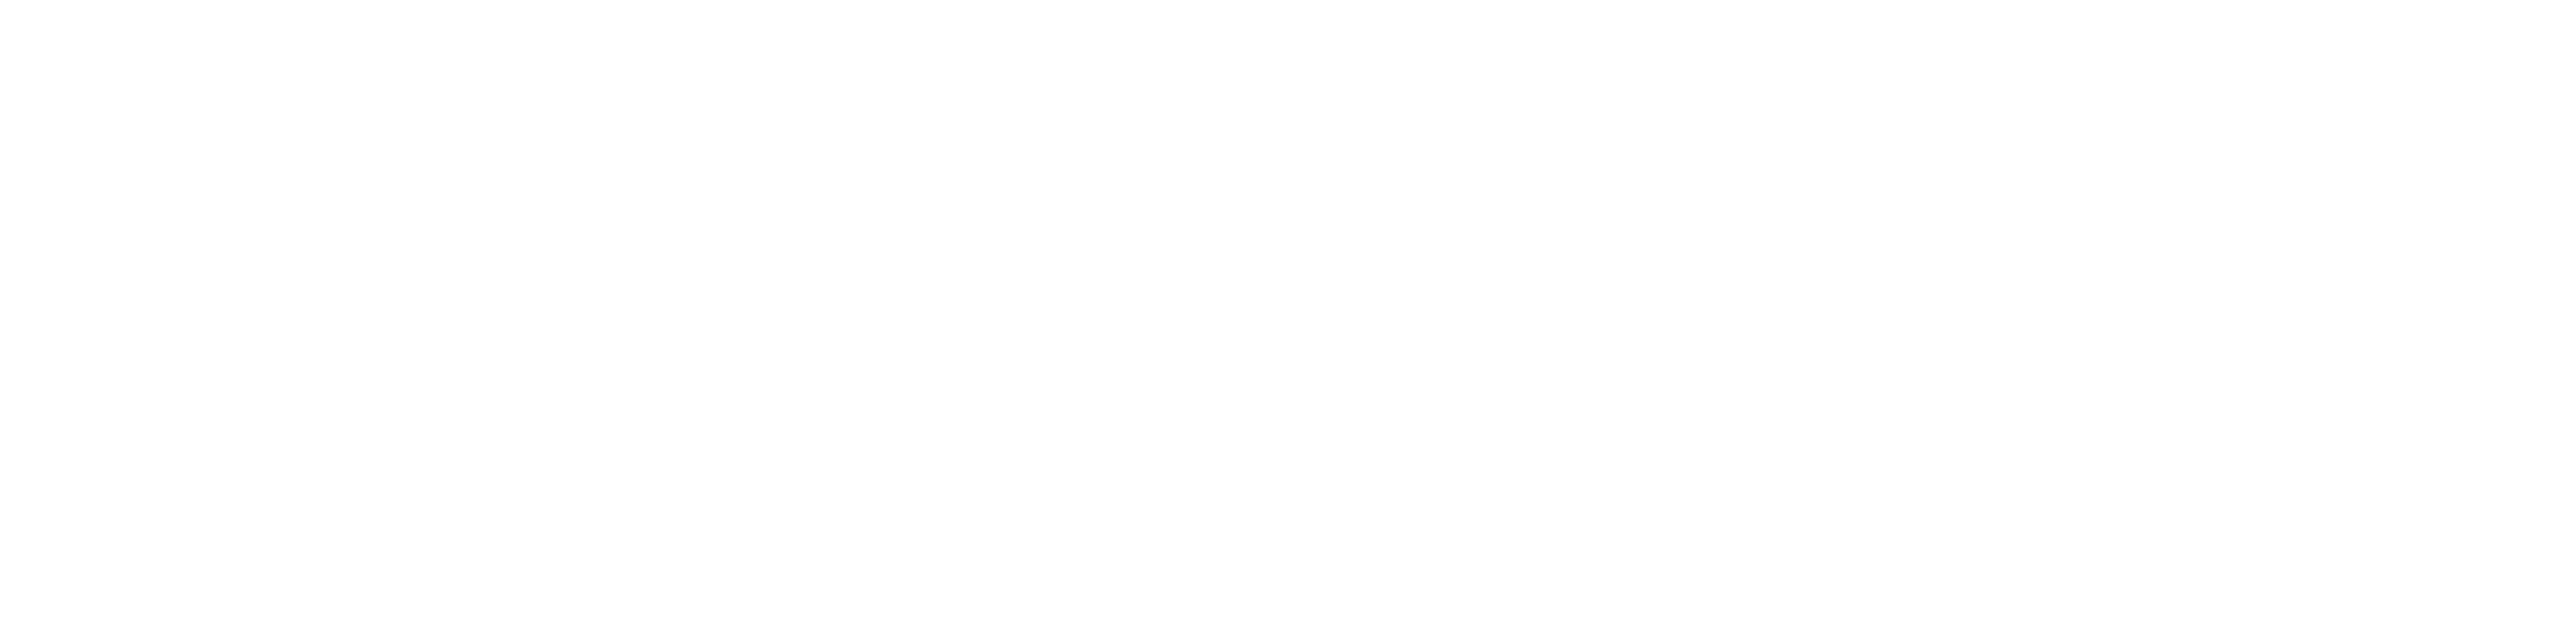

2020-06-12 16:24:41,126 logger INFO loss 1.562101, headKpFixingLoss 0.1596, MemUsed:125.41
2020-06-12 16:24:47,640 logger INFO loss 1.561669, headKpFixingLoss 0.1605, MemUsed:125.41
2020-06-12 16:24:54,126 logger INFO loss 1.560353, headKpFixingLoss 0.1602, MemUsed:125.41
2020-06-12 16:25:00,618 logger INFO loss 1.561156, headKpFixingLoss 0.1589, MemUsed:125.41
2020-06-12 16:25:07,126 logger INFO loss 1.561176, headKpFixingLoss 0.1587, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


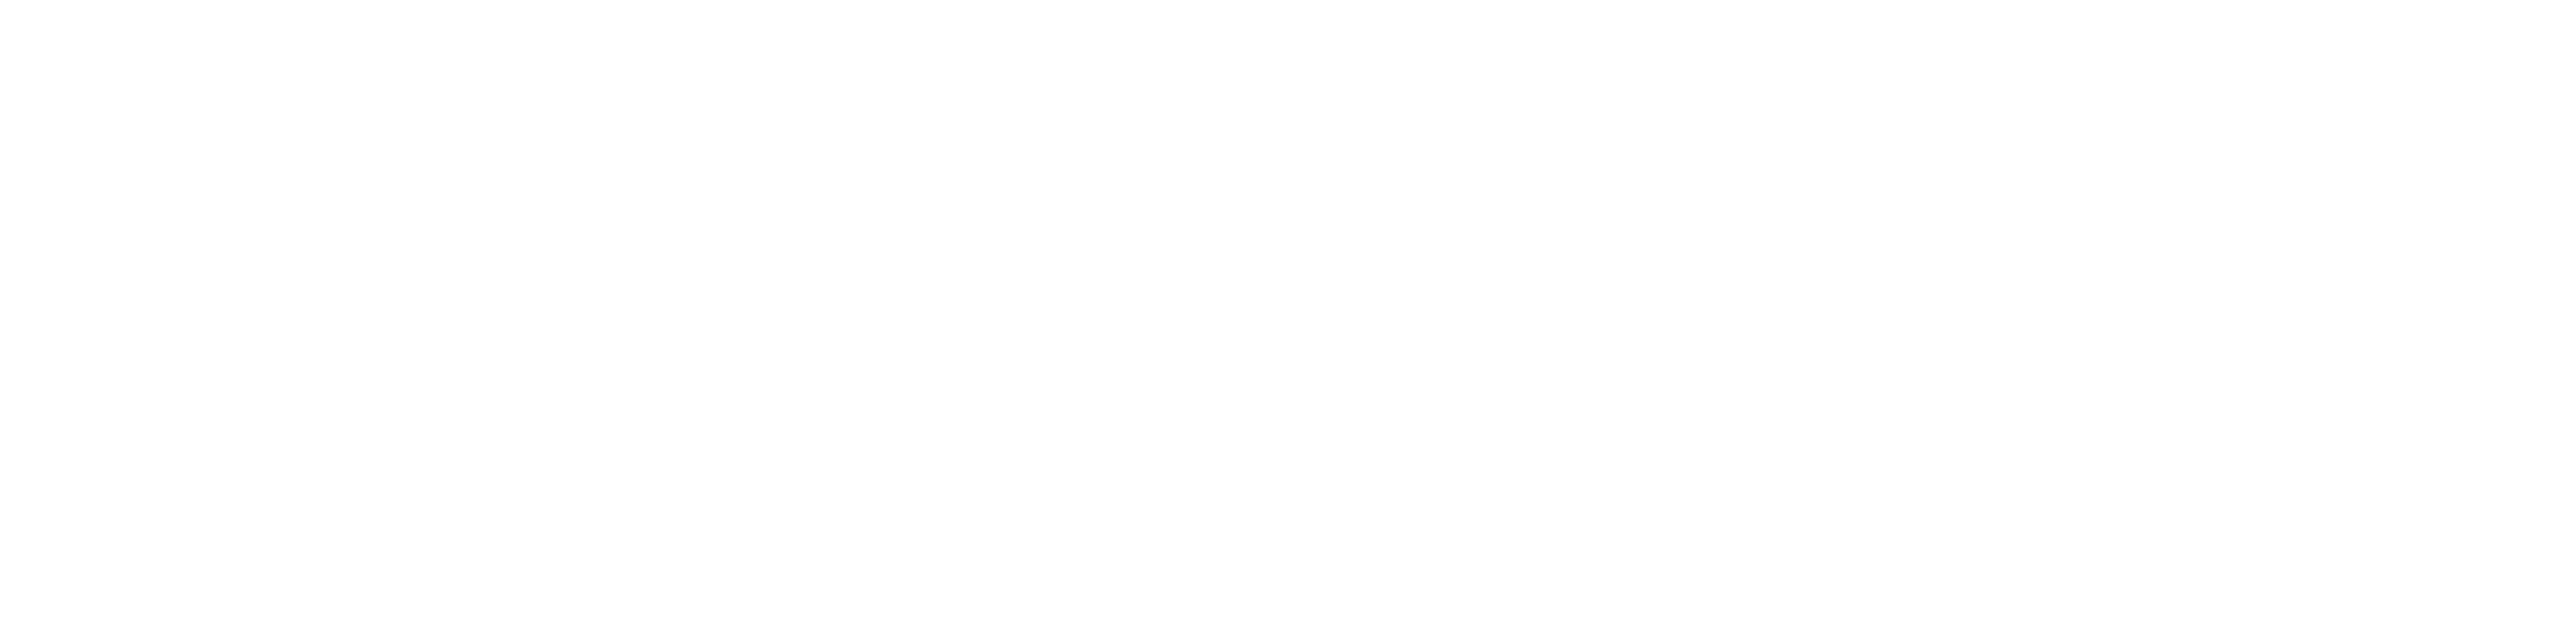

2020-06-12 16:25:31,199 logger INFO loss 1.560247, headKpFixingLoss 0.1592, MemUsed:125.41
2020-06-12 16:25:37,698 logger INFO loss 1.560341, headKpFixingLoss 0.1594, MemUsed:125.41
2020-06-12 16:25:44,204 logger INFO loss 1.559486, headKpFixingLoss 0.1600, MemUsed:125.41
2020-06-12 16:25:50,708 logger INFO loss 1.559415, headKpFixingLoss 0.1591, MemUsed:125.41
2020-06-12 16:25:57,325 logger INFO loss 1.559127, headKpFixingLoss 0.1603, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


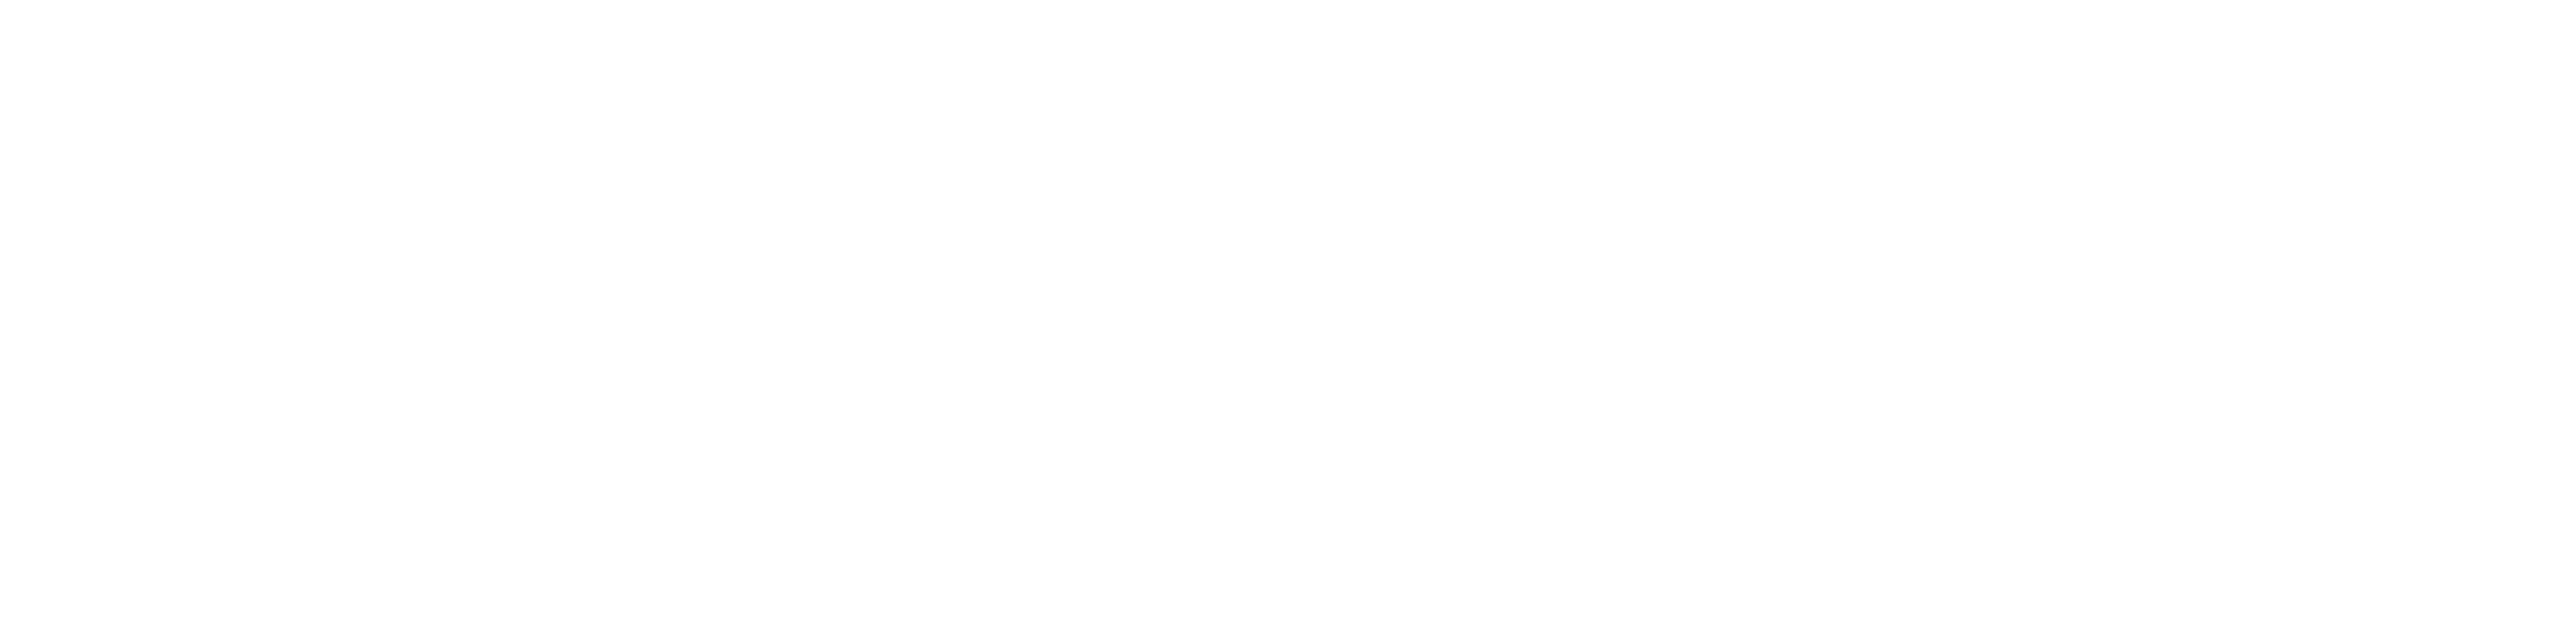

2020-06-12 16:26:21,195 logger INFO loss 1.558901, headKpFixingLoss 0.1604, MemUsed:125.41
2020-06-12 16:26:27,689 logger INFO loss 1.559566, headKpFixingLoss 0.1593, MemUsed:125.41
2020-06-12 16:26:34,211 logger INFO loss 1.559495, headKpFixingLoss 0.1591, MemUsed:125.41
2020-06-12 16:26:40,728 logger INFO loss 1.560046, headKpFixingLoss 0.1592, MemUsed:125.41
2020-06-12 16:26:47,222 logger INFO loss 1.559620, headKpFixingLoss 0.1596, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


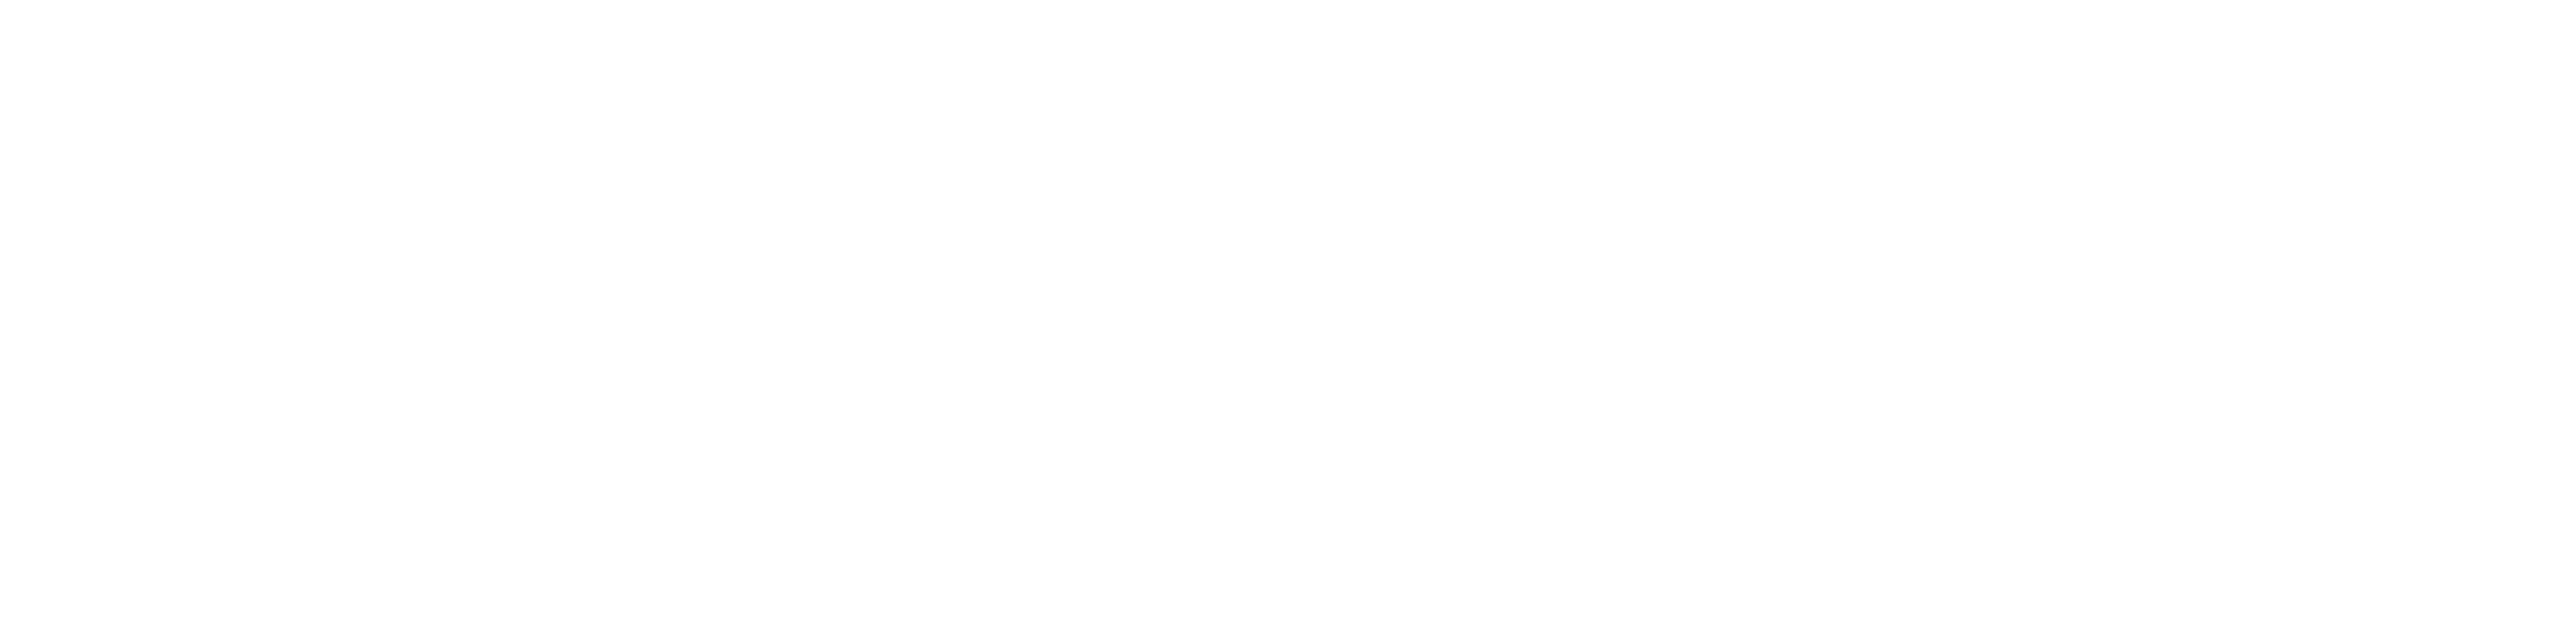

2020-06-12 16:27:11,045 logger INFO loss 1.560457, headKpFixingLoss 0.1582, MemUsed:125.41
2020-06-12 16:27:17,534 logger INFO loss 1.563914, headKpFixingLoss 0.1562, MemUsed:125.41
2020-06-12 16:27:23,995 logger INFO loss 1.558972, headKpFixingLoss 0.1587, MemUsed:125.41
2020-06-12 16:27:30,518 logger INFO loss 1.558439, headKpFixingLoss 0.1613, MemUsed:125.41
2020-06-12 16:27:37,024 logger INFO loss 1.559406, headKpFixingLoss 0.1599, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


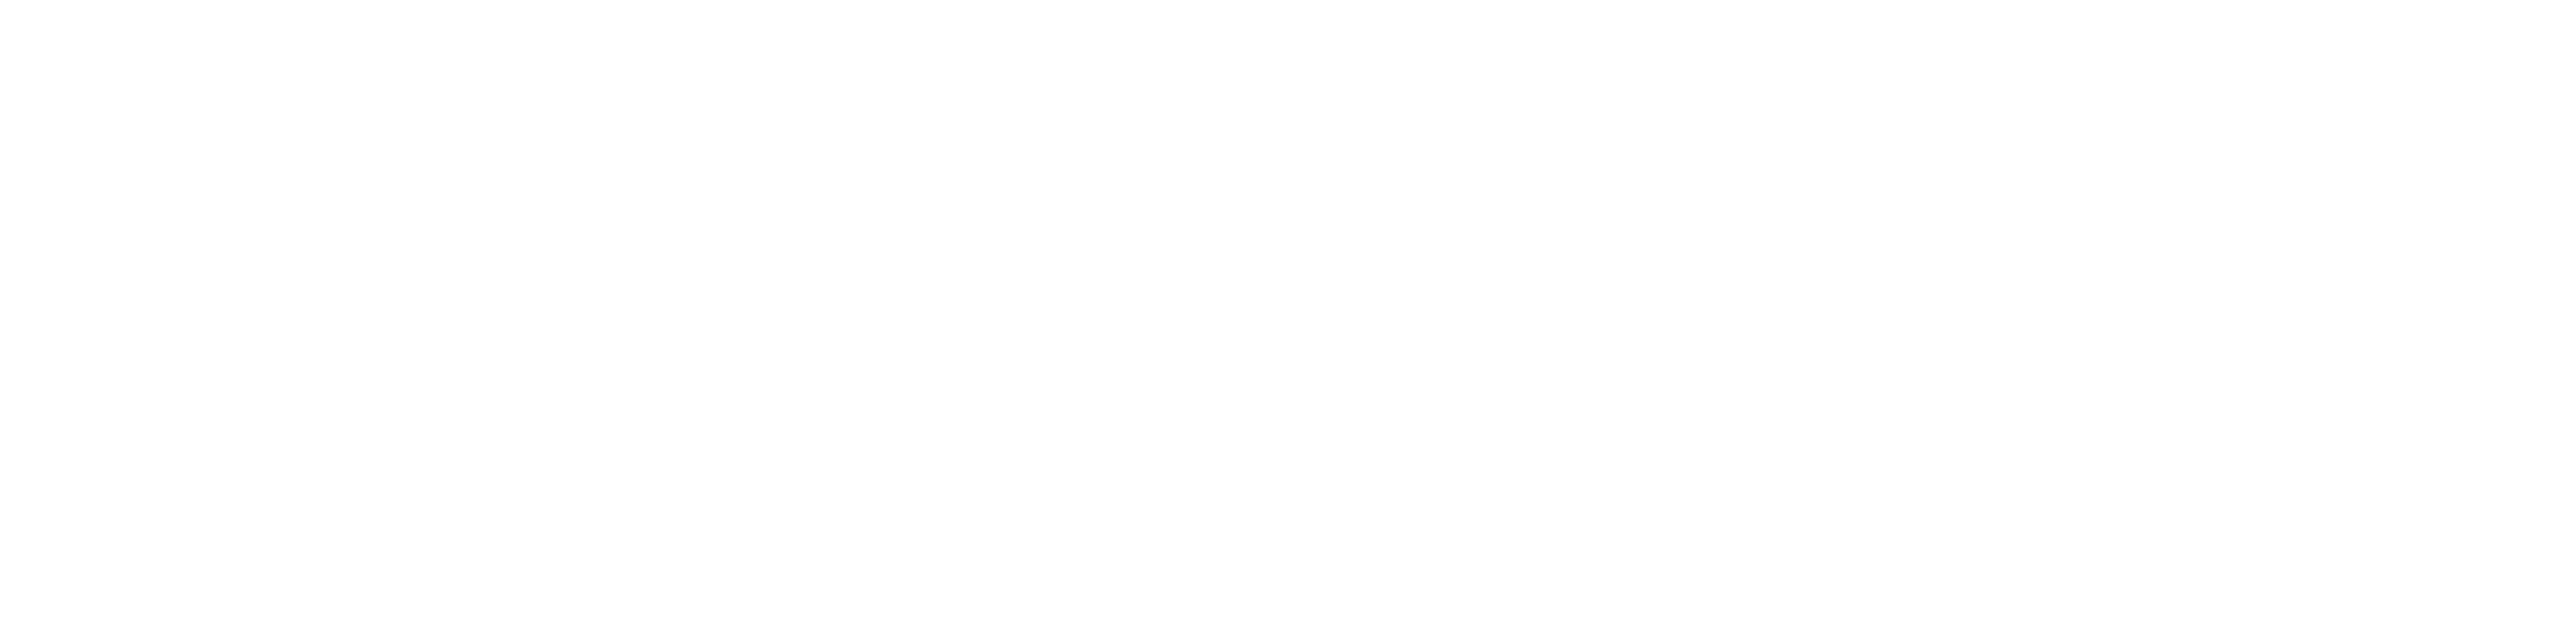

2020-06-12 16:28:01,074 logger INFO loss 1.558105, headKpFixingLoss 0.1601, MemUsed:125.41
2020-06-12 16:28:07,573 logger INFO loss 1.558556, headKpFixingLoss 0.1585, MemUsed:125.41
2020-06-12 16:28:14,071 logger INFO loss 1.558143, headKpFixingLoss 0.1595, MemUsed:125.41
2020-06-12 16:28:20,627 logger INFO loss 1.559476, headKpFixingLoss 0.1603, MemUsed:125.41
2020-06-12 16:28:27,200 logger INFO loss 1.559593, headKpFixingLoss 0.1580, MemUsed:125.41
Before release: active_bytes.all.current: 125.412352 MB
After release: active_bytes.all.current: 125.412352 MB


<IPython.core.display.Javascript object>


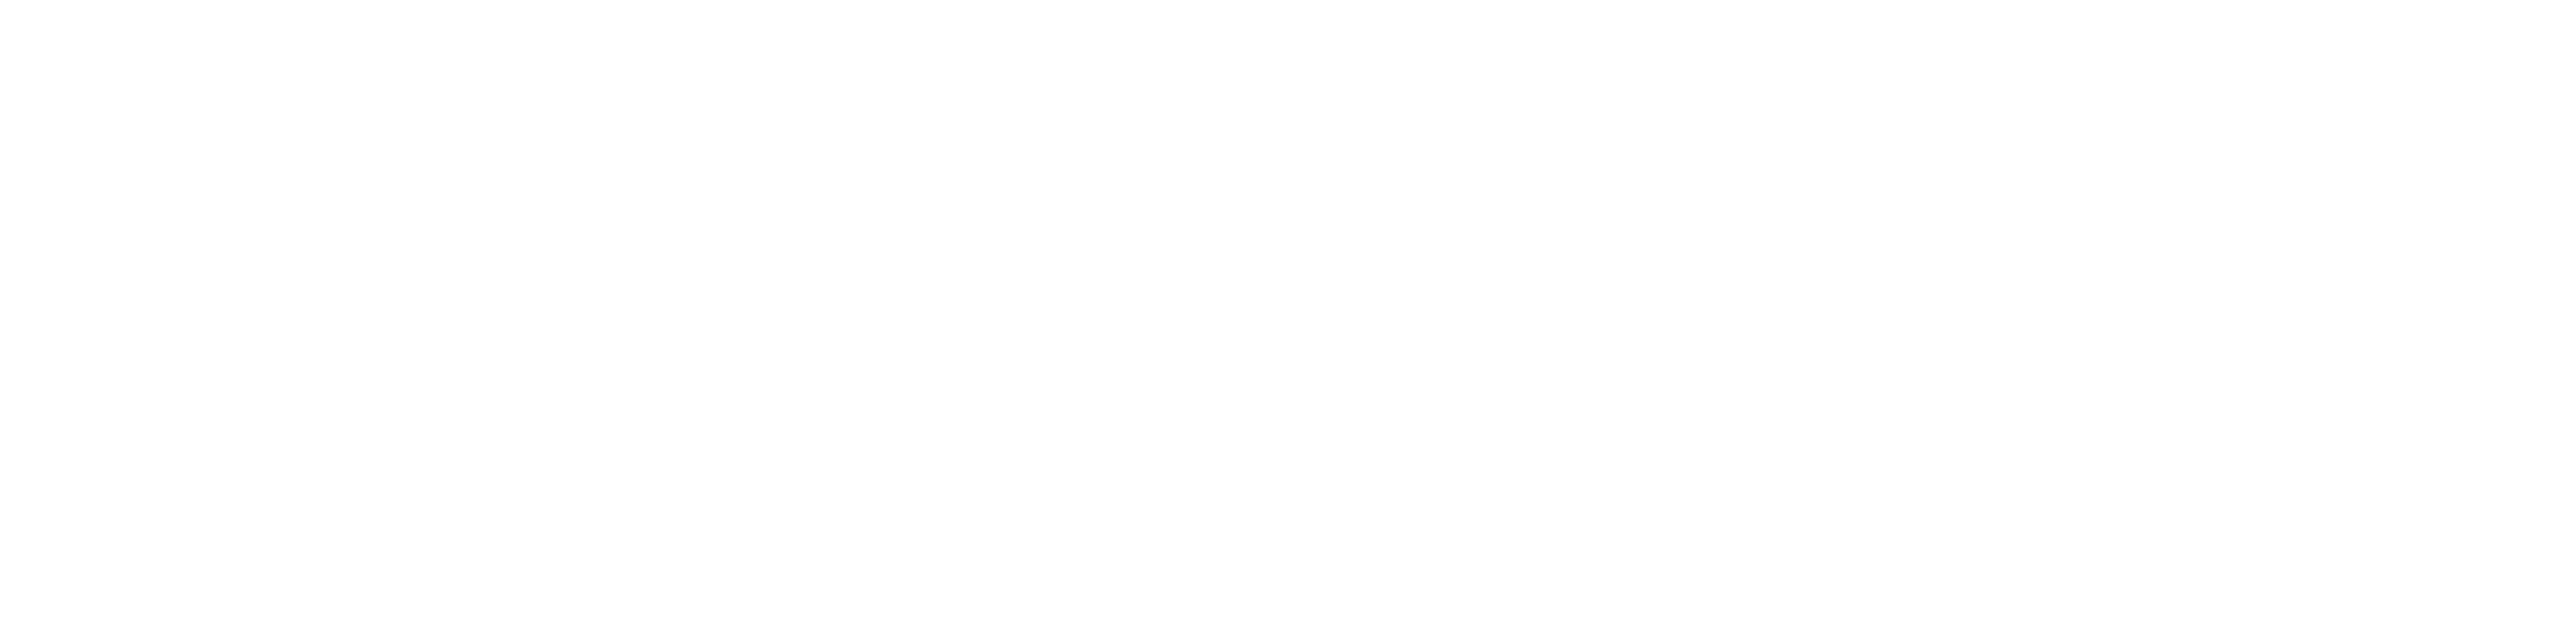

2020-06-12 16:28:51,276 logger INFO loss 1.561734, headKpFixingLoss 0.1561, MemUsed:125.41
2020-06-12 16:28:57,827 logger INFO loss 1.558871, headKpFixingLoss 0.1591, MemUsed:125.41



KeyboardInterrupt: 

In [21]:
cfg.plotStep = 5
cfg.numIterations = 300
loop = tqdm_notebook(range(cfg.numIterations))

for i in loop:
    optimizer.zero_grad()
#     torch.cuda.empty_cache()

    lossVal = 0
    for iCam in range(cfg.numCams):
        refImg = torch.tensor(crops_out[iCam][..., 0], dtype=torch.float32, device=device, requires_grad=False)
        verts = smplsh(betas, pose, trans).type(torch.float32) * 1000
        smplshMesh = Meshes([verts], [smplsh.faces.to(device)])
        
        images = renderSynth.renderer(smplshMesh, cameras=cams[iCam])
#         print(images.requires_grad)
#         print(modifiedVerts.requires_grad)
        loss = 1 - torch.norm(refImg * images[..., 3], p=1) / torch.norm(refImg + images[..., 3] - refImg * images[..., 3], p=1)
        
        loss.backward()
        lossVal += loss.item()
        #showCudaMemUsage(device)
    
#     mesh = Meshes(
#                 verts=[modifiedVerts],   
#                 faces=[faces_idx], 
# #                 textures=textures.to(device)
#             )
#     loss = cfg.normalSmootherW * mesh_normal_consistency(mesh)
    
# #     print("Laplacian on normal shift",  cfg.lpSmootherW * normalShift.transpose(0,1) @ LNP @ normalShift)
    
#     # Laplacian on shift in normal direction
#     loss = loss + cfg.lpSmootherW * normalShift.transpose(0,1) @ LNP @ normalShift
    
#     loss.backward()
#     lossVal += loss.item()
    # targetImg = images[0, ..., :3]
    # loss, _ = model()
    
    # joint regularizer
    loss = cfg.jointRegularizerWeight * torch.sum((pose**2))
    loss.backward()
    
    # recordData
    
    verts, jointsDeformed = smplsh(betas, pose, trans, returnDeformedJoints=True).type(torch.float32) * 1000
    verts = verts.type(torch.float32)
    jointsDeformed = jointsDeformed.type(torch.float32)
    #     headJoints = smplshRegressorMatHead @ verts
    jointConverter = Utility.VertexToOpJointsConverter()
    opJoints = jointConverter(smplshVerts[None,...], joints[None,...])
    
    headJointsId = [0, 15, 16, 17, 18]


    loss = cfg.kpFixingWeight * torch.sum((headJoints - headKps)**2)
    loss.backward()
    headKpFixingLoss = loss.item()
                     
    losses.append(lossVal)
    
    if i:
        optimizer.step()
        
    memStats = torch.cuda.memory_stats(device=device)
    memAllocated =  memStats['active_bytes.all.current'] / 1000000
    torch.cuda.empty_cache()
    
    infoStr = 'loss %.6f, headKpFixingLoss %.4f, MemUsed:%.2f' \
        % (lossVal, headKpFixingLoss, memAllocated)
    
    loop.set_description(infoStr)
    logger.info(infoStr)
    
    #if lossVal < cfg.terminateLoss:
    #    break
    
    # Save outputs to create a GIF. 
    if i % cfg.plotStep == 0:
        showCudaMemUsage(device)
        verts = smplsh(betas, pose, trans).type(torch.float32) * 1000
        smplshMesh = Meshes([verts], [smplsh.faces.to(device)])

        plt.close('all')
        
        outImgFile = join(outFolderForExperiment, 'Fig_' + str(i).zfill(5) + '.png')
        renderedImages = []
        with torch.no_grad():
            for iCam in range(len(cams)):
                image_cur = renderSynth.renderer(smplshMesh,  cameras=cams[iCam])
#                 images.append(image_cur.cpu().detach().numpy())
#                 imgDiff = np.abs(image_cur.cpu().detach().numpy() - crops_out[iCam][..., 0])
                renderedImages.append(image_cur.cpu().detach().numpy())
            torch.cuda.empty_cache()

#             showCudaMemUsage(device)
#         visualize2DResults(diffImages, outImgFile=outImgFile, sizeInInches=5)
        visualize2DSilhouetteResults(renderedImages, backGroundImages = crops_out, outImgFile=outImgFile, sizeInInches=5)
        
        saveVTK(join(outFolderMesh, 'Fit' + str(i).zfill(5) + '.ply'), verts.cpu().detach().numpy(), smplshExampleMesh)


In [ ]:
transVal = trans.cpu().detach().numpy()
poseVal = pose.cpu().detach().numpy()
betaVal = betas.cpu().detach().numpy()

outParamFile = join(outFolderForExperiment,  'FittingParam.npz')
np.savez(outParamFile, trans = transVal, pose=poseVal, beta=betaVal)